# Prévisions météorologiques

### Description :

Dans le cadre de ce projet universitaire, nous avons exploré les données météorologiques historiques de Londres, allant du 1er janvier 2011 au 31 décembre 2020, afin de développer des modèles prédictifs pour la température moyenne. Notre démarche intègre une combinaison d'approches de Machine Learning et de Deep Learning allant de méthodes traditionnelles aux architectures neuronales plus complexes. Nous avons pour but d'améliorer la précision des prévisions qui peuvent être essentielles pour de nombreux secteurs économiques et de planifications urbaines.

### Objectifs :

L'objectif principal de ce projet est de construire et de comparer des modèles prédictifs performants pour la prévision de la température moyenne à Londres sur une période d'un an. Nous avons également testé la capacité de ces modèles à prédire la température moyenne sur des horizons temporels plus courts, notamment sur une période de 7 jours et d'un mois, afin de déterminer s'ils continuaient à fonctionner efficacement sur des intervalles de prévision plus courts.

Nous nous sommes appuyées sur deux approches principales :

1. Première approche : Utilisation des Gated Recurrent Units (GRU) pour modéliser la dépendance séquentielle et saisonnière des données
2. Deuxième approche : Utilisation de l'algorithme CatBoost qui intègre des features laguées d'au moins une année

Ces méthodes ont des implications directes dans des domaines comme le tourisme, où une prévision précise peut influencer la gestion des activités saisonnières, ou l'énergie, où elles peuvent contribuer à une meilleure allocation des ressources. Une prédiction sur un an est donc pertinente dans ce genre de domaine. 

### Table des matières :
* [1. Présentation du jeu de données](#1.)
* [2. Exploration du jeu de données](#2.)
    * [2.1. Downcasting](#2.1.)
    * [2.2. EDA](#2.2.)
    * [2.3. Etude de la saisonnalité](#2.3.)
* [3. Data cleaning](#3.)
    * [3.1. Présence de valeurs manquantes](#3.1.)
    * [3.2. Imputation par Forward fill](#3.2.)
    * [3.3. Imputation par MICE](#3.3.)
* [4. Feature engineering](#4.)
    * [4.1. Features "métier"](#4.1.)
    * [4.2. Features cycliques](#4.2.)
    * [4.3. Features retardées](#4.3.)
* [5. Prétraitement des données pour la modélisation prédictive](#5.)
    * [5.1. Ajustement des données pour la modélisation](#5.1.)
    * [5.2. Split](#5.2.)
* [6. Sélection des modèles](#6.)
    * [6.1. Modèles naïfs](#6.1.)
    * [6.2. Choix des modèles de prévision](#6.2.)
        * [6.2.1. Première approche : sélection du modèle](#6.2.1.)
        * [6.2.2. Deuxième approche : sélection du modèle](#6.2.2.)
* [7. Evaluation de la perfomance des modèles](#7.)
    * [7.1. Première approche](#7.1.)
        * [7.1.1. Optimisation](#7.1.1.)
        * [7.1.2. Évaluation finale sur l'ensemble de test](#7.1.2.)
    * [7.2. Deuxième approche](#7.2.)
        * [7.2.1. Optimisation](#7.2.1.)
        * [7.2.2. Évaluation finale sur l'ensemble de test](#7.2.2.)
    * [7.3. Visualisation des résultats](#7.3.)
    * [7.4. Exploitation sur différents horizons](#7.4.)
        * [7.4.1. Horizon de prévision : 7 jours](#7.4.1.)
        * [7.4.2. Horizon de prévision : 31 jours](#7.4.2.)
    * [7.5. Résumé des résultats sur les différents horizons](#7.5.)
* [8. Performance des modèles  - discussion](#8.)
* [9. Conclusion et améliorations](#9.)

In [1370]:
import os
import random

# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Analyse des séries temporelles
import pywt
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Imputation des données
from sklearn.impute import IterativeImputer

# Expérimentations avec MLflow
import mlflow
from mlflow import MlflowClient
import mlflow.sklearn

# Modélisation ML
from catboost import CatBoostRegressor

# Optimisation 
import tensorflow as tf
import optuna

# Prétraitement des données et standardisation
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Modélisation DL
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

# Métrique d'évaluation
from sklearn.metrics import root_mean_squared_error, mean_squared_error

<span id="1."></span>

## 1. Présentation du jeu de données

Pour ce projet nous disposons d'un jeu de données comportant des séries temporelles relatives à la météo à Londres. Cette base de données a été constituée en associant les relevés des attributs météorologiques individuels provenant de l'évaluation climatique européenne (ECA). Ces relevés ont été enregistrés par une station météorologique située à proximité de l'aéroport d'Heathrow entre 1979 et 2020. Le jeu de données entier est disponible ici : https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data. Cependant, dans le cadre de notre projet, nous utiliserons seulement les données allant de 2011 à 2020 afin de nous concentrer sur une période plus récente et représentative des conditions météorologiques actuelles. 

La base de données est composée des variables suivantes : 

- **date** - Date de la mesure enregistrée 
- **cloud_cover** - Mesure de la couverture nuageuse en oktas 
- **sunshine** - Mesure de l'ensoleillement en heures (hrs) 
- **global_radiation** - Mesure de l'irradiation en Watt par mètre carré (W/m2) 
- **max_temp** - Température maximale enregistrée en degrés Celsius (°C) 
- **mean_temp** - Température moyenne en degrés Celsius (°C) 
- **min_temp** - Température minimale enregistrée en degrés Celsius (°C) 
- **precipitation** - Mesure des précipitations en millimètres (mm) 
- **pressure** - Mesure de la pression en Pascals (Pa) 
- **snow_depth** - Mesure de l'épaisseur de la neige en centimètres (cm) 

In [1371]:
df = pd.read_csv("london_weather.csv")
df = df[df['date'] >= 20110101]

In [1372]:
df.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
11688  20110101          8.0       0.0              13.0       4.0        5.9   
11689  20110102          8.0       0.1              15.0       2.9        3.0   
11690  20110103          7.0       0.1              15.0       6.0        1.3   
11691  20110104          7.0       0.0              13.0       7.1        2.9   
11692  20110105          6.0       2.3              31.0       5.1        4.2   

       min_temp  precipitation  pressure  snow_depth  
11688       4.6            0.6  102500.0         0.0  
11689       1.9            0.0  102830.0         0.0  
11690      -0.3            0.0  102460.0         0.0  
11691      -0.3            0.0  101360.0         NaN  
11692       1.3            1.0  100040.0         0.0

In [1373]:
df.tail()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
15336  20201227          1.0       0.9              32.0       7.5        7.5   
15337  20201228          7.0       3.7              38.0       3.6        1.1   
15338  20201229          7.0       0.0              21.0       4.1        2.6   
15339  20201230          6.0       0.4              22.0       5.6        2.7   
15340  20201231          7.0       1.3              34.0       1.5       -0.8   

       min_temp  precipitation  pressure  snow_depth  
15336       7.6            2.0   98000.0         NaN  
15337      -1.3            0.2   97370.0         NaN  
15338       1.1            0.0   98830.0         NaN  
15339      -0.1            0.0  100200.0         NaN  
15340      -3.1            0.0  100500.0         NaN

In [1374]:
df.dtypes

date                  int64
cloud_cover         float64
sunshine            float64
global_radiation    float64
max_temp            float64
mean_temp           float64
min_temp            float64
precipitation       float64
pressure            float64
snow_depth          float64
dtype: object

In [1375]:
df.shape

(3653, 10)

In [1376]:
# Convertir la date année-mois-jour et la définir comme index
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.set_index('date')
df.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=3653, freq=None)

<span id="2."></span>

## 2. Exploration du jeu de données

<span id="2.1."></span>

### 2.1. Downcasting

Nous allons tout d'abord commencer par downcaster le DataFrame afin de réduire la quantité de stockage qu'il utilise et permettre l'accélération des opérations effectuées sur ce dernier. Cela sera particulièrement bénéfique pour la suite de notre étude lorsque nous utiliserons des modèles de Machine Learning et de Deep Learning sur nos données. 

In [1377]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

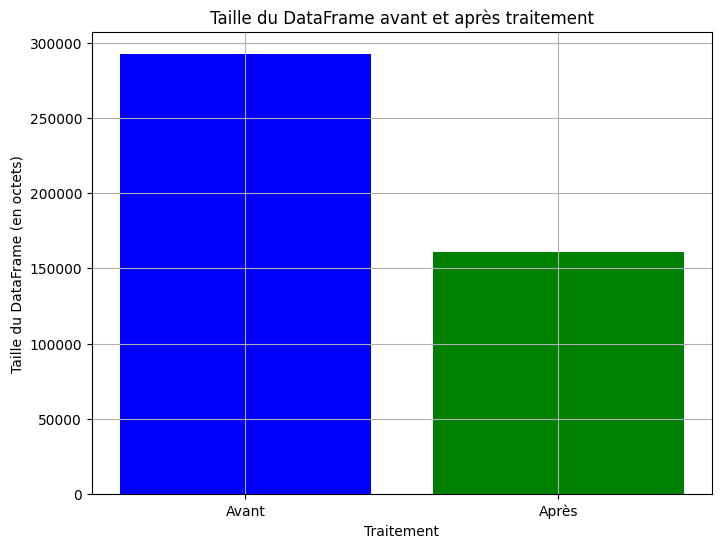

In [1378]:
before = df.memory_usage().sum()
df = downcast(df)
after = df.memory_usage().sum()

plt.figure(figsize=(8, 6))
plt.bar(['Avant', 'Après'], [before, after], color=['blue', 'green'])
plt.xlabel('Traitement')
plt.ylabel('Taille du DataFrame (en octets)')
plt.title('Taille du DataFrame avant et après traitement')
plt.grid(True)
plt.show()

Nous remarquons que cette opération a nettement réduit la taille du jeu de données. 

<span id="2.2."></span>

### 2.2. EDA

In [1379]:
# Récupérer le jour, le mois et l'année pour chaque date
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.weekday

# Remplacer les numéros par leurs noms pour les jours, les mois et les saisons
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['Day'] = df['Day'].apply(lambda x: days[x])

seasons = {12: 'Winter', 1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall'}
df['Season'] = df['Month'].apply(lambda x: seasons[x])

months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df['Month'] = df['Month'].apply(lambda x: months[x])

- Possède-t-on des données complètes ?

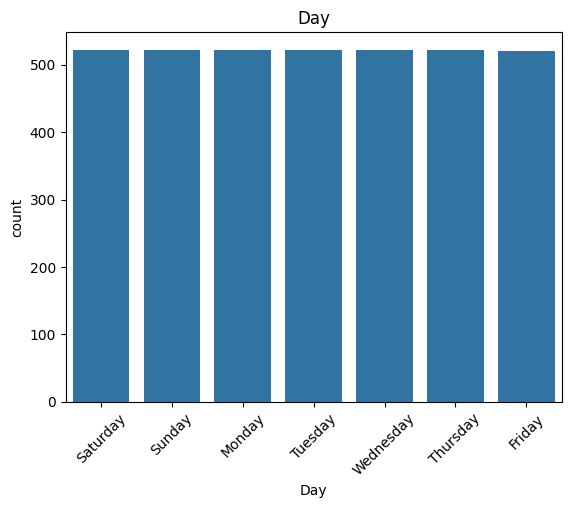

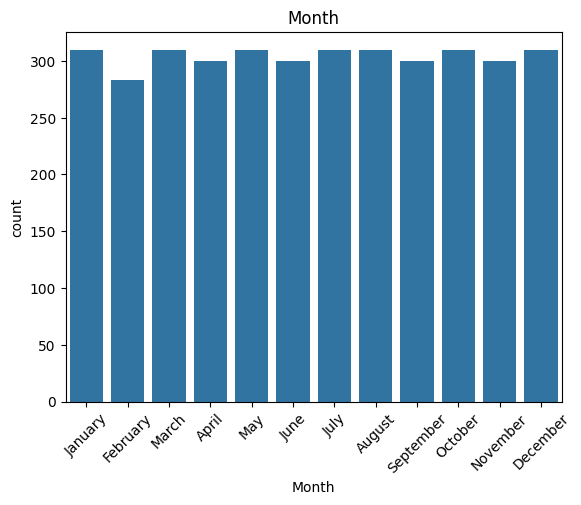

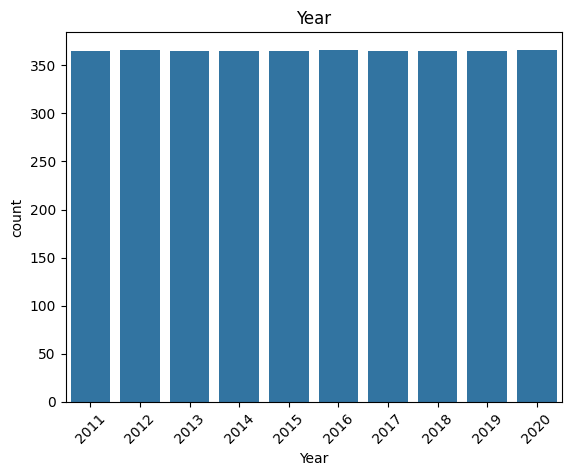

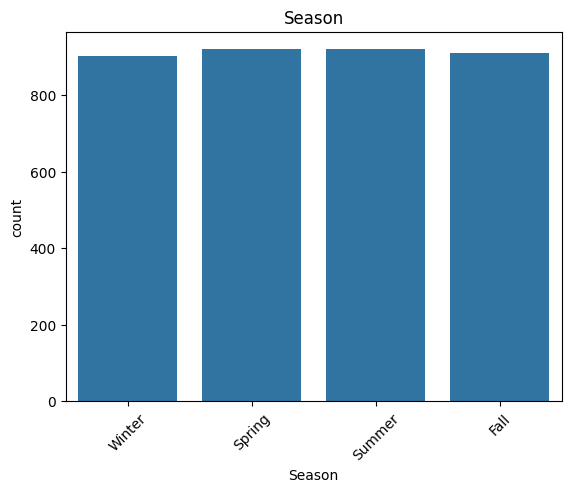

In [1380]:
for col in ["Day", "Month", "Year", "Season"]:
    sns.countplot(data=df, x=col)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()  

**Jours**

Pour les jours de la semaine, nous disposons de données pour chacun d'entre eux. Le nombre associé à chaque jour semble être plus ou moins le même. Malgré une forte homogénéité, nous remarquons tout de même que certains jours comme le dimanche présentent un nombre plus faibles d'observations.

**Mois**

Concernant les mois, une certaine disparité dans le nombre d'observations entre les mois est observable. En effet, il y a moins d'observations pour les mois de février, avril, juin, septembre et novembre. Pour février, ce nombre réduit pourrait s'expliquer par sa courte durée par rapport aux autres mois de l'année. Cette variation suppose que la collect des données a pu flucter sur la période étudiée. Cela suggère également que nous avons des données manquantes pour certains mois. La méthode de collecte des données a peut-être changé au cours du temps, ce qui aurait pu entrainer ces manquements. 

**Années**

En ce qui concerne les années, nous disposons de données allant de 2011 à 2020. Nous remarquons que le nombre de valeurs est légèrement différent entre les années, cela concerne particulièrement les années 2012, 2016 et 2020. Ces années étant bissextiles, cela fait donc sens.  

**Saisons**

Pour les saisons, là encore certaines saisons comme l'automne et l'hiver possèdent moins de valeurs observées. Peut-être que certaines conditions météorologiques  en particulier lors de ces saisons ont pu affecter la capacité de collecte des données. 

- Quel est le profil des différentes mesures météorologiques sur une base hebdomadaire, mensuelle, saisonnière et annuelle ?

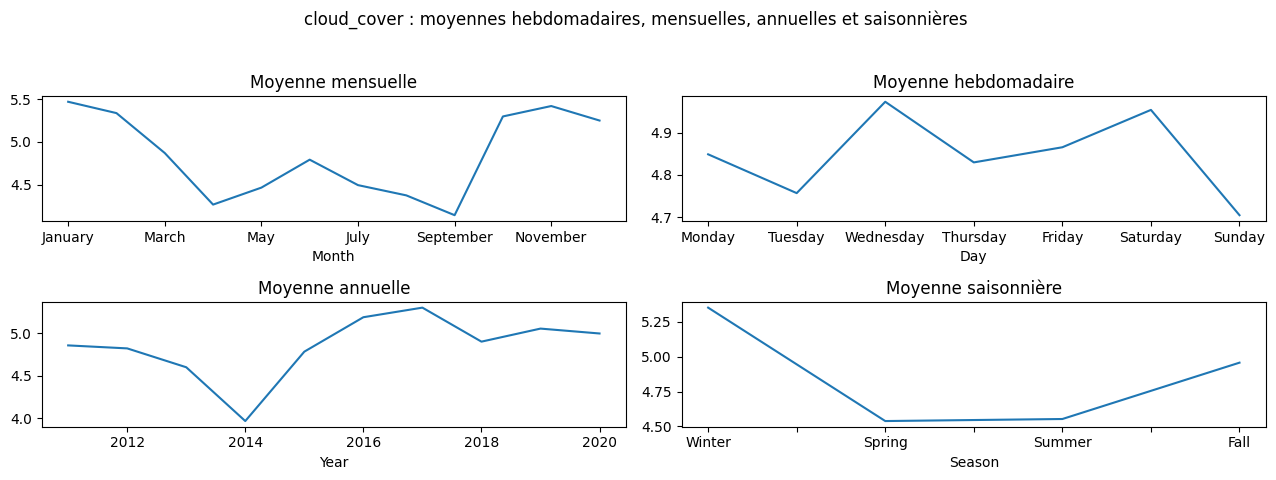

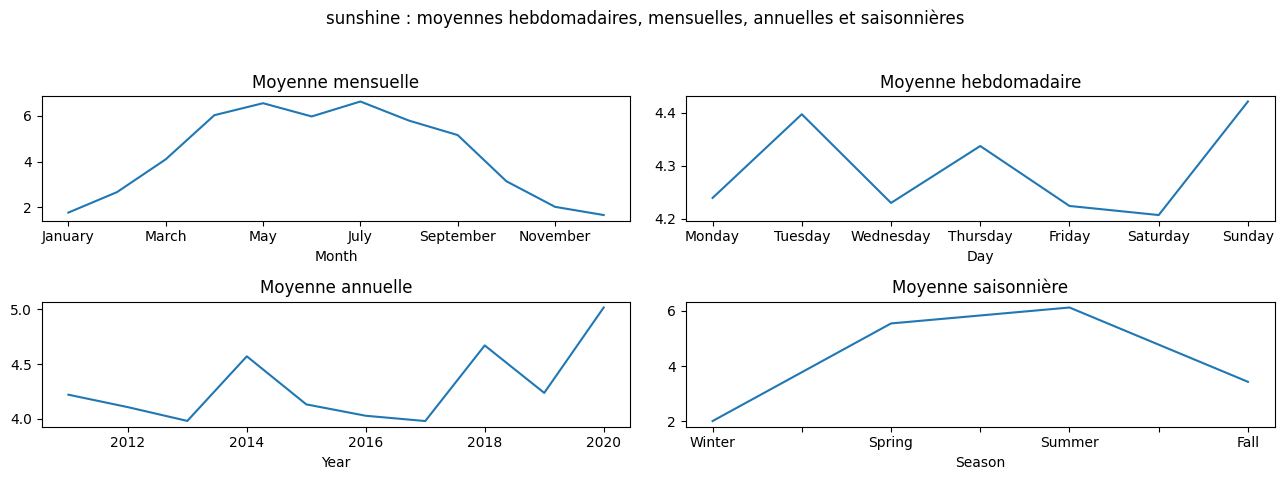

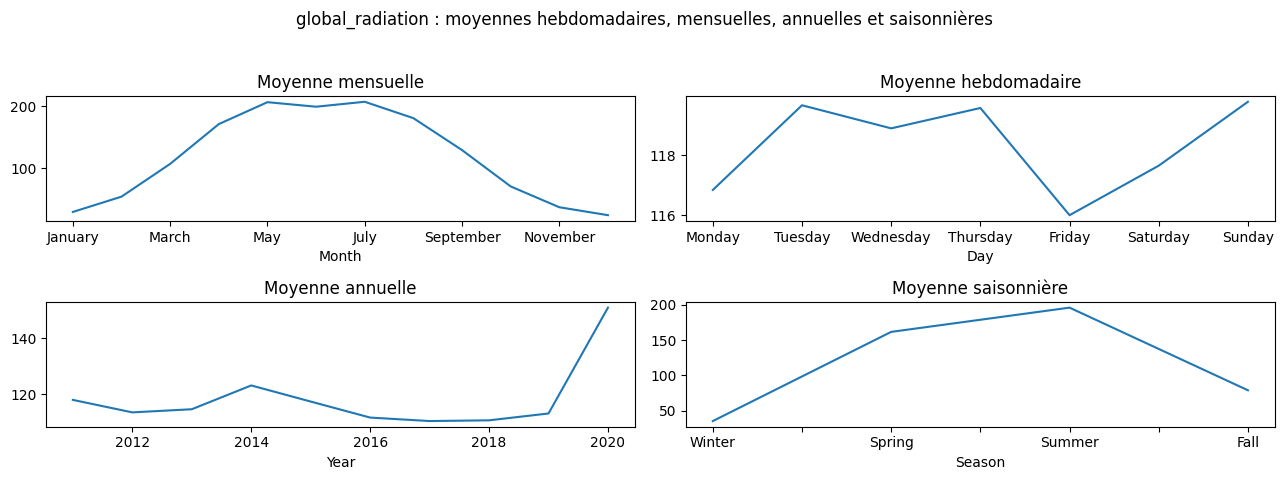

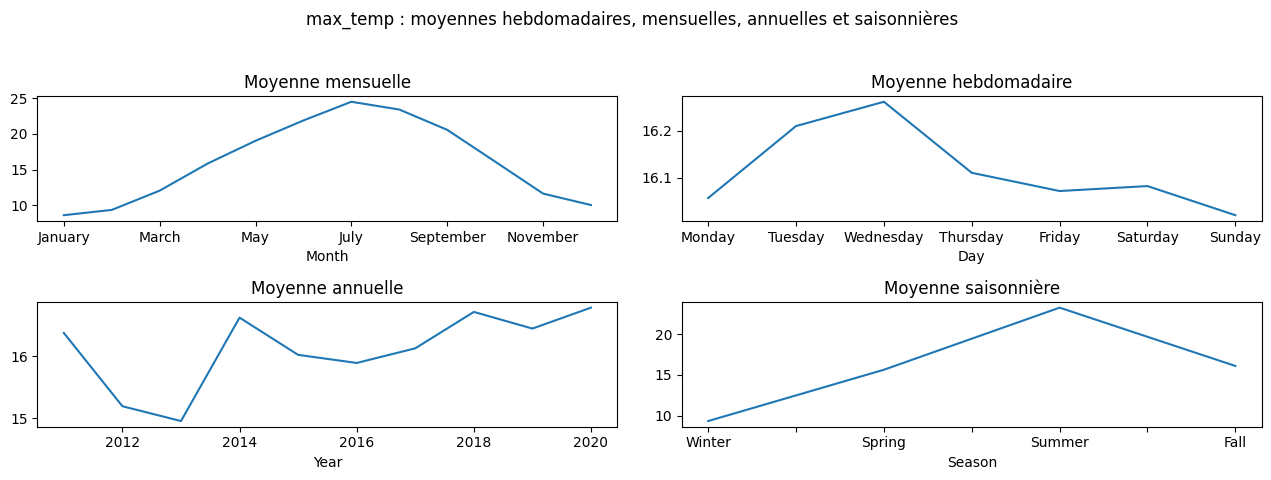

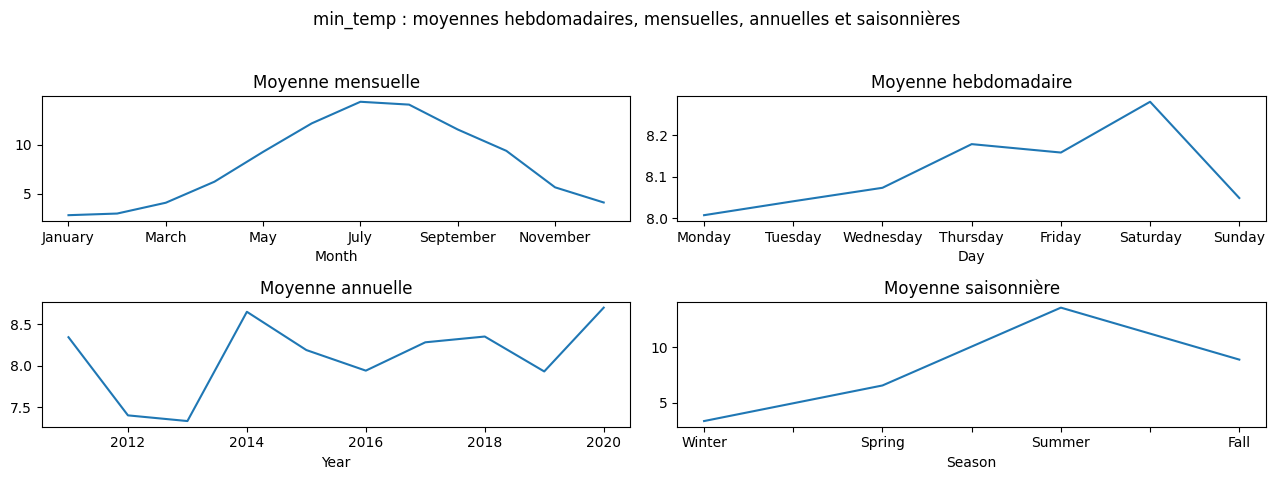

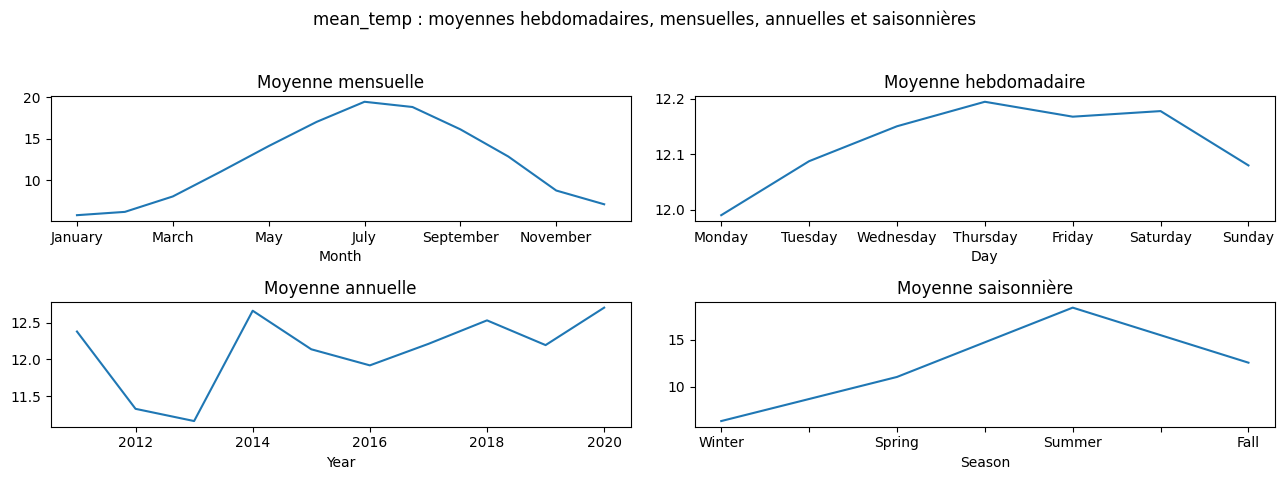

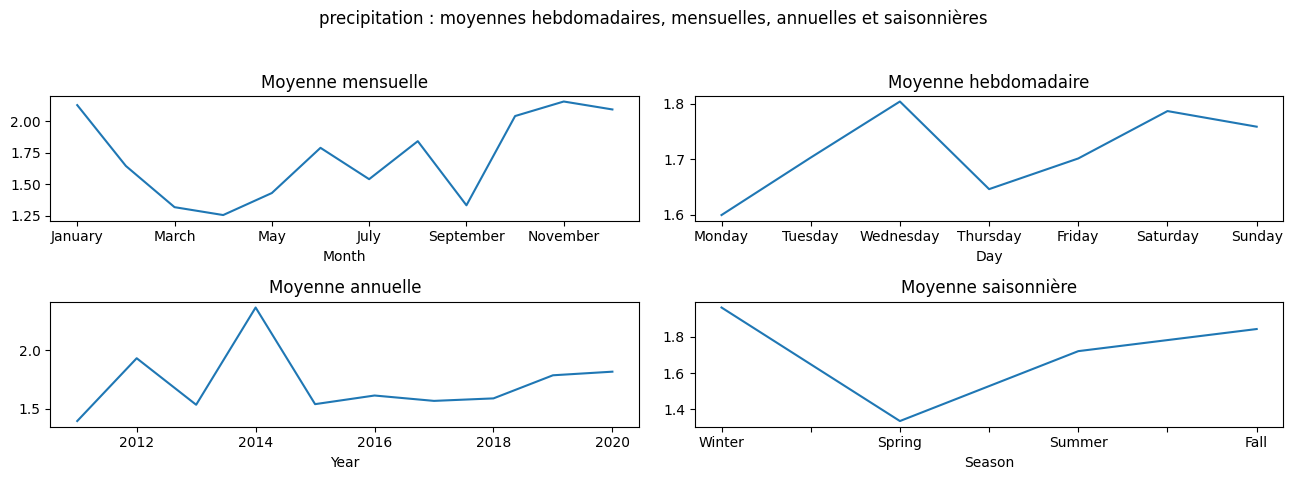

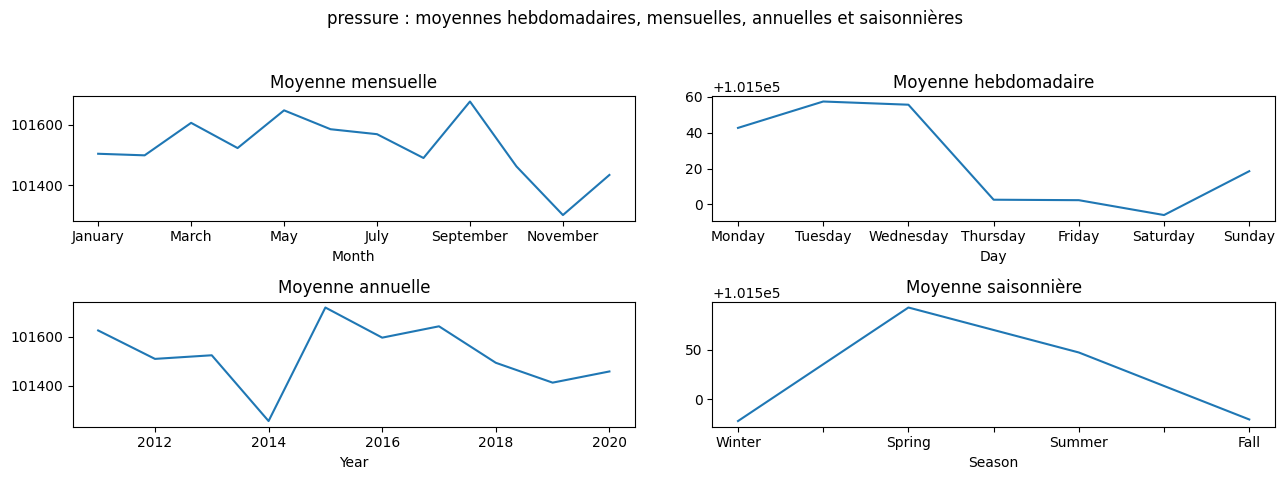

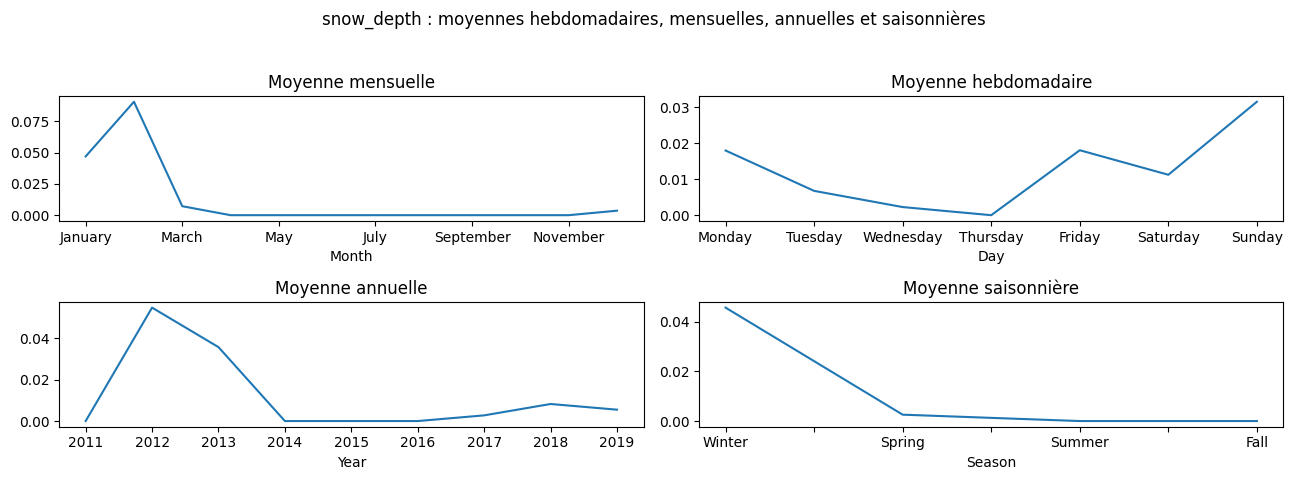

In [1381]:
df['Day'] = pd.Categorical(df['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Month'] = pd.Categorical(df['Month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
df['Season'] = pd.Categorical(df['Season'], categories=['Winter', 'Spring', 'Summer', 'Fall'], ordered=True)

cols = ["cloud_cover", "sunshine", "global_radiation", "max_temp", "min_temp", "mean_temp", "precipitation", "pressure", "snow_depth"]

for col in cols: 
    fig, axes = plt.subplots(2, 2, figsize=(13, 5))
    fig.suptitle(f'{col} : moyennes hebdomadaires, mensuelles, annuelles et saisonnières')
    
    df.groupby('Month', observed=False)[col].mean().plot(ax=axes[0,0])
    axes[0,0].set_title('Moyenne mensuelle')  
    
    df.groupby('Day', observed=False)[col].mean().plot(ax=axes[0,1])
    axes[0,1].set_title('Moyenne hebdomadaire')  
    
    df.groupby('Year', observed=False)[col].mean().plot(ax=axes[1,0])
    axes[1,0].set_title('Moyenne annuelle')
    
    df.groupby('Season', observed=False)[col].mean().plot(ax=axes[1,1])
    axes[1,1].set_title('Moyenne saisonnière')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

**Couverture nuageuse**

La couverture nuageuse comprend des fluctuations au cours de l'année et notamment des périodes avec plus de nuages particulièrement en hiver entre les mois de décembre et janvier. Notons également que l'on observe une chute de la couverture nuageuse en été. Aucune tendance n'est clairement observable annuellement. 

**Ensoleillement**

Il semble y avoir un pic d'ensoleillement en été par rapport aux autres saisons, mais le printemps reste tout de même une saison durant laquelle il y a beaucoup d'ensoleillement. Ce dernier est le moins présent de novembre à janvier et est le plus présent en mai et juin. Ici, le modèle n'est pas uniformément ascendant ou descendant et ne montre pas de tendance linéaire claire à la hausse ou à la baisse sur toute la période.

**Irradiation globale**

Les observations sont les mêmes que pour l'ensoleillement. Cela semble plutôt logique car l'irradiation globale est liée au à l'ensoleillement car elle mesure la quantité d'énergie solaire reçue par unité de surface. Ainsi, les variations de l'irradiation globale suivent généralement celles de l'ensoleillement.

**Température maximale**

La température maximale varie entre les saisons puisque les mois d'été montrent des températures maximales plus élevées que les autres mois et surtout les mois d'hiver, ce qui fait sens. Anuellement, nous observons qu'il y a une tendance à la hausse au fil du temps, ce qui pourrait correspondre au réchauffement climatique.    

**Température minimale & Température moyenne**

Les observations des températures minimales et moyennes suivent des schémas similaires à ceux de la température maximale. Malgré les variations saisonnières prévues, telles que des températures plus élevées en été et plus basses en hiver, une tendance générale à la hausse au fil des années est observée. Cette cohérence dans les données suggère une augmentation continue des températures, similaire à celle observée pour les températures maximales, ce qui pourrait être associé au réchauffement climatique.

**Précipitations**

Les précipitations sont particulièrement élevées en automne. De plus, c'est au printemps qu'il y a le moins de précipitations, ce qui peut parraitre étonnant car l'eau est nécessaire pour la floraison. 

**Pression**

Nous pouvons observer une pression basse en automne et en hiver. Par ailleurs, cette dernière est assez élevée en été et au printemps. Entre les années, aucun tendance nette n'est observable, on observe seulement une variabilité d'année en année. 

**Profondeur de la neige**

La neige est plus présente en hiver, en particulier en janvier et décembre. Nous pouvons également constaté que certaines années ont été marquées par d'importantes chutes de neige. C'est notamment le cas de l'hiver 2012-2013. 

**Remarque :** 

Les graphiques hebdomadaires ont été générés, seulement comme nous pouvons le voir il difficile d'en tirer des conclusions fiables sur des comportements météorologiques récurrents spécifiques à certains jours de la semaine. L'objectif étant de prédire la température moyenne à Londres, la météo est plus souvent influencée par des facteurs saisonniers et annuels qu'hebdomadaires. 

<span id="2.3."></span>

### 2.3. Etude de la saisonnalité

- Les données météorologiques historiques de Londres révèlent-elles des schémas de saisonnalité, des tendances sur le long terme et des événements météorologiques extrêmes ? Sur la base de ces données, que peut-on observer sur le climat et les conditions météorologiques à Londres ?

Text(0, 0.5, 'Température moyenne (en °C)')

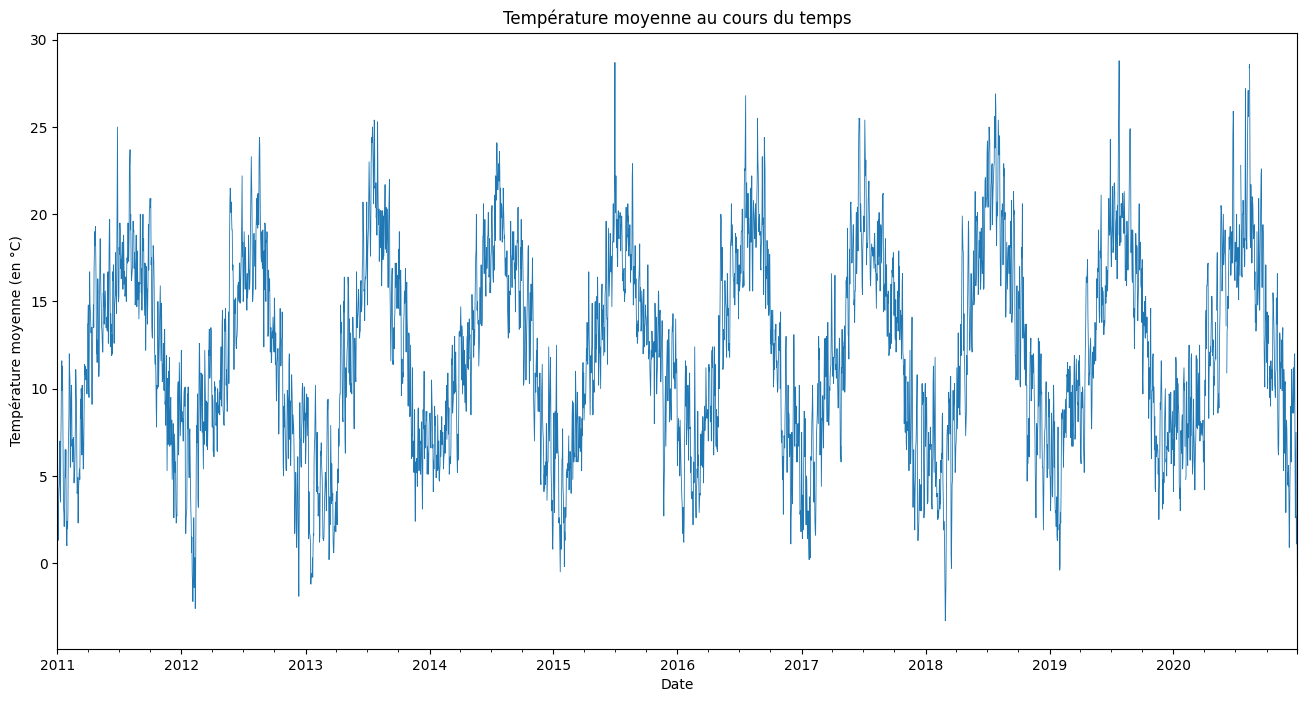

In [1382]:
plt.figure(figsize=(16, 8))
df['mean_temp'].plot(linewidth=0.6)
plt.title('Température moyenne au cours du temps')
plt.xlabel('Date')
plt.ylabel('Température moyenne (en °C)')

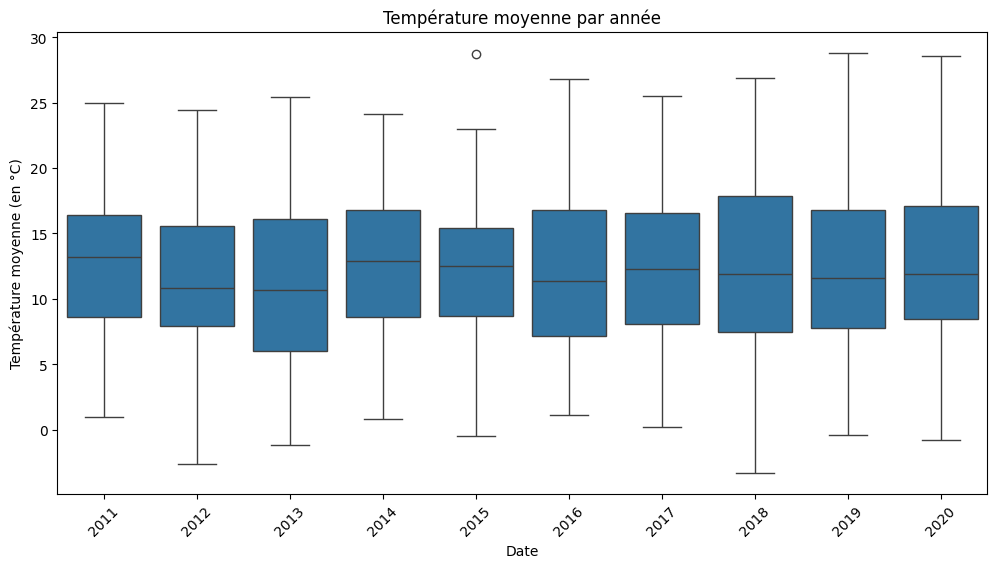

In [1383]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='mean_temp', data=df)
plt.xticks(rotation=45) 
plt.title('Température moyenne par année')
plt.xlabel('Date')
plt.ylabel('Température moyenne (en °C)')
plt.show()

In [1384]:
def plot_seasonal_decompose(result: DecomposeResult, title="Décomposition saisonnale"):
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.observed, mode="lines"),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.trend.index, y=result.trend, mode="lines"),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.seasonal, mode="lines"),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.resid.index, y=result.resid, mode="lines"),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=title, margin=dict(t=100), title_x=0.5, showlegend=False
        )
    )

In [1385]:
df = df.asfreq('D')
result = seasonal_decompose(df['mean_temp'].dropna(), model='additive', period=365)  
plot_seasonal_decompose(result, title="Seasonal Decomposition")

Nous pouvons noter une évolution saisonnière. En effet, nous remarquons des variations qui se produisent à des intervalles réguliers qui semblent correspondre aux différentes saisons dans l'année. Les pics semblent correspondre aux étés et les creux aux hivers. Il y a également des points extrèmes chaque année qui pourraient correspondre à des températures extrêmes élevées et basses. Le graphique avec les boxplots montre une variabilité d'année en année.

Par ailleurs, nous pouvons également noter une légère tendance à la hausse dans les données, c'est-à-dire une augmentation des températures au cours du temps. Cela pourrait ainsi correspondre au réchauffement climatique.

L'aspect saisonnier évoqué précédemment semnble être confirmé par la composante saisonière qui met en évidence une répétition claire des températures. Cela illustre le cycle annuel des saisons. 

De plus, nous pouvons également noter des comportements anormaux dans les données qui semblent correspondre à des évènements météorologiques particuliers ayant eu lieu au cours du temps. C'est notamment le cas des évènements suivants : 
- Printemps 2013 : une vague de froid a été observée au printemps 2013 au Royaume-Uni entre le 6 mars et le début du mois d'avril. Cette dernière s'est caractérisée par des températures très basses et d'importantes chutes de neige.
- Eté 2018 : nous pouvons observer d'importantes températures durant l'été 2018. En effet, le pays a connu une vague de chaleur avec des températures record et des épisodes canicule.

**Débruitage et lissage des données**

Pour la suite, nous avons choisi de réaliser un débruitage wavelet et un average smoothing sur nos données. Ces techniques nous permettent de filtrer les fluctuations à court terme qui peuvent masquer les tendances plus significatives dans les données. Le débruitage par ondelettes est particulièrement intéressant car il permet d'atténuer ou de supprimer le bruit tout en préservant les caractéristiques importantes telles que les discontinuités et les pics (pouvant signaler un évènement météorologique extrême). Quant à l'average smoothing, ce dernier fournit une courbe plus lisse qui rend les tendances générales plus visibles, rendant plus facile l'identification de cycles et les tendances dans les données. Ainsi, l'utilisation ces deux méthodes nous permet de maximiser nos chances de capturer les signaux importants et pertinents de nos données. 

In [1386]:
# Wavelet denoising
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1, signal_len=None):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:]]

    signal_reconstructed = pywt.waverec(coeff, wavelet, mode='per')

    if signal_len is not None:
        if len(signal_reconstructed) > signal_len:
            signal_reconstructed = signal_reconstructed[:signal_len]
        elif len(signal_reconstructed) < signal_len:
            signal_reconstructed = np.pad(signal_reconstructed, (0, signal_len - len(signal_reconstructed)), 'edge')
    else:
        signal_len = len(signal_reconstructed)

    return signal_reconstructed

columns = ["cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure", "snow_depth"]
for col in columns:
    df[f"{col}_wavelet"] = denoise_signal(df[col].dropna().values, signal_len=len(df['sunshine']))

In [1387]:
# Average smoothing
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    while start < len(signal):
        end = min(start + kernel_size, len(signal))
        sample.append(np.mean(signal[start:end]))
        start += stride

    if end < len(signal):
        sample.append(np.mean(signal[-kernel_size:]))  

    if len(sample) < len(signal):
        sample = np.concatenate([sample, np.full((len(signal) - len(sample)), np.nan)])
    else:
        sample = sample[:len(signal)]  

    return np.array(sample)

for col in columns:
    df[f"{col}_smooth"] = average_smoothing(df[col].values, kernel_size=5, stride=1)

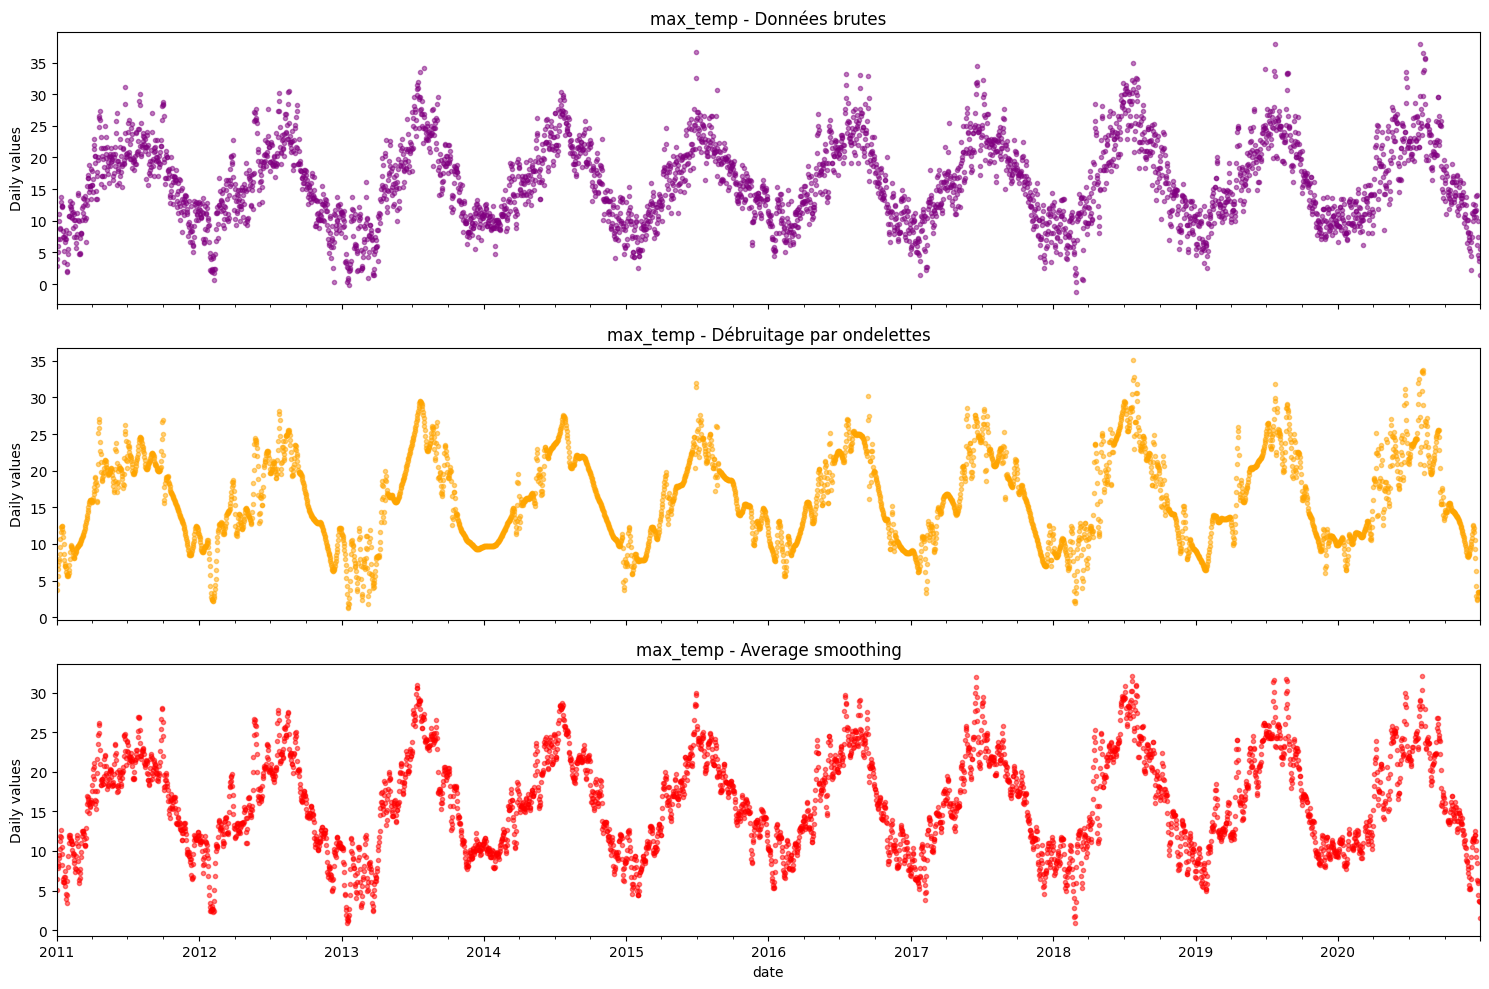

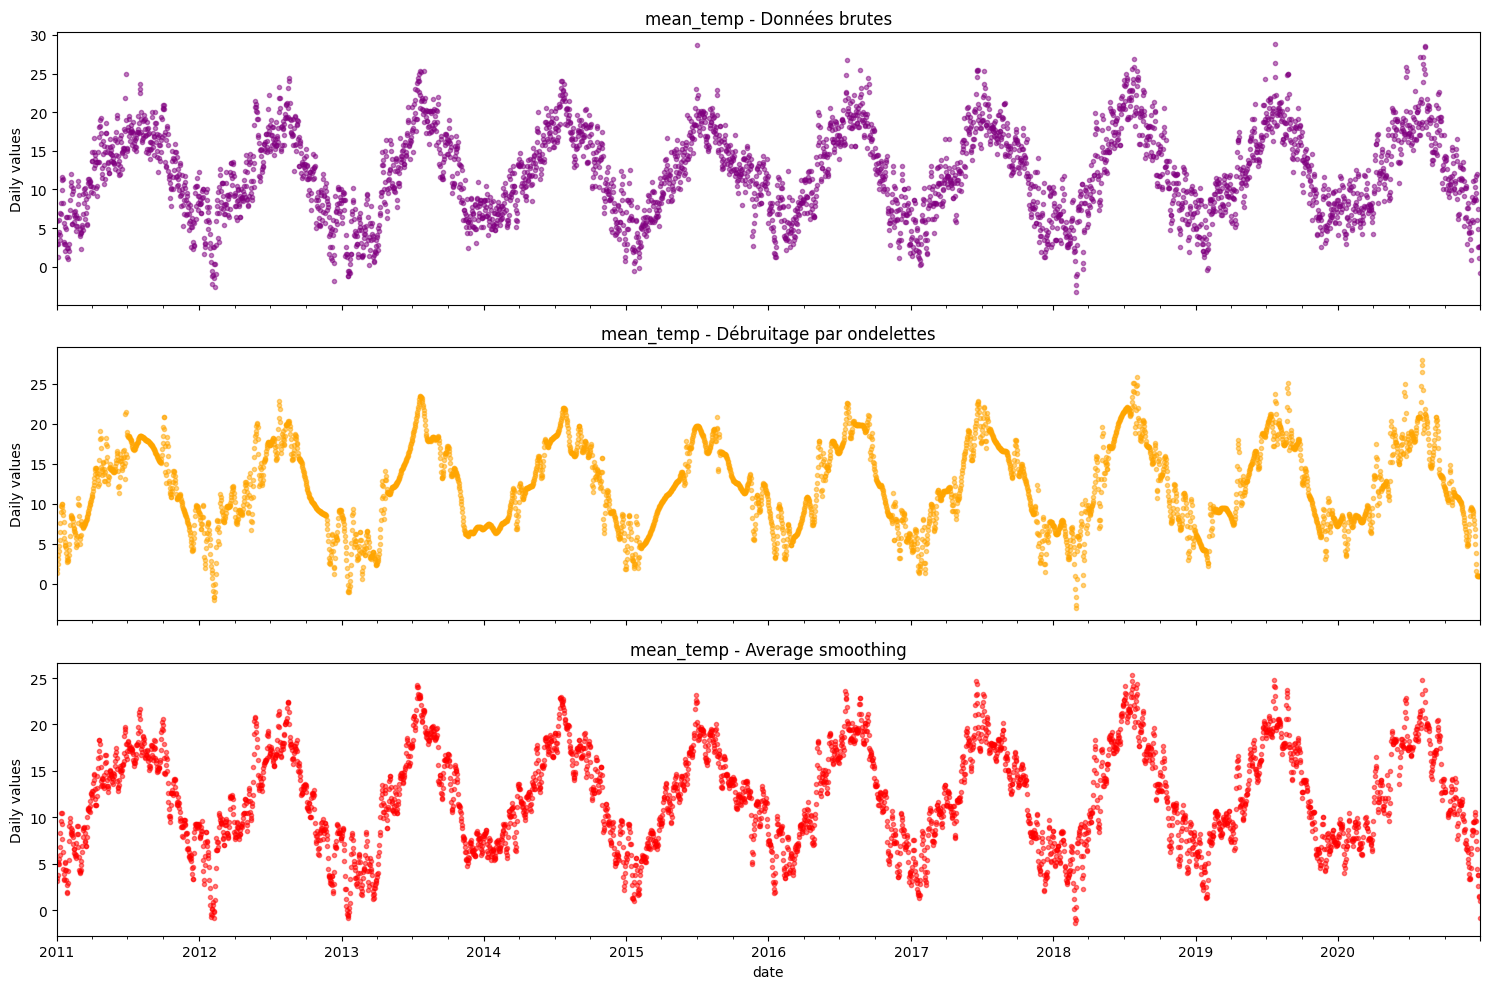

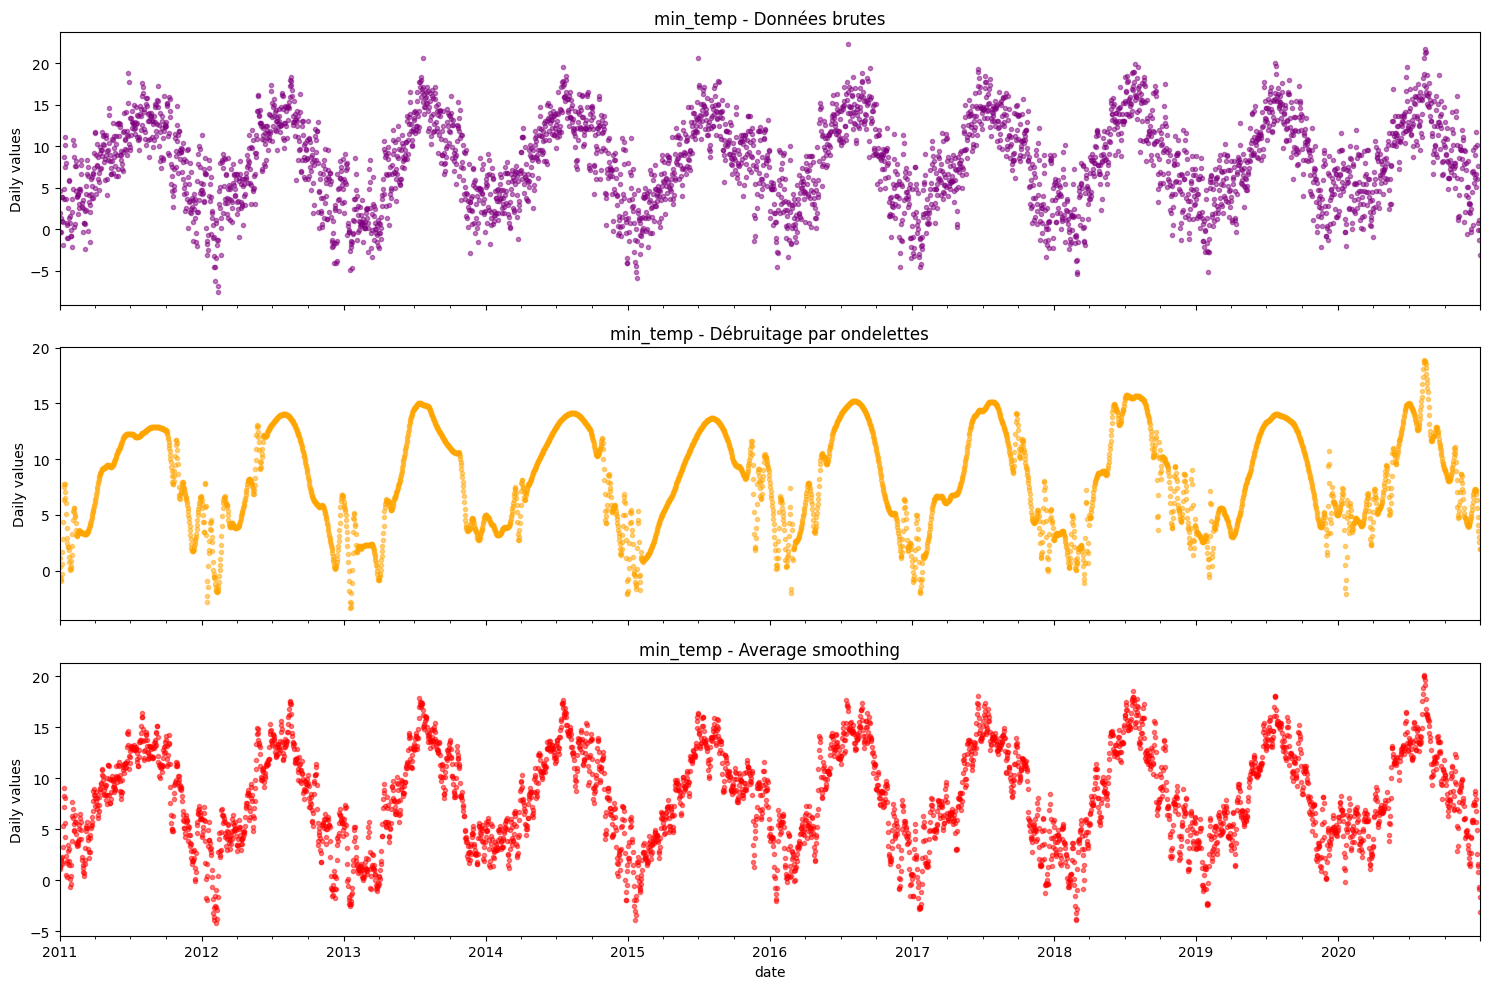

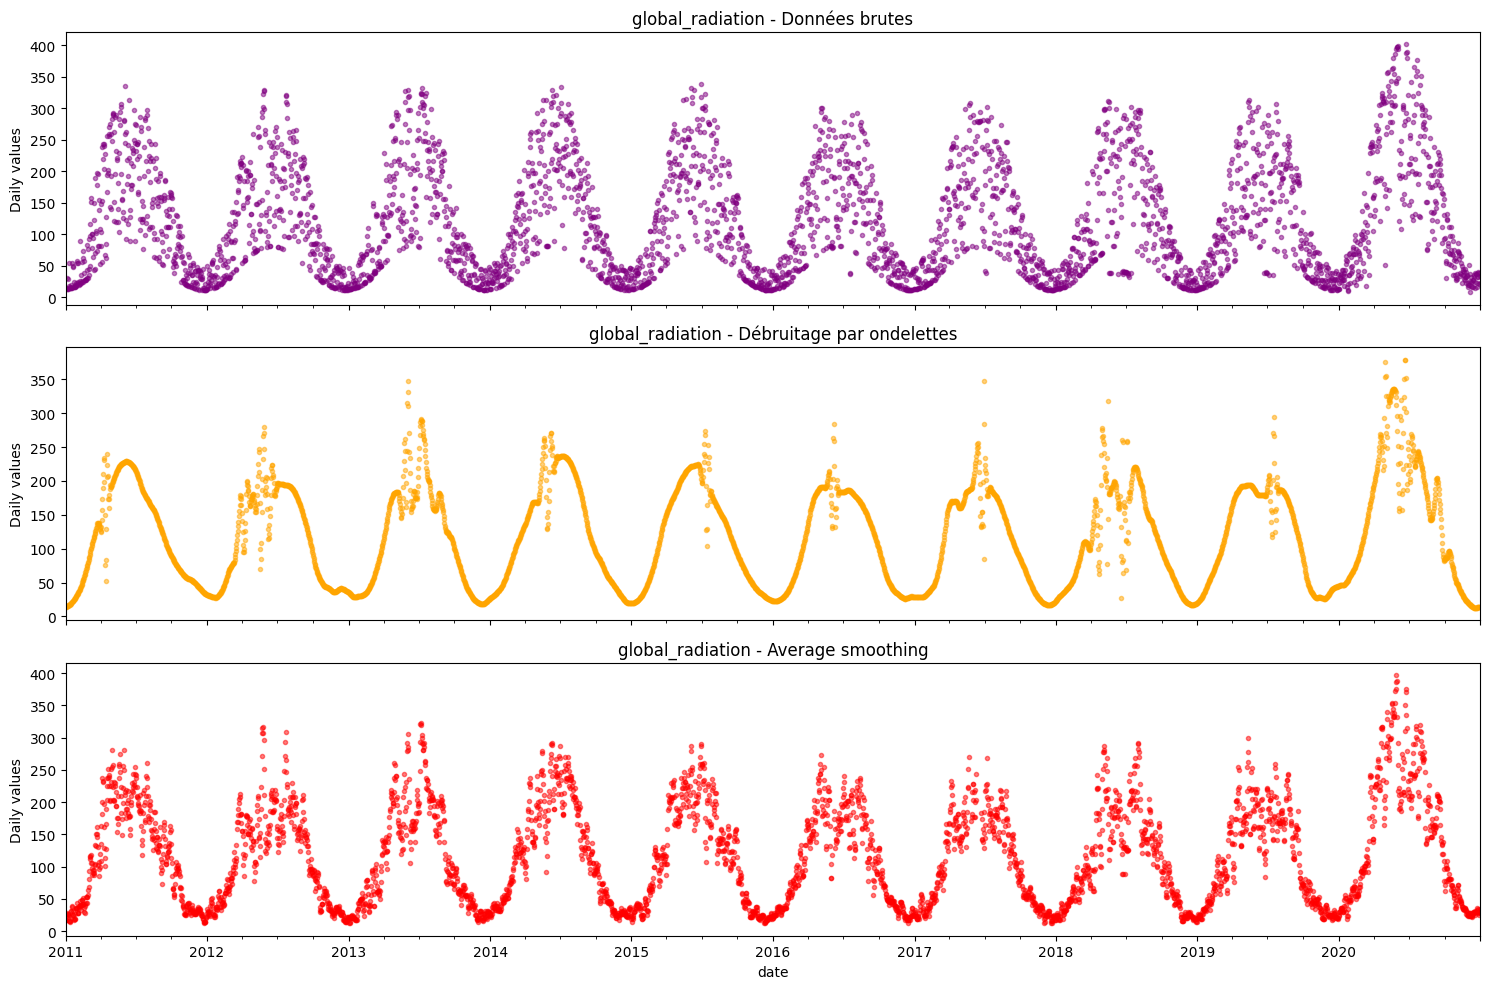

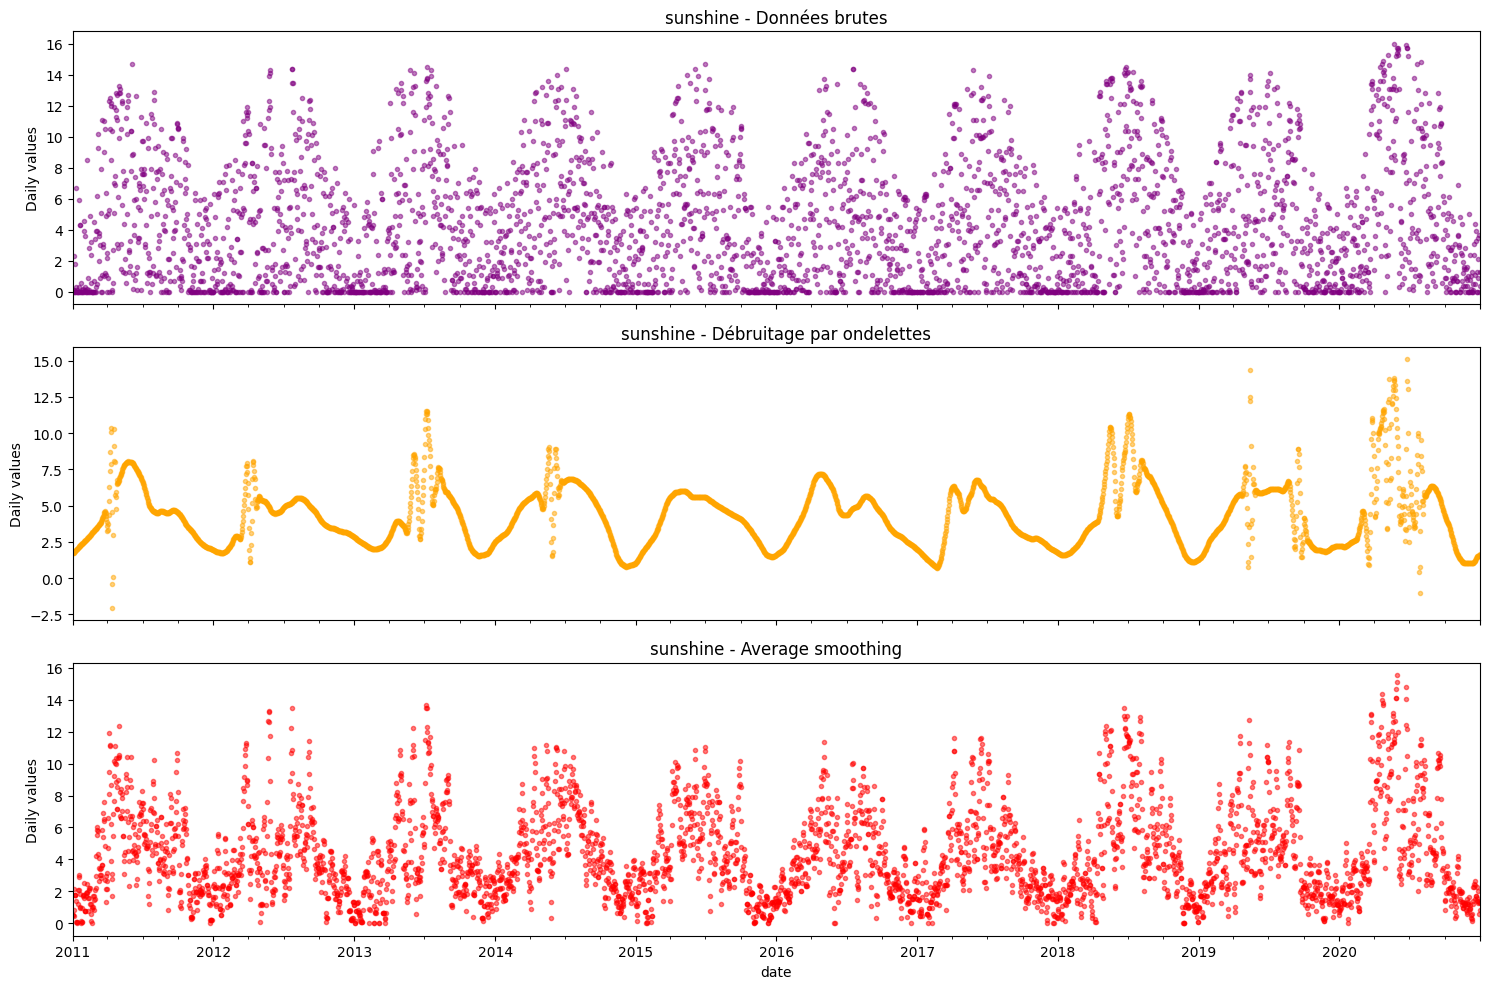

In [1388]:
columns = ['max_temp', 'mean_temp','min_temp', 'global_radiation', 'sunshine']

for col in columns:
    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    
    df[col].plot(ax=axes[0], marker='.', alpha=0.5, linestyle='None', color='purple')
    axes[0].set_title(f"{col} - Données brutes")
    axes[0].set_ylabel('Daily values')
    
    df[f"{col}_wavelet"].plot(ax=axes[1], marker='.', alpha=0.5, linestyle='None', color='orange')
    axes[1].set_title(f"{col} - Débruitage par ondelettes")
    axes[1].set_ylabel('Daily values')

    df[f"{col}_smooth"].plot(ax=axes[2], marker='.', alpha=0.5, linestyle='None', color='red')
    axes[2].set_title(f"{col} - Average smoothing")
    axes[2].set_ylabel('Daily values')
    
    plt.tight_layout()
    plt.show()

Nous observons une saisonnalité pour les quatre variables représentées ci-dessus. Les pics saisonniers sont réguliers avec des températures élevées l'été et basses l'hiver. Cela concerne également l'irradiation globale du soleil où l'on observe des pics élevés l'été, c'est-à-dire que l'on a une plus forte émission de radiations solaires. A l'inverse, en hiver, ces rayonnements semblent moins importants. Il en est de même pour l'ensoleillement. Notons que la saisonnalité de l'ensoleillement est due à l'axe de rotation de la Terre et à son orbite autour du soleil, ce qui explique que dans des zones tempérées comme Londres, le rayonnement solaire est plus important en été par exemple.

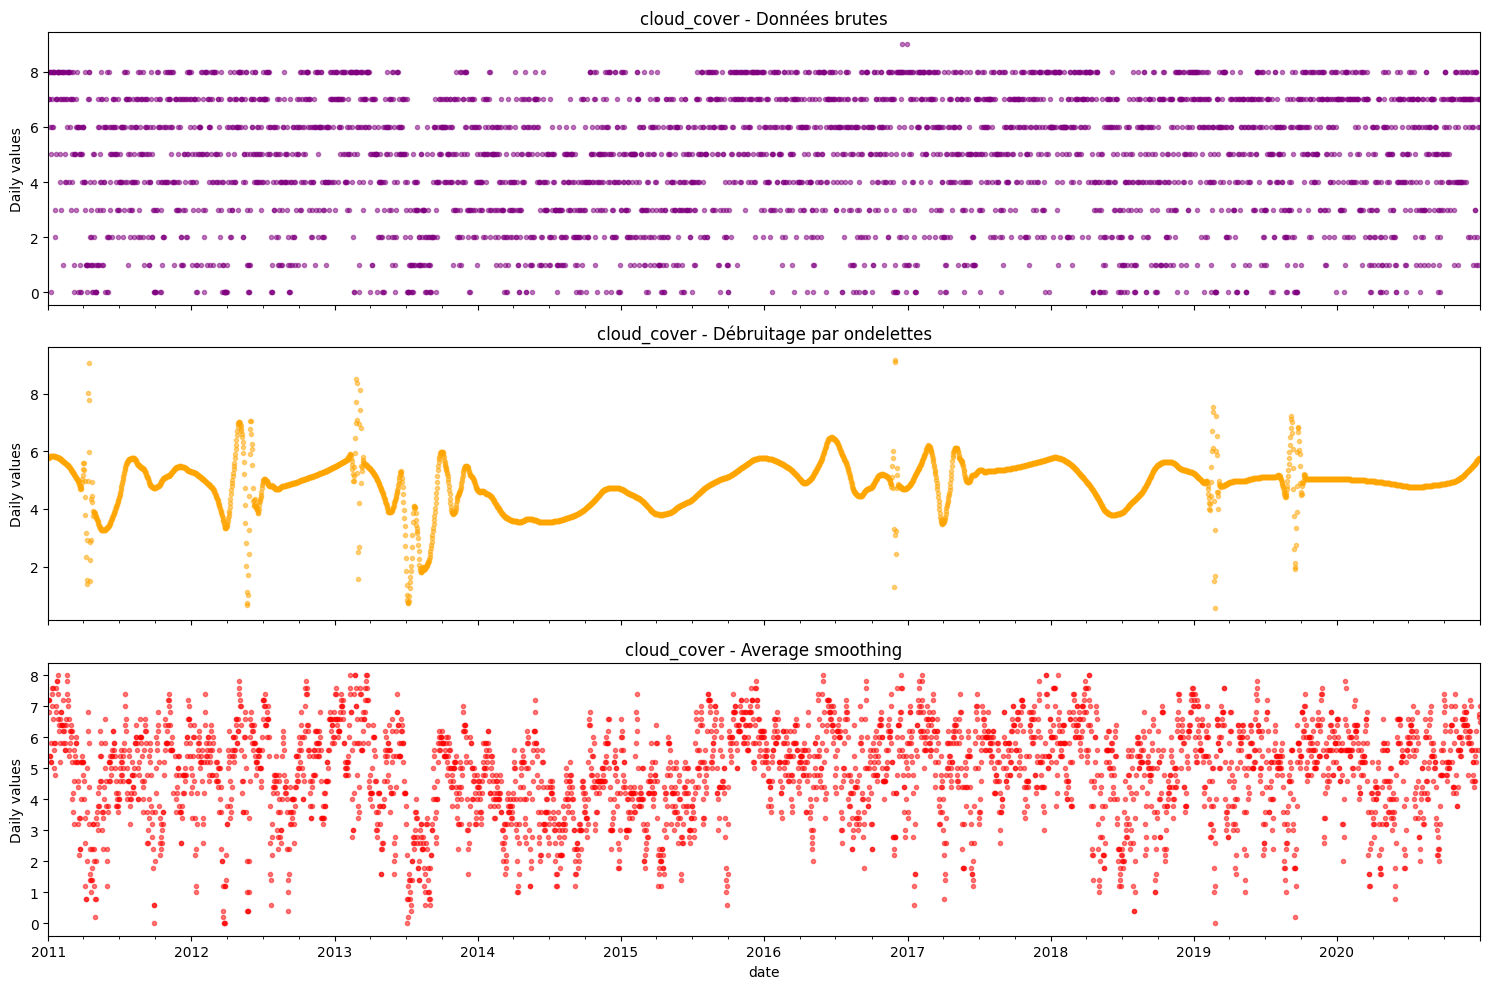

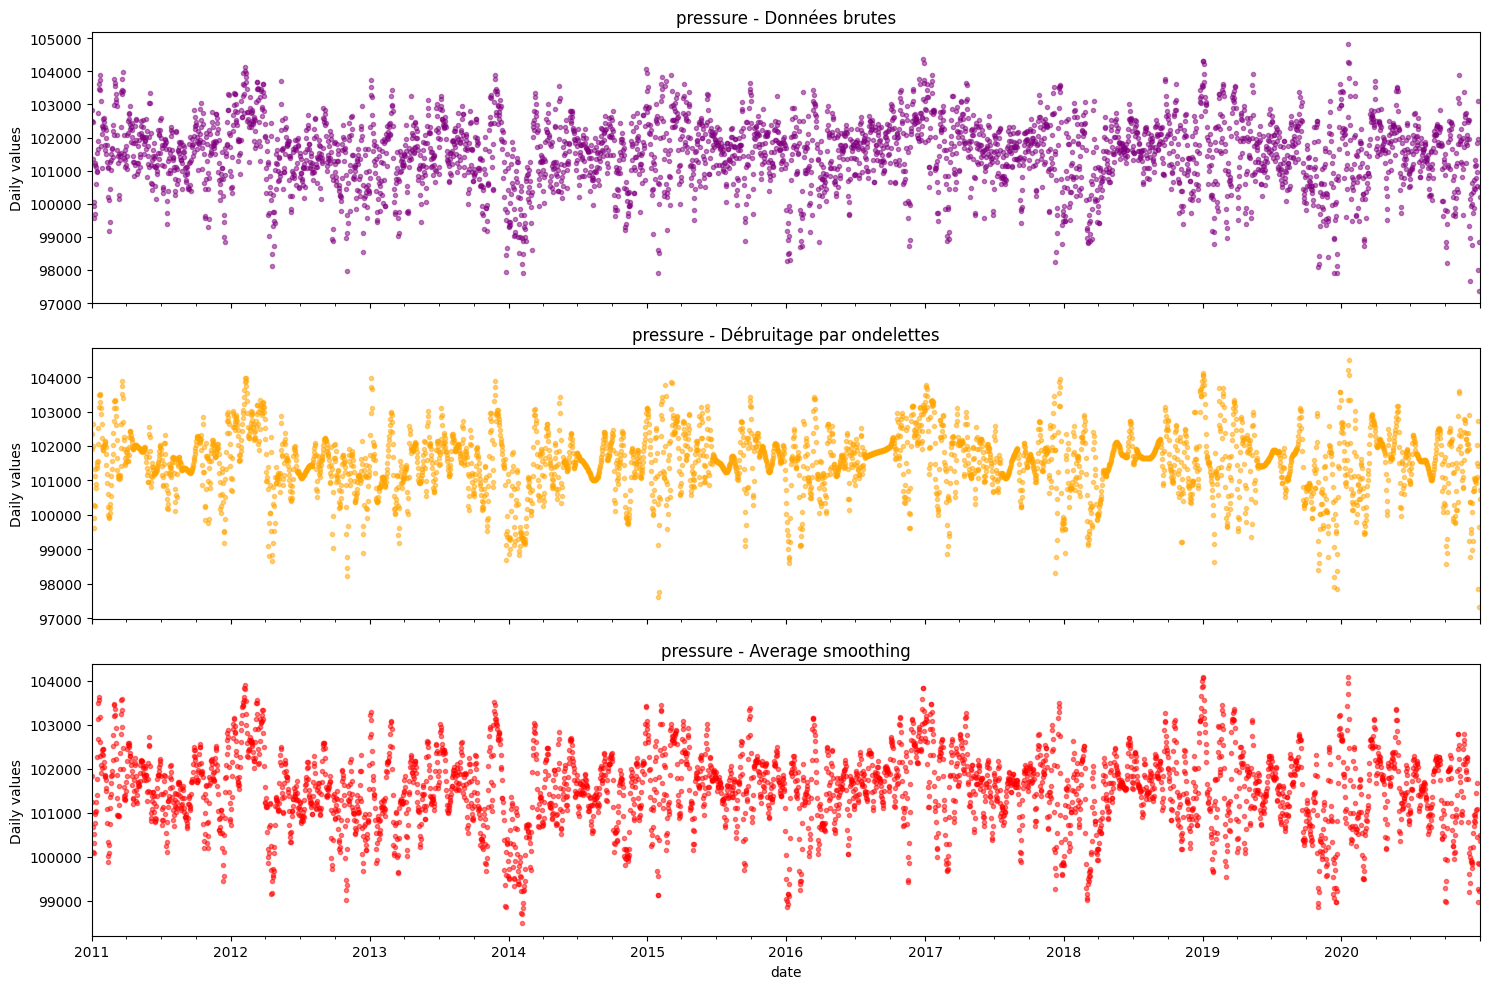

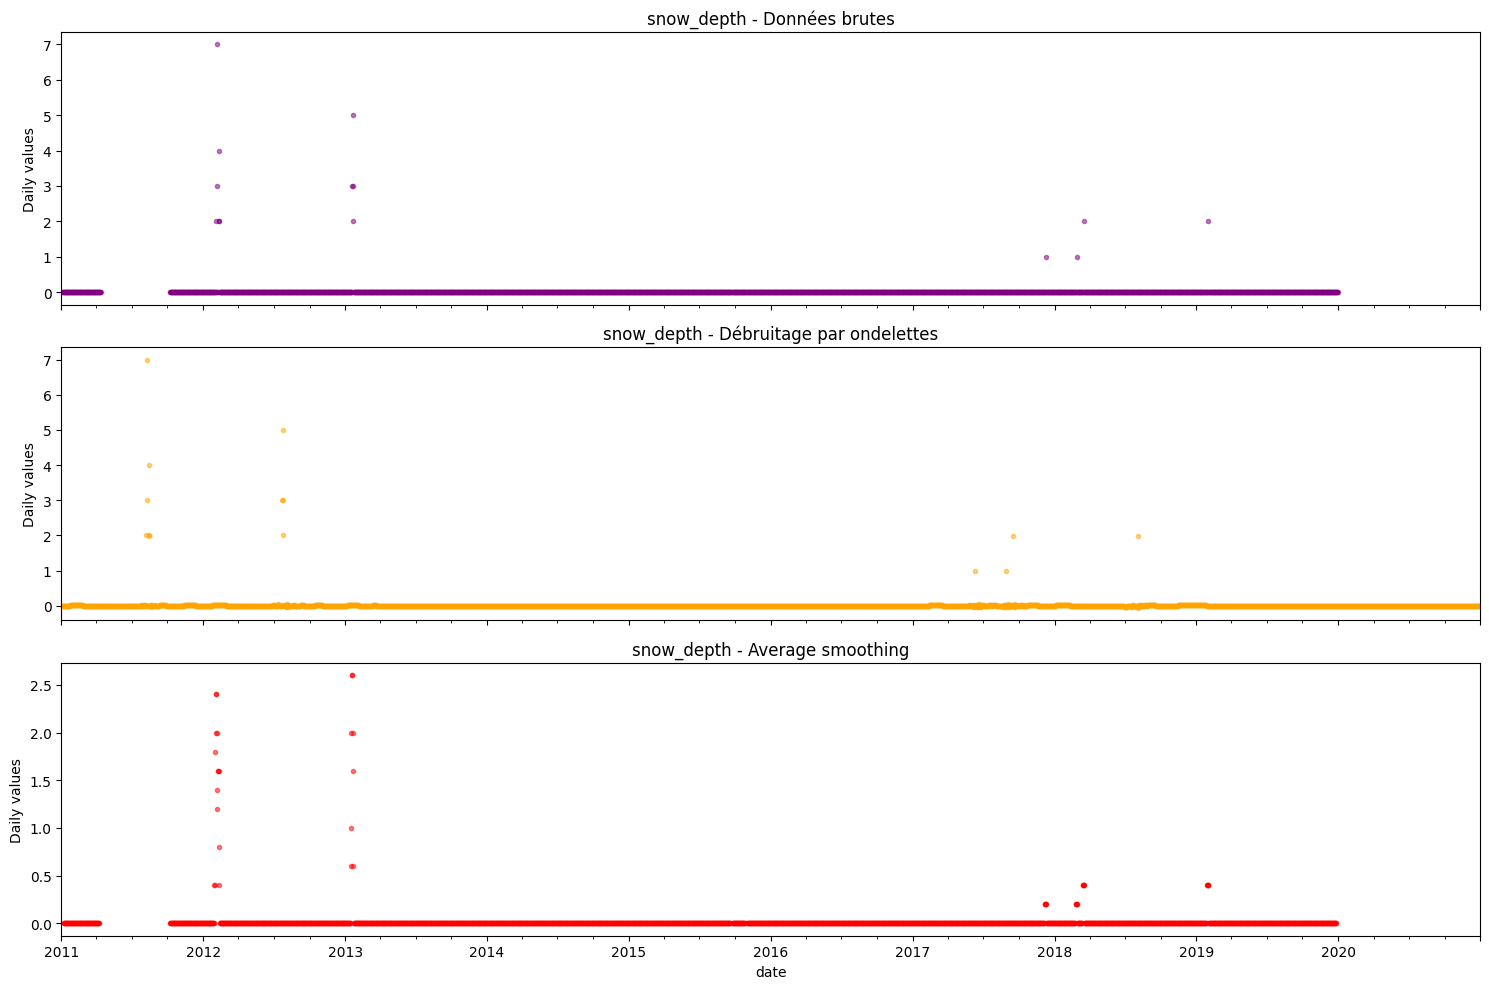

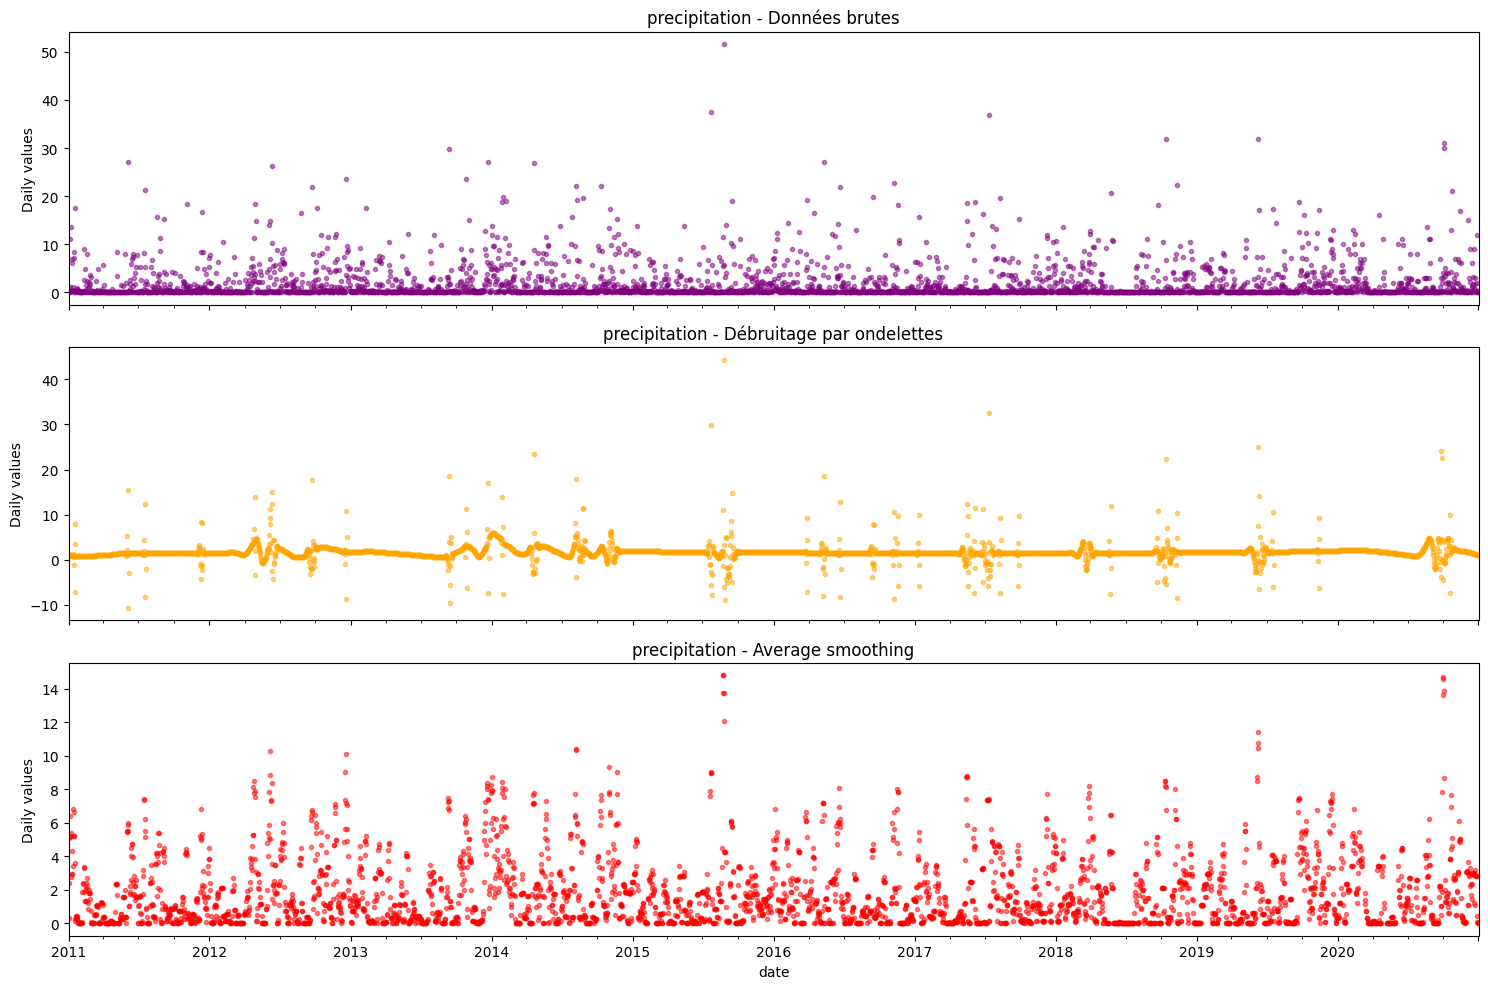

In [1389]:
columns = ['cloud_cover', 'pressure', 'snow_depth', 'precipitation'] 

for col in columns:
    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    
    df[col].plot(ax=axes[0], marker='.', alpha=0.5, linestyle='None', color='purple')
    axes[0].set_title(f"{col} - Données brutes")
    axes[0].set_ylabel('Daily values')
    
    df[f"{col}_wavelet"].plot(ax=axes[1], marker='.', alpha=0.5, linestyle='None', color='orange')
    axes[1].set_title(f"{col} - Débruitage par ondelettes")
    axes[1].set_ylabel('Daily values')

    df[f"{col}_smooth"].plot(ax=axes[2], marker='.', alpha=0.5, linestyle='None', color='red')
    axes[2].set_title(f"{col} - Average smoothing")
    axes[2].set_ylabel('Daily values')
    
    plt.tight_layout()
    plt.show()

In [1390]:
# Suppresion des variables débruitées
columns = ["cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure", "snow_depth"]
columns_to_drop = []

for col in columns:
    columns_to_drop.append(f"{col}_wavelet")
    columns_to_drop.append(f"{col}_smooth")

df.drop(columns=columns_to_drop, inplace=True)

Concernant les quatre variables ci-dessus, nous ne notons pas de saisonnalité visible à l'oeil nu. Cela est finalement peu surprenant pour des variables comme la pression atmosphérique et les précipitations car Londres est réputée pour être une ville très pluvieuse, on ne peut donc pas considérer qu'il a tendance à beaucoup pleuvoir en hiver et peu en été. De plus, la pression atmospéhique étant liée à la pluie, effectivement on observe une pression basse lorsque le temps est à la pluie, il n'est pas étonnant de ne pas observer de saisonnalité. Ces phénomènes ne sont pas strictement saisonniers et peuvent survenir à tout moment de l'année. Il en est de même pour la couverture nuageuse. 
Enfin, l'absence de saisonnalité pour la profondeur de la neige est également peu étonnante, car les chutes de neige sont assez rares. Ainsi, il est probable que la neige ne s'accumule pas suffisamment pour qu'une tendance saisonnière soit clairement observable dans les données. 

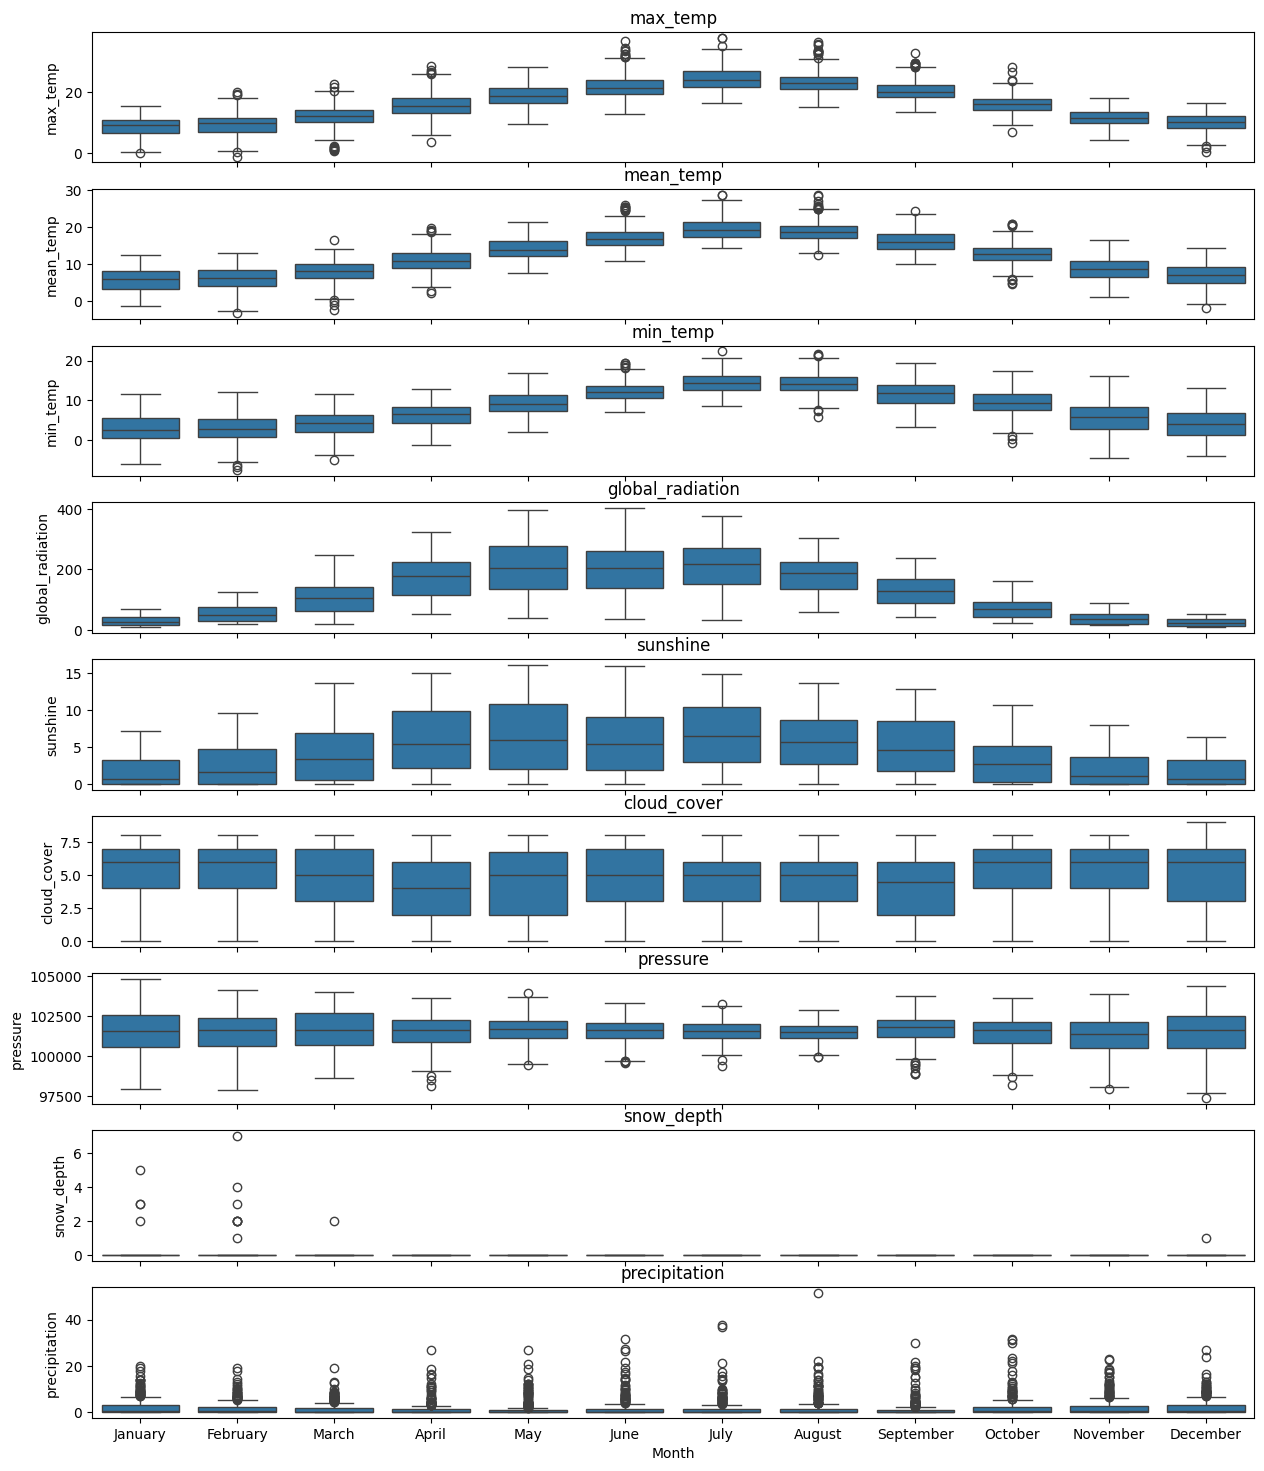

In [1391]:
fig, axes = plt.subplots(9, 1, figsize=(15, 18), sharex=True)
for name, ax in zip(['max_temp', 'mean_temp','min_temp', 'global_radiation', 'sunshine','cloud_cover', 'pressure', 'snow_depth', 'precipitation'], axes):
    sns.boxplot(data=df, x='Month', y=name, ax=ax)
    ax.set_title(name)

Ces différents box-plots confirment nos intuitions précédentes. En effet, nous observons une saisonnalité pour la température moyenne, minimale et maximale ainsi que l'irradiation globale et l'ensoleillement. En effet, ces mesures semblent plus élevés en été et plus faibles en hiver. Par ailleurs, pour les autres variables, la saisonnalité n'est toujours pas observée. 

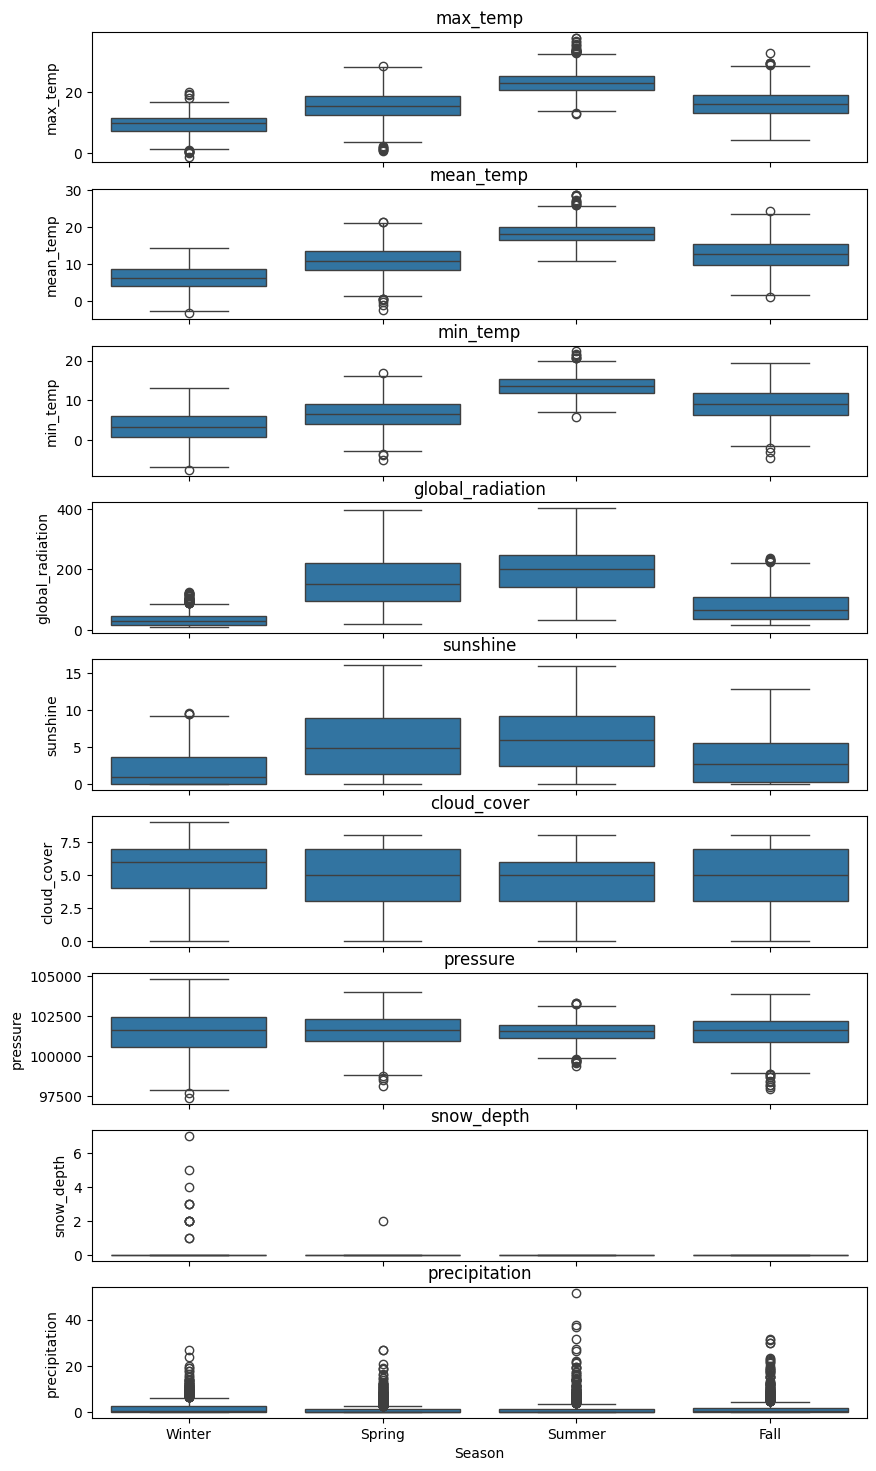

In [1392]:
fig, axes = plt.subplots(9, 1, figsize=(10, 18), sharex=True)
for name, ax in zip(['max_temp', 'mean_temp','min_temp', 'global_radiation', 'sunshine','cloud_cover', 'pressure', 'snow_depth', 'precipitation'], axes):
    sns.boxplot(data=df, x='Season', y=name, ax=ax)
    ax.set_title(name)

Nous pouvons voir qu'il semble y avoir des tendances saisonnières avec des températures plus élevées en été et des températures plus basses en hiver. Cela correspond typiquement à des schémas climatiques que l'on retrouve dans des régions tempérées comme Londres. Il en va de même pour l'ensoleillement et l'irradiation qui suivent la même logique. 

Concernant la couverture nuageuse et la pression, ces dernières semblent stables entre les saisons et ne présentent pas de tendance saisonnière.

L'épaisseur de la neige est quant à elle plus élevée en hiver, et peut présenter des valeurs élevées qui correspondent à de fortes chutes de neige. 

<span id="3."></span>

## 3. Data cleaning et data imputation

<span id="3.1."></span>

### 3.1. Présence de valeurs manquantes

In [1393]:
def calculate_na(df : pd.DataFrame) -> pd.DataFrame:
    """
    Calcule le pourcentage de valeurs manquantes pour chaque variable dans un DataFrame Pandas.

    Args:
        df (pd.DataFrame): Le DataFrame pour lequel calculer les pourcentages.

    Returns:
        pd.DataFrame : Un DataFrame contenant les pourcentages de valeurs manquantes pour chaque variable.
    """
    calculate_na = (df.isna().sum() / len(df)) * 100
    return calculate_na.sort_values(ascending=False)

In [1394]:
calculate_na(df)

snow_depth          15.001369
mean_temp            0.191623
global_radiation     0.164249
max_temp             0.164249
precipitation        0.164249
cloud_cover          0.082124
min_temp             0.054750
sunshine             0.000000
pressure             0.000000
Year                 0.000000
Month                0.000000
Day                  0.000000
Season               0.000000
dtype: float64

<span id="3.2."></span>

### 3.2. Imputation par Foward fill

Nous allons effectuer une imputation par Forward fill pour les variables avec un faible pourcentage de valeurs manquantes. Cela concerne, "mean_temp", "cloud_cover", "global_radiation", "max_temp", "precipitation", "pressure" et "min_temp". Cette méthode semble particulièrement adaptée ici car ces variables sont susceptibles de présenter une certaine continuité jour après jour. En effet, entre deux jours consécutifs, il y a peu de chances que les conditions météorologiques changent  brutalement, elles présentent une certaine stabilité, sauf évènement particulier. Par ailleurs, cette méthode d'imputation permet de préserver les tendances et les saisonnalités observées précédemment. 

In [1395]:
def forward_fill_imputation(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Impute les valeurs manquantes des variables spécifiées en entrée par la méthode du Forward Fill.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données à imputer.
        columns (list): Liste des colonnes sur lesquelles appliquer l'imputation par Forward Fill.

    Returns:
        pd.DataFrame: Le DataFrame avec les valeurs manquantes des colonnes spécifiées imputées par Forward Fill.
    """
    impute_columns = [col for col in columns if col in df.columns]

    for col in impute_columns:
        df[col] = df[col].ffill()
    
    return df

In [1396]:
df = forward_fill_imputation(df, ["mean_temp", "cloud_cover", "global_radiation", "max_temp", "precipitation", "pressure", "min_temp"])

<span id="3.3."></span>

### 3.3. Imputation par MICE

Pour la variable "snow_depth", nous avons choisi une imputation par Multiple Imputation by Chained Equations (MICE), car cette variable comporte un taux élevé de valeurs manquantes par rapport aux autres variables. De plus, nous préférons une méthode plus sophistiquée qui tient compte des relations entre les variables. En effet, la neige pouvant être influencée par différents facteurs, cette méthode semble adaptée alors qu'un Forward fill pourrait rendre l'imputation basée sur la simple continuité temporelle moins fiable dans le cas de la neige. 

In [1397]:
def mice_imputation(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Impute les valeurs manquantes des variables spécifiées en entrée par la méthode MICE.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données à imputer.
        columns (list): Liste des colonnes sur lesquelles appliquer l'imputation par MICE.

    Returns:
        pd.DataFrame: Le DataFrame avec les valeurs manquantes des colonnes spécifiées imputées par MICE.
    """
    imputer = IterativeImputer(max_iter=10, random_state=0)

    impute_columns = [col for col in columns if col in df.columns]
    
    df[impute_columns] = imputer.fit_transform(df[impute_columns])
    
    return df

In [1398]:
df = mice_imputation(df, ["snow_depth"])

<span id="4."></span>

## 4. Feature engineering

Dans cette partie, l'objectif est de créer des variables supplémentaires ou de transformer les variables existantes afin de mieux représenter les caractéristiques pertinentes des données pour la modélisation ultérieure. 

<span id="4.4."></span>

### 4.1. Features "métier"

Dans cette partie, nous ajoutons des variables "métier" qui sont spécifiques au domaine, telles que le diurnal air, le risque de gel, ou encore des indicateurs d'évènements spécifiques. De plus, nous créons une variable linéaire pour capturer la tendance climatique, car l'EDA a montré une tendance à la hausse pour les températures au fil du temps.

In [1399]:
# Diurnal air temperature variation
df['diurnal_air'] = df['max_temp'] - df['min_temp']

# Risque de gel
df['frost_risk'] = (df['min_temp'] <= 0).astype(int)

# Indicateurs pour des événements spécifiques
df['cold_wave_spring_2013'] = ((df.index >= '2013-03-06') & (df.index <= '2013-04-01')).astype(int)
df['heat_wave_summer_2018'] = ((df.index >= '2018-06-01') & (df.index <= '2018-09-01')).astype(int)

# Variable linéaire pour capturer la tendance climatique (l'EDA a montré une tendance à la hausse pour les températures)
df['time'] = df.index.year - df.index.year.min()

<span id="4.2."></span>

### 4.2. Features cycliques

Nous choisissons également d'intégrer des features cycliques car cela permet au modèle d'intégrer le fait que le jour 1 qui correpond au 1er janvier est proche du jour 365, qui correspond au 31 décembre, les deux étant proches, ils ont potentiellement des caractéristiques météorologiques similaires. Cela l'aide donc à mieux généraliser surtout en présence de données saisonnière. Ainsi, de cette façon en représentant les jours de l'année de façon circulaire, nous pouvons capturer les caractériques saisonnières des données. 

In [1400]:
df['day_of_year'] = df.index.dayofyear
df['sin_day_of_year'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['cos_day_of_year'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

<span id="4.2."></span>

### 4.3. Features retardées

Dans cette partie, nous allons introduire des lags à nos variables afin de mieux capturer les relations temporelles et les dépendances qui pourraient exister entre les observations passées et les valeurs futures. Ces lags ont été déterminés sur la base de notre EDA précédente qui nous a permis d'identifier les comportements saisonniers et les tendances récurrentes dans les variables.  

Nous utilisons également des plots d'autocorrélation pour nous aider à déterminer les différents lags que nous souhaitons créer. Néanmoins, il s'agit seulement d'une indication générale car dans un cadre météorologique comme nous avons ici, les phénomènes météorologiques sont souvent saisonniers et influencés par des cycles plus longs et plus complexes que ce que l'autocorrélation sur de courts intervalles peut montrer. 

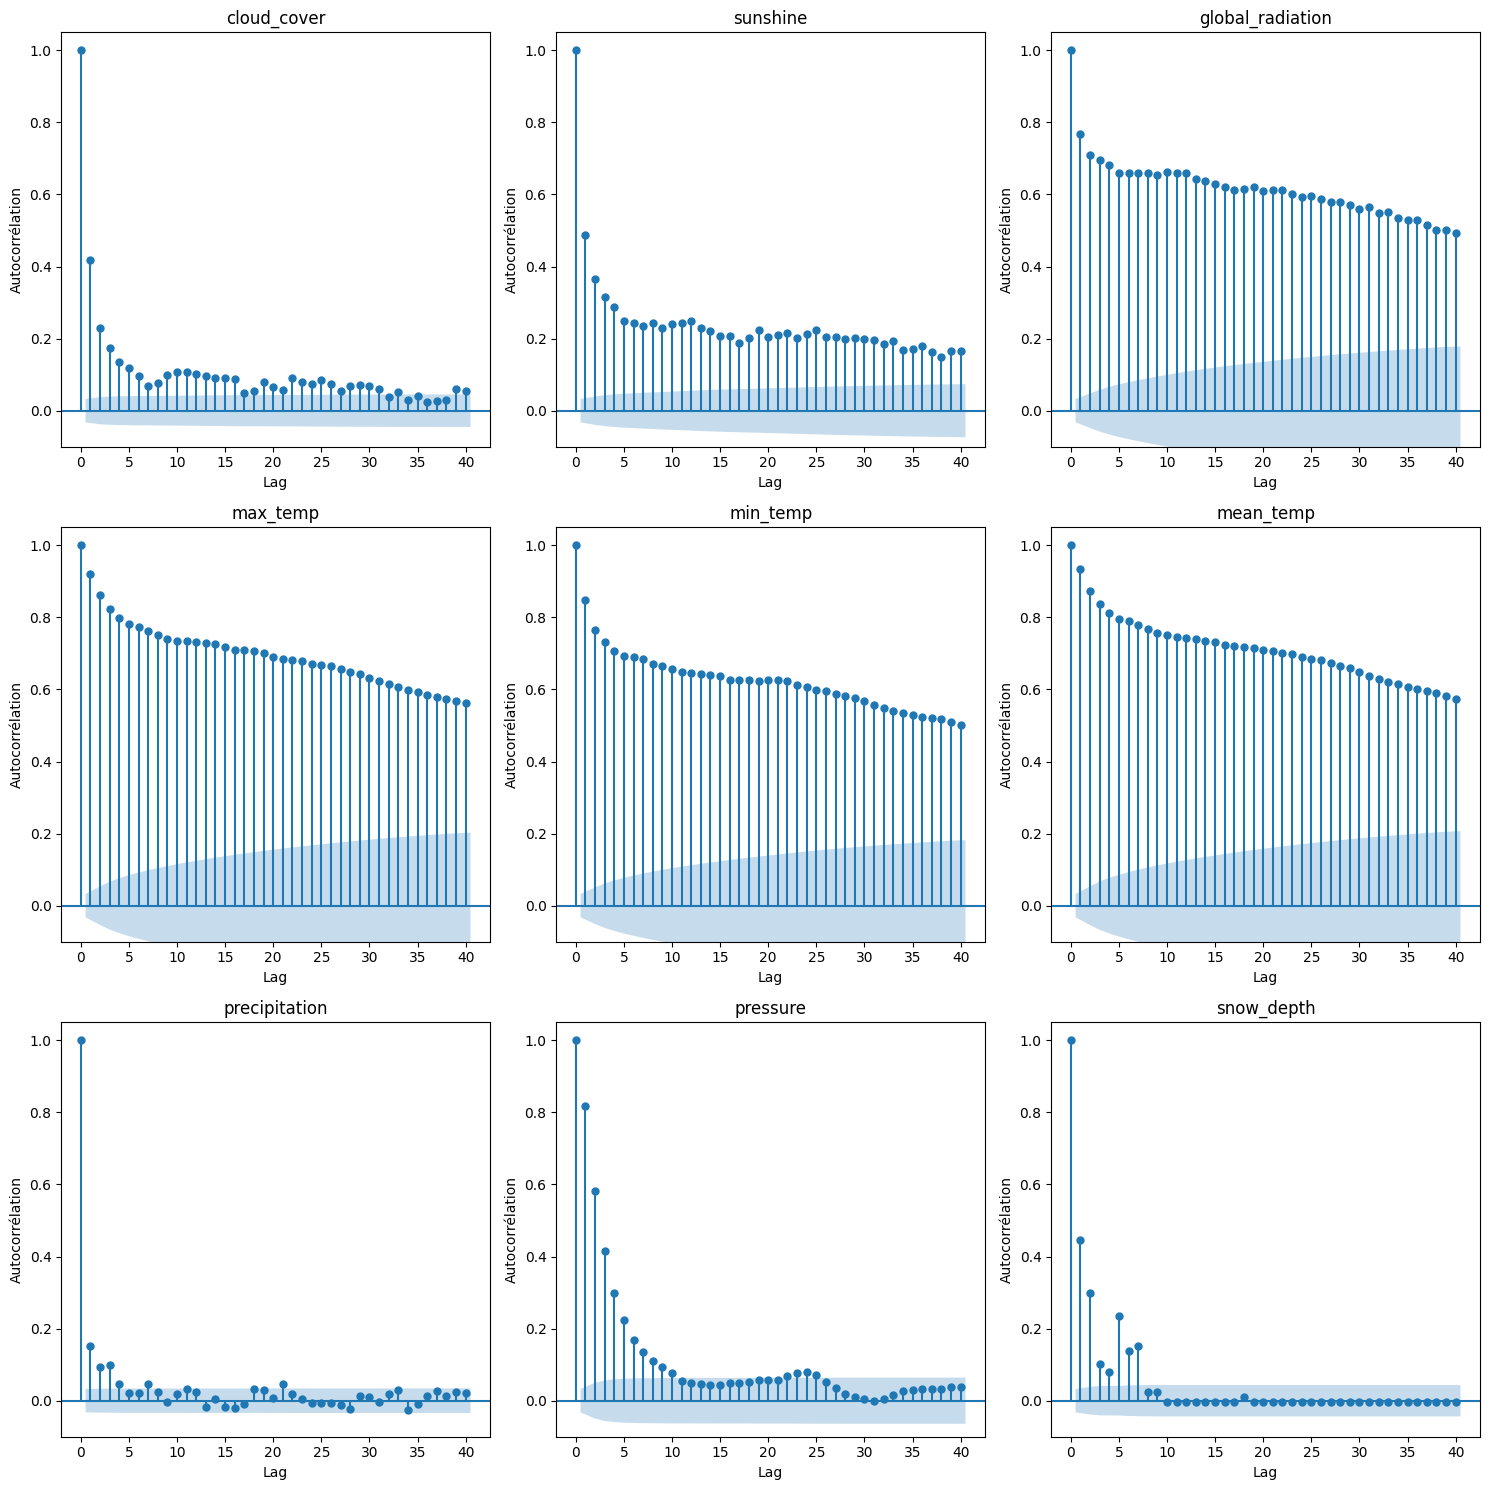

In [1401]:
weather_variables = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'mean_temp', 'precipitation', 'pressure', 'snow_depth']

num_plots = len(weather_variables)
num_rows = (num_plots // 3) + (num_plots % 3 > 0) 

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, var in enumerate(weather_variables):
    row = i // 3  
    col = i % 3  
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    plot_acf(df[var], lags=40, ax=ax)
    ax.set_title(var)
    ax.set_ylim(-0.1, 1.05)  
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrélation")

for i in range(num_plots, num_rows*3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [1402]:
# Créer des indicateurs binaires pour les saisons
df['season_winter'] = (df['Season'] == 'Winter').astype(int)
df['season_summer'] = (df['Season'] == 'Summer').astype(int)

# Création des lags
def create_lags(df, column, lags):
    lag_columns = {}
    for lag in lags:
        lag_col_name = f'{column}_lag{lag}'
        lag_col = df[column].shift(lag)
        
        lag_columns[lag_col_name] = lag_col
    
    return pd.DataFrame(lag_columns)

# Définition des lags
selective_lags = {
    'snow_depth': [365, 366, 367, 368, 369, 370, 371, 372],
    'max_temp': [365, 366, 367, 368, 369, 370, 371, 372, 379, 395],
    'min_temp': [365, 366, 367, 368, 369, 370, 371, 372, 379, 395],
    'mean_temp': [365, 366, 367, 368, 369, 370, 371, 372, 379, 395],
    'sunshine': [365, 366, 367, 368, 369, 370, 371, 372, 379, 395],
    'global_radiation': [365, 366, 367, 368, 369, 370, 371, 372, 379, 395],
    'precipitation': [365, 366, 367, 368, 369],
    'pressure': [365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375],
    'cloud_cover': [365, 366, 367, 368, 369, 370, 371, 372, 379, 395],
    'diurnal_air': [365, 366, 367, 368, 369, 370, 371, 372, 379, 395],
    'frost_risk': [365, 366, 367, 368, 369, 370, 371, 372, 379, 395],
}

lag_dfs = []
for column, lags in selective_lags.items():
    lag_df = create_lags(df, column, lags)
    lag_dfs.append(lag_df)

df = pd.concat([df] + lag_dfs, axis=1)

<span id="5."></span>

## 5. Prétraitement des données pour la modélisation prédictive

<span id="5.1."></span>

### 5.1. Ajustement des données pour la modélisation

In [1403]:
# Encoder les jours, mois et saisons pour pouvoir les inclure dans le modèle
days = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,'Thursday':  3,'Friday': 4,'Saturday':  5,'Sunday':  6}
df['Day'] = df['Day'].apply(lambda x: days[x])
df['Day'] = df['Day'].astype(int)

seasons = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
df['Season'] = df['Season'].apply(lambda x: seasons[x])
df['Season'] = df['Season'].astype(int)

months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df['Month'] = df['Month'].apply(lambda x: months[x])
df['Month'] = df['Month'].astype(int)

df['Year'] = df['Year'].astype(int)

<span id="5.1-2."></span>

### 5.2. Split

Ici, nous réalisons un split des données en respectant l'ordre chronologique pour préserver la structure temporelle. Cela garantit que les données d'entraînement sont antérieures aux données de validation et de test, ce qui est crucial avec des séries temporelles. Nous avons choisi d'utiliser une fonction pour effectuer ce split afin de simplifier le processus lors de la modélisation. Même si ce n'est pas visible dans la fonction, le split sera effectué de manière à ce que les données allant de 2011 jusqu'à la fin de 2018 soient assignées à l'ensemble d'entraînement, l'année 2019 à l'ensemble de validation, et l'année 2020 à l'ensemble de test. Par ailleurs, l'utilisation d'un ensemble de validation permet également de s'assurer que les ajustements des hyperparamètres contribuent à améliorer la capacité du modèle à généraliser.

In [1404]:
def train_test_split(df, cutoff_train, cutoff_val):
    train_data = df[df.index <= cutoff_train]
    validation_data = df[(df.index > cutoff_train) & (df.index <= cutoff_val)]
    test_data = df[df.index > cutoff_val]
    return train_data, validation_data, test_data

<span id="6."></span>

## 6. Sélection des modèles

Dans cette section, nous nous intéressons à la sélection des différents modèles. En effet, cette dernière vise à choisir et tester les modèles plus appropriés et efficaces pour prédire la température moyenne à Londres. Concernant la métrique utilisée, il s'agit de la RMSE. Ce choix se justifie par le fait que la RMSE est particulièrement sensible aux erreurs importantes, ce qui est essentiel dans des contextes où l'on souhaite avoir des prévisions les plus précises possible, comme les prévisions météorologiques. 

<span id="6.1."></span>

### 6.1. Modèles naïfs 

Avant toute chose, il est primordial de réaliser un modèle benchmark pour établir une référence initiale. Ainsi, nous pourrons comparer ces perfomances de base à celles de nos modèles de prédiction. Ici, nous réalisons un naïf et saisonnier naïf comme benchmarks. Cela nous permet donc de mesurer efficacement l'amélioration apportée par des techniques de prévision plus élaborées avec des modèles de Machine Learning ou de Deep Learning par exemple et de nous assurer que leur utilisation est justifiée.

**Modèle naïf**

Nous commençons tout d'abord avec un modèle naïf simple qui consiste simplement à fixer toutes les prévisions à la valeur de la dernière observation. 

In [1405]:
train_data, validation_data, test_data = train_test_split(df, "2018-12-31", "2019-12-31")

validation_data.loc[:, 'naive_forecast'] = train_data['mean_temp'].iloc[-1]
test_data.loc[:, 'naive_forecast'] = train_data['mean_temp'].iloc[-1]

rmse_naive_valid = root_mean_squared_error(
    validation_data['mean_temp'], validation_data['naive_forecast']
)
rmse_naive_test = root_mean_squared_error(
    test_data['mean_temp'], test_data['naive_forecast']
)

print(f"Validation RMSE Naive: {rmse_naive_valid:.3f}")
print(f"Test RMSE Naive: {rmse_naive_test:.3f}")

Validation RMSE Naive: 6.239
Test RMSE Naive: 6.434


/var/folders/2_/ngq69z5j38j4khkx51gxp4dh0000gn/T/ipykernel_61136/4165039970.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2_/ngq69z5j38j4khkx51gxp4dh0000gn/T/ipykernel_61136/4165039970.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Modèle naïf saisonnier**

Le modèle naïf saisonnier consiste quant à lui à fixer chaque prévision la dernière valeur observée de la même saison. Ici, nous avons pris une période saisonnière de 365 jours, ce qui est courant pour les données météorologiques où les motifs saisonniers se répètent chaque année. 

In [1406]:
def seasonal_naive_forecast(train_data, target_date, season_length=365):
    """
    Renvoie une prévision naïve saisonnière en utilisant la valeur de la saison précédente.
    La saison ici est fixée à un an.
    
    Args:
        train_data (pd.DataFrame): DataFrame contenant les données d'entrainement.
        target_date (pd.Timestamp): La date pour laquelle la prédiction doit être effectuée.
        season_length (int):  Le nombre de jours dans un cycle de saison, fixé à 365 j.
    
    Returns:
        float: La valeur prédite pour la saison correspondante dans le passé.
    """
    days_since_train = (target_date - train_data.index.max()).days
    k = (days_since_train - 1) // season_length

    corresponding_date = target_date - pd.DateOffset(days=season_length * (k + 1))

    if corresponding_date in train_data.index:
        return train_data.loc[corresponding_date, 'mean_temp']
    else:
        # Gérer le cas où la date correspondante n'est pas dans les données train
        return None

validation_data['seasonal_naive_forecast'] = validation_data.index.map(
    lambda date: seasonal_naive_forecast(train_data, date)
)
test_data['seasonal_naive_forecast'] = test_data.index.map(
    lambda date: seasonal_naive_forecast(train_data, date)
)

validation_data = validation_data.dropna(subset=['seasonal_naive_forecast'])
test_data = test_data.dropna(subset=['seasonal_naive_forecast'])

rmse_seasonal_naive_val = root_mean_squared_error(
    validation_data['mean_temp'], validation_data['seasonal_naive_forecast']
)
rmse_seasonal_naive_test = root_mean_squared_error(
    test_data['mean_temp'], test_data['seasonal_naive_forecast']
)

print(f"Validation RMSE Seasonal Naive: {rmse_seasonal_naive_val:.3f}")
print(f"Test RMSE Seasonal Naive: {rmse_seasonal_naive_test:.3f}")

Validation RMSE Seasonal Naive: 4.106
Test RMSE Seasonal Naive: 4.362


/var/folders/2_/ngq69z5j38j4khkx51gxp4dh0000gn/T/ipykernel_61136/3100445407.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2_/ngq69z5j38j4khkx51gxp4dh0000gn/T/ipykernel_61136/3100445407.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Visualisation des résultats**

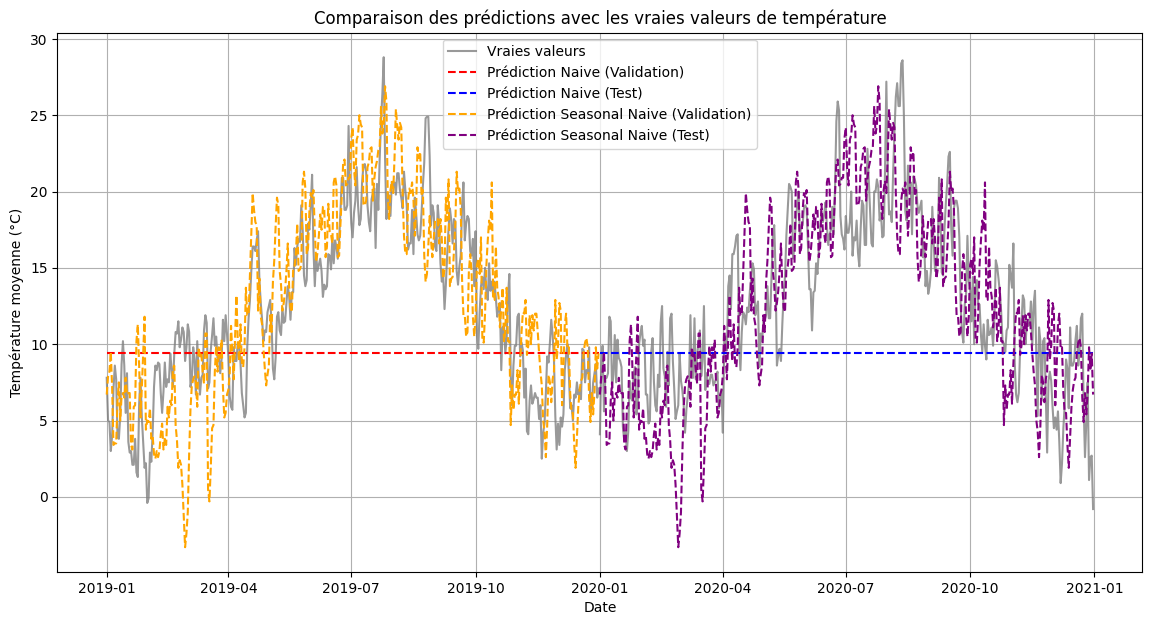

In [1407]:
plt.figure(figsize=(14, 7))

plt.plot(validation_data.index, validation_data['mean_temp'], label='Vraies valeurs', color='grey', alpha=0.8)
plt.plot(test_data.index, test_data['mean_temp'], color='grey', alpha=0.8) 
plt.plot(validation_data.index, validation_data['naive_forecast'], label='Prédiction Naive (Validation)', color='red', linestyle='--')
plt.plot(test_data.index, test_data['naive_forecast'], label='Prédiction Naive (Test)', color='blue', linestyle='--')
plt.plot(validation_data.index, validation_data['seasonal_naive_forecast'], label='Prédiction Seasonal Naive (Validation)', color='orange', linestyle='--')
plt.plot(test_data.index, test_data['seasonal_naive_forecast'], label='Prédiction Seasonal Naive (Test)', color='purple', linestyle='--')

plt.title('Comparaison des prédictions avec les vraies valeurs de température')
plt.xlabel('Date')
plt.ylabel('Température moyenne (°C)')
plt.legend()

plt.grid(True)
plt.show()

<span id="6.2."></span>

### 6.2. Choix des modèles de prévision

Dans cette sous-section, l'objectif est de tester et comparer différents modèles prédictifs afin de déterminer lequel fonctionne le mieux avec nos données météorologiques. Nous cherchons également à identifier les features les plus déterminantes dans la prédiction en analysant leur impact sur les prédictions de chaque modèle. 

Nous testerons ici deux approches. La première approche consiste à utiliser un algorithme de Deep Learning de type réseaux de neurones récurrents (RNN), capable de capturer les dépendances temporelles complexes dans les séries chronologiques. La deuxième approche consiste quant à elle à prendre un lag minimal de 365 jours, étant donné que nous souhaitons prédire sur un an. L'objectif est alors de comparer ces deux méthodes et de voir laquelle fonctionne le mieux avec nos données. 

<span id="6.2.1."></span>

#### 6.2.1. Première approche : sélection du modèle

Pour prédire la température moyenne sur une année, il est primordial de prendre en compte les variations temporelles et saisonnières des données météorologiques. Pour ce faire, les RNN s'avèrent particulièrement adaptés à ce type de tâche, car ils permettent de capturer les dépendances temporelles présentes dans les séquences de données. Parmi les différentes architectures de RNN, deux architectures sont ici intéressantes et adaptées à notre étude, les GRU et les Long Short-Term Memory (LSTM) en raison de leurs capacités à conserver la mémoire à long terme des séquences temporelles. Les LSTM et les GRU sont conçus pour résoudre le problème du "vanishing gradient" rencontré dans les RNN classiques, en permettant de mieux capturer les dépendances à long terme dans les séquences de données. Cependant, nous nous intéresserons ici aux GRU plutôt qu'aux LSTM pour plusieurs raisons. Premièrement, les GRU sont généralement plus simples en termes de nombre de paramètres, ce qui se traduit par une vitesse de calucul plus intéressante. Deuxièmement, les GRU intègrent des mécanismes pour contrôler le surapprentissage. Ainsi, même si les LSTM et les GRU présentent des performances en général comparables, les GRU permettent d'avoir une alternative efficace et moins complexe.

<span id="6.2.2."></span>

#### 6.2.2. Deuxième approche : sélection du modèle

Pour cette deuxième approche, nous nous appuierons sur l'outil MLflow,. Cela permettra d'enregistrer pour chaque modèle, ses performances mesurées par la RMSE, ainsi que de visualiser les feature importances et de sauvegarder le modèle lui-même. L'utilisation de MLflow nous permettra ainsi d'améliorer la reproductibilité de nos expériences et d'optimiser le processus de sélection du ou des modèles. 

Nous ferons tourner différents modèles étape par étape. Nous commencerons par les features de base laguées, puis nous ajouterons progressivement les features cycliques, les tendances, et enfin les features métiers. Pour illustrer notre démarche, nous montrons ci-dessous le code utilisé pour créer nos expériences sur MLflow pour un modèle, mais notons que cette démarche a été répétée pour chaque modèle testé. Vous trouverez un tableau récapitulatif comprenant l'ensemble des modèles testés et de leurs performances step by step. 

In [1408]:
# Mise en place de MLflow
tracking_uri="http://127.0.0.1:8086"
client = MlflowClient(tracking_uri=tracking_uri)
mlflow.set_tracking_uri(tracking_uri)
print(f"tracking URI: '{client.tracking_uri}'")

tracking URI: 'http://127.0.0.1:8086'


In [1409]:
# Création d'une expérience
experiment_description = (
    "This is the London weather prediction project."
    "This experiment contains the produced models for predicting the average temperature in London."
)
experiment_tags = {
    "project_name": "london-weather-prediction",
    "team": "lea",
    "project_quarter": "Q1-2024",
    "mlflow.note.content": experiment_description,
}
produce_apples_experiment = client.create_experiment(
    name="London_Weather_Models", tags=experiment_tags
)

In [1410]:
# Seconde approche (lag minimal de 365)

# Variables initiales laguées avec un lag minimal de 365 (+ marqueurs temporels)
INIT_LAG_FEAT_MIN365 = [
    "Year", "Month", "Day", "Season", "day_of_year"
] + [
    f"{var}_lag{lag}" for var in [
        "snow_depth", "max_temp", "min_temp", "mean_temp", "sunshine", "global_radiation", "cloud_cover"
    ] for lag in [365, 366, 367, 368, 369, 370, 371, 372, 379, 395]
    if not ((var == "snow_depth" and lag in [379, 395]) or
            (var == "precipitation" and lag in [370, 371, 372, 379, 395]))
    ] + [
        f"pressure_lag{lag}" for lag in [365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375]
    ]

# Features cycliques 
CYC_FEAT_DIRREC = [
    'sin_day_of_year', 'cos_day_of_year'
]

# Trend 
TREND_FEAT_MIN365 = ["time"]

# Variables métiers et autres caractéristiques calculées
BUSINESS_FEAT_MIN365 = [
    "cold_wave_spring_2013", "heat_wave_summer_2018",
    *[f"{var}_lag{lag}" for var in ['frost_risk', 'diurnal_air'] for lag in [366, 367, 368, 369, 370, 371, 372, 379, 395]]
]

# Construction du dictionnaire 
dict_features_min365 = {
    'STEP_1': INIT_LAG_FEAT_MIN365,
    'STEP_2': INIT_LAG_FEAT_MIN365+CYC_FEAT_DIRREC,
    'STEP_3': INIT_LAG_FEAT_MIN365+CYC_FEAT_DIRREC+TREND_FEAT_MIN365,
    'STEP_4': INIT_LAG_FEAT_MIN365+TREND_FEAT_MIN365+BUSINESS_FEAT_MIN365,
}

LIST_STEPS_MIN365 = ['STEP_1', 'STEP_2', 'STEP_3', 'STEP_4']

LIST_STEPS_NAME_MIN365 = ['INITIAL_DATA_W_LAGS', 
                         'INITIAL DATA W LAGS + CYCLICAL FEATURES',
                         'INITIAL DATA W LAGS + CYCLICAL FEATURES + TREND',
                         'INITIAL DATA W LAGS + CYCLICAL FEATURES + TREND + BUSINESS FEATURES']

dict_stepname_MIN365 = dict(zip(LIST_STEPS_MIN365, LIST_STEPS_NAME_MIN365))

In [1411]:
# Voici un exemple de code utilisé pour mener une expérimentation sur MLflow pour un modèle avec un lag min de 365
# Il s'agit ici du CatBoost, mais la démarche a été plus ou moins la même pour chaque modèle testé

mlflow.set_experiment("CatBoost_Min365")

train_data, validation_data, _ = train_test_split(df, "2018-12-31", "2019-12-31")

def train_and_log_features_catboost(features, step_name):
    with mlflow.start_run(run_name=step_name):
        X_train = train_data[features]
        y_train = train_data['mean_temp']
        X_val = validation_data[features]
        y_val = validation_data['mean_temp']

        model = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

        mlflow.sklearn.log_model(model, "model")

        feature_importances = pd.DataFrame({
            'feature': features,
            'importance': model.get_feature_importance()
        }).sort_values(by='importance', ascending=False)

        plt.figure(figsize=(10, 15))
        sns.barplot(x="importance", y="feature", data=feature_importances)
        plt.title(f'Feature importance for {step_name}')
        plt.tight_layout()
        plt.savefig("feature_importance.png")
        plt.close()
        mlflow.log_artifact("feature_importance.png")

        return rmse

rmses_catboost = []

for step in LIST_STEPS_MIN365:
    features = dict_features_min365[step]
    print(f"Training and evaluating model for {step}...")
    rmse_catboost = train_and_log_features_catboost(features, step)
    rmses_catboost.append((step, rmse_catboost))

plt.figure(figsize=(12, 6))
plt.bar([x[0] for x in rmses_catboost], [x[1] for x in rmses_catboost], color='green')
plt.xlabel('Feature set steps')
plt.ylabel('RMSE')
plt.title('RMSE for different feature set steps - CatBoost')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("rmse_steps_histogram_catboost.png")
plt.close() 
mlflow.log_artifact("rmse_steps_histogram_catboost.png")

Training and evaluating model for STEP_1...


Training and evaluating model for STEP_2...
Training and evaluating model for STEP_3...
Training and evaluating model for STEP_4...


<center>

<h3>Résumé des expérimentations</h3>

**Modèles de Machine Learning**

| Modèle                            	| STEP 1 | STEP 2 | STEP 3 | STEP 4 |
|---------------------------------------|--------|--------|--------|--------|
| Régression Linéaire               	|  3.949 |  2.757 |  2.757 |  3.710 |
| SVR                               	|  5.429 |  5.428 |  5.428 |  5.427 |
| Random Forest                     	|  2.601 |  2.609 |  2.604 |  2.622 |
| Gradient Boosting 	                |  2.671 |  2.622 |  2.616 |  2.653 | 	
| XGBoost                           	|  2.769 |  2.846 |  2.846 |  2.792 |
| LightGBM                          	|  2.607 |  2.649 |  2.607 |  2.649 |
| CatBoost                          	|  2.668 |  2.619 |  <span style="color:green;">2.584</span> |  2.656 |

Rappel : la métrique utilisée ici est la RMSE

</center>

<center>

<h3>Discussion</h3>

</center>

Dans cette analyse, nous avons exploré un ensemble de modèles de Machine Learning pour prédire les températures moyennes. Les modèles ont été enregistrés et évalués à l'aide de MLflow pour permettre une gestion plus efficace des résultats et des performances. Cela a par ailleurs permis de ne pas surcharger le Notebook avec un grand nombre de tests de modèles. Les tableaux ci-dessus comprennent les résultats obtenus (RMSE) pour les différentes expérimentations réalisées. 

Nous avons évalué plusieurs algorithmes classiques tels que la régression linéaire, le Random Forest, le Gradient Boosting, et d'autres. Les résultats sont présentés sous forme de RMSE pour chaque étape du processus, allant de STEP 1 à STEP 4. Parmi les meilleures performances, le modèle de CatBoost à l'étape 3 se démarque avec une RMSE de 2.519. 

L'objectif principal de cette analyse était d'explorer une large gamme de modèles pour déterminer les meilleures performances et identifier les modèles les plus prometteurs à optimiser et à tuner. Ainsi, le CatBoost ayant donné les meilleures performances à l'étape 3, nous nous concentrerons par la suite sur l'optimisation et l'ajustement des hyperparamètres. 

<span id="7."></span>

## 7. Evaluation de la perfomance des modèles

Dans cette section, nous nous concentrerons principalement sur l'évaluation de la perfomance des modèles mais également la recherche des hyperparamètres et le contrôle de l'overfitting. 

<span id="7.1."></span>

### 7.1. Première approche

<span id="7.1.1."></span>

#### 7.1.1. Optimisation

In [1274]:
def reset_random_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

In [1275]:
reset_random_seeds()

features = [
    "Year", "Month", "Day", "Season", "day_of_year", "sin_day_of_year",
    "cos_day_of_year", "time", "season_winter", "season_summer", "diurnal_air", 
    "frost_risk", "cold_wave_spring_2013", "heat_wave_summer_2018", "snow_depth", 
    "max_temp", "min_temp", "sunshine", "global_radiation", "cloud_cover"
]

to_scale = ["snow_depth", "max_temp", "min_temp", "sunshine", "global_radiation", "cloud_cover", "diurnal_air"]
no_scale = [col for col in features if col not in to_scale]

target = "mean_temp"

def objective(trial):
    # Choix du scaler
    scaler_choices = {
        'standard': StandardScaler(),
        'robust': RobustScaler(),
        'minmax': MinMaxScaler()
    }
    scaler = scaler_choices[trial.suggest_categorical('scaler_type', ['standard', 'robust', 'minmax'])]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, to_scale),
            ('cat', 'passthrough', no_scale)
        ])
    
    # Construction du modèle
    model = Sequential()
    for i in range(trial.suggest_int('encoder_n_layers', 1, 5)):
        model.add(GRU(units=trial.suggest_categorical('encoder_hidden_size', [64, 128, 256]),
                      return_sequences=True if i < trial.suggest_int('encoder_n_layers', 1, 3) - 1 else False))
        model.add(Dropout(rate=trial.suggest_float('encoder_dropout', 0, 0.9)))
    
    model.add(Dense(units=trial.suggest_categorical('decoder_hidden_size', [64, 128, 256]), activation='relu'))
    model.add(Dense(1))
    
    # Choix de l'optimiseur
    if trial.suggest_categorical('optimizer', ['adam', 'sgd']) == 'adam':
        optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True))
    else:
        optimizer = SGD(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_train_transformed = X_train_transformed.reshape((X_train_transformed.shape[0], 1, X_train_transformed.shape[1]))
    X_valid_transformed = preprocessor.transform(X_valid)
    X_valid_transformed = X_valid_transformed.reshape((X_valid_transformed.shape[0], 1, X_valid_transformed.shape[1]))
    
    model.fit(X_train_transformed, y_train, epochs=100, batch_size=32, validation_data=(X_valid_transformed, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
   
    y_pred = model.predict(X_valid_transformed)
    return mean_squared_error(y_valid, y_pred, squared=False)  

# Configuration de la validation croisée avec Optuna
def cross_validate_with_optuna(df):
    study = optuna.create_study(direction='minimize')
    for i in range(5):
        train_end = 2014 + i
        valid_year = 2015 + i
        
        global X_train, y_train, X_valid, y_valid
        train_data = df[(df.index.year >= 2011) & (df.index.year <= train_end)]
        valid_data = df[df.index.year == valid_year]
        
        X_train = train_data[features]
        y_train = train_data[target].to_numpy()
        X_valid = valid_data[features]
        y_valid = valid_data[target].to_numpy()
        
        study.optimize(objective, n_trials=10)
        
        print(f'CV {i+1} - Best RMSE so far: {study.best_value}')

    return study.best_params

best_params = cross_validate_with_optuna(df)
print("Best parameters:", best_params)

[I 2024-04-27 18:17:39,545] A new study created in memory with name: no-name-5badb305-eaa6-425f-a5b8-698d1a758cef


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 120.8526 - val_loss: 24.8286
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.7991 - val_loss: 23.6488
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.2840 - val_loss: 22.7301
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27.9655 - val_loss: 10.1844
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.3824 - val_loss: 8.6663
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9696 - val_loss: 6.8390
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7445 - val_loss: 7.2974
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4125 - val_loss: 6.8515
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7534 - val_loss: 7.4435
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2896 - val_loss: 7.1296
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2200 - val_loss: 7.1078
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:17:46,374] Trial 0 finished with value: 2.6151540279388428 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.063145720969391, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00030580533276814846}. Best is trial 0 with value: 2.6151540279388428.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 137.2077 - val_loss: 31.7091
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.8609 - val_loss: 19.7905
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.4357 - val_loss: 16.6756
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.9810 - val_loss: 13.7663
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.7919 - val_loss: 11.7442
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8028 - val_loss: 10.0244
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7320 - val_loss: 8.7810
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.4715 - val_loss: 7.7553
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.9375 - val_loss: 7.7708
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.4769 - val_loss: 7.3246
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7931 - val_loss: 6.8291
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:17:49,041] Trial 1 finished with value: 2.570643901824951 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 1, 'encoder_hidden_size': 256, 'encoder_dropout': 0.24813700685750537, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00035800683672249534}. Best is trial 1 with value: 2.570643901824951.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160.8505 - val_loss: 125.0559
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 116.9351 - val_loss: 84.9493
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 79.4487 - val_loss: 52.1189
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 50.9619 - val_loss: 32.4365
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 35.1541 - val_loss: 23.4500
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 28.0232 - val_loss: 19.6019
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 24.5517 - val_loss: 16.5103
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 22.0917 - val_loss: 14.8488
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 20.3725 - val_loss: 13.6297
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 19.3939 - val_loss: 12.6983
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 18.2811 - val_loss: 11.9011
Epoch 12/100
46/46 ━━━━━━━━━━━

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:17:51,726] Trial 2 finished with value: 2.5564215183258057 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'encoder_dropout': 0.02805748811756952, 'decoder_hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 9.984093519441586e-05}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 75.6900 - val_loss: 56.2092
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 45.2287 - val_loss: 79.5124
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 39.1545 - val_loss: 87.4263
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 37.6931 - val_loss: 85.2207
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 36.6199 - val_loss: 90.4683
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 37.3168 - val_loss: 97.8834
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:17:53,043] Trial 3 finished with value: 7.497281551361084 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 1, 'encoder_hidden_size': 128, 'encoder_dropout': 0.8855430946278979, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00931458546680736}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 71.2020 - val_loss: 24.8112
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.7095 - val_loss: 24.7627
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 35.4795 - val_loss: 24.2620
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36.2727 - val_loss: 24.0433
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 36.6035 - val_loss: 24.8761
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 34.2101 - val_loss: 24.0614
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 34.2726 - val_loss: 24.6174
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 35.6858 - val_loss: 24.5373
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36.1433 - val_loss: 24.0685
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:00,384] Trial 4 finished with value: 4.9033989906311035 and parameters: {'scaler_type': 'standard', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.6953793267586148, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.022373325909603708}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 172.8570 - val_loss: 170.3110
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171.7450 - val_loss: 169.0671
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170.4720 - val_loss: 167.8107
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169.2363 - val_loss: 166.4148
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 167.8504 - val_loss: 164.8637
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166.3900 - val_loss: 163.0952
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164.7804 - val_loss: 161.0330
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162.6881 - val_loss: 158.5668
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160.3569 - val_loss: 155.6378
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157.6283 - val_loss: 152.2135
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154.5545 - val_loss: 148.2283
Epoch 12/100
46/46 ━━━━━━━━━━━━

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:10,182] Trial 5 finished with value: 3.3355510234832764 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 3, 'encoder_hidden_size': 64, 'encoder_dropout': 0.3494439342116247, 'decoder_hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 1.4146158027528568e-05}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 170.4592 - val_loss: 156.9322
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.3624 - val_loss: 37.5593
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.0171 - val_loss: 24.5081
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.8249 - val_loss: 23.6321
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.2172 - val_loss: 22.9938
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.1025 - val_loss: 22.1038
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.7661 - val_loss: 19.4575
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.5446 - val_loss: 15.3831
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.5875 - val_loss: 12.7056
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.2985 - val_loss: 11.7704
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.1061 - val_loss: 11.7304
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:16,927] Trial 6 finished with value: 2.8984806537628174 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 5, 'encoder_hidden_size': 64, 'encoder_dropout': 0.39542216863974267, 'decoder_hidden_size': 128, 'optimizer': 'adam', 'learning_rate': 0.00024483076086261816}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 163.8967 - val_loss: 166.5130
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 154.9381 - val_loss: 161.8518
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 146.0824 - val_loss: 156.8105
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 138.4080 - val_loss: 151.2881
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 130.1413 - val_loss: 145.2884
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 122.5248 - val_loss: 138.7523
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 114.8331 - val_loss: 131.6701
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 107.1082 - val_loss: 124.0173
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 99.3873 - val_loss: 116.0214
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 92.1961 - val_loss: 107.6749
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 85.9541 - val_loss: 99.0470
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:31,570] Trial 7 finished with value: 5.147754669189453 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.8414397694582583, 'decoder_hidden_size': 64, 'optimizer': 'sgd', 'learning_rate': 8.273993612042363e-05}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153.7989 - val_loss: 136.8041
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 120.7484 - val_loss: 105.9455
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 90.7724 - val_loss: 73.6504
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 67.1781 - val_loss: 49.3240
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 52.8096 - val_loss: 36.9718
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 46.1585 - val_loss: 31.1743
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 43.7203 - val_loss: 28.8856
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 42.0591 - val_loss: 28.5781
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 44.8077 - val_loss: 28.5921
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 43.7432 - val_loss: 28.2008
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 41.8862 - val_loss: 28.8503
Epoch 12/100
46/46 ━━━━━━━━━━

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:33,724] Trial 8 finished with value: 5.310444355010986 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 2, 'encoder_hidden_size': 64, 'encoder_dropout': 0.7859658934520358, 'decoder_hidden_size': 128, 'optimizer': 'sgd', 'learning_rate': 0.00012882516267670606}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 528.8054 - val_loss: 27.0579
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.6932 - val_loss: 24.1608
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8553 - val_loss: 24.1399
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8175 - val_loss: 24.1374
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8439 - val_loss: 24.0844
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8324 - val_loss: 24.1344
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8235 - val_loss: 24.1350
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8275 - val_loss: 24.1348
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8686 - val_loss: 24.1354
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8379 - val_loss: 24.1351
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:36,548] Trial 9 finished with value: 4.907584190368652 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 2, 'encoder_hidden_size': 256, 'encoder_dropout': 0.5612457370480638, 'decoder_hidden_size': 128, 'optimizer': 'sgd', 'learning_rate': 0.039189106125626726}. Best is trial 2 with value: 2.5564215183258057.


CV 1 - Best RMSE so far: 2.5564215183258057
Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 58.7084 - val_loss: 35.4355
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.5804 - val_loss: 35.7816
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.4964 - val_loss: 37.4750
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.8394 - val_loss: 37.1641
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.7121 - val_loss: 36.9221
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.6504 - val_loss: 36.8597
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:38,570] Trial 10 finished with value: 5.952773094177246 and parameters: {'scaler_type': 'standard', 'encoder_n_layers': 2, 'encoder_hidden_size': 128, 'encoder_dropout': 0.058314879837627065, 'decoder_hidden_size': 256, 'optimizer': 'sgd', 'learning_rate': 0.003219770192763473}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 80.9155 - val_loss: 28.5413
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 25.1002 - val_loss: 24.5240
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 22.4011 - val_loss: 21.5877
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 19.1765 - val_loss: 17.4157
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 17.5219 - val_loss: 13.6242
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 16.5198 - val_loss: 15.5322
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 17.8354 - val_loss: 12.2598
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 17.3422 - val_loss: 12.6202
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 16.3325 - val_loss: 11.9088
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 16.3081 - val_loss: 10.9095
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 15.3718 - val_loss: 13.8789
Epoch 12/100
58/58 ━━━━━━━━━━━━━━

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:40,390] Trial 11 finished with value: 3.30295991897583 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'encoder_dropout': 0.21056199653888324, 'decoder_hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 0.00115346713307365}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162.5668 - val_loss: 135.9148
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 125.9354 - val_loss: 104.5824
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.0835 - val_loss: 76.7398
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.3187 - val_loss: 55.9837
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.9516 - val_loss: 41.3200
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.3942 - val_loss: 33.0543
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.2852 - val_loss: 28.7343
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.1623 - val_loss: 26.1529
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.1013 - val_loss: 24.5958
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.7457 - val_loss: 23.2587
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2155 - val_loss: 22.1584
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:51,424] Trial 12 finished with value: 2.7346384525299072 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 1, 'encoder_hidden_size': 256, 'encoder_dropout': 0.2194543941683508, 'decoder_hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 2.3303872155208737e-05}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 133.4322 - val_loss: 34.4119
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.9134 - val_loss: 33.0196
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.7447 - val_loss: 33.0414
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.6382 - val_loss: 32.9992
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.7754 - val_loss: 32.9892
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.9669 - val_loss: 32.9824
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.3565 - val_loss: 32.9762
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.4189 - val_loss: 32.9748
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.7763 - val_loss: 32.9735
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.2428 - val_loss: 32.9361
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.3951 - val_loss: 32.8309
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:18:56,940] Trial 13 finished with value: 5.503182888031006 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 3, 'encoder_hidden_size': 64, 'encoder_dropout': 0.15016484732623678, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0009647697455611407}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 154.4009 - val_loss: 102.3878
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86.9060 - val_loss: 57.3798
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.6013 - val_loss: 38.5188
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33.2281 - val_loss: 32.1536
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.3190 - val_loss: 28.3978
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.3808 - val_loss: 25.9994
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.5274 - val_loss: 23.8697
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.8933 - val_loss: 22.3232
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.4542 - val_loss: 20.7963
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.2361 - val_loss: 19.3691
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0975 - val_loss: 18.1332
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:19:01,451] Trial 14 finished with value: 2.6571719646453857 and parameters: {'scaler_type': 'standard', 'encoder_n_layers': 1, 'encoder_hidden_size': 128, 'encoder_dropout': 0.015825288074704236, 'decoder_hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 8.379346839539153e-05}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 89.7538 - val_loss: 30.7111
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.0063 - val_loss: 21.7791
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4285 - val_loss: 13.3178
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.3098 - val_loss: 10.0334
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.6395 - val_loss: 9.7526
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.7847 - val_loss: 9.6586
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.3684 - val_loss: 8.0770
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.0175 - val_loss: 8.2208
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.1711 - val_loss: 9.2383
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.9660 - val_loss: 8.2224
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.7194 - val_loss: 8.2385
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:19:05,960] Trial 15 finished with value: 2.8420095443725586 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 2, 'encoder_hidden_size': 256, 'encoder_dropout': 0.3082735786568529, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0005202800445579794}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 154.6843 - val_loss: 144.7064
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 137.8925 - val_loss: 130.7558
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 124.1972 - val_loss: 117.5811
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 109.8971 - val_loss: 102.1430
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 94.5479 - val_loss: 88.9529
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 82.1298 - val_loss: 77.0653
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 70.6861 - val_loss: 66.5564
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 62.5564 - val_loss: 57.4356
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 53.1466 - val_loss: 49.6186
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 46.9031 - val_loss: 43.3109
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 40.8884 - val_loss: 38.4564
Epoch 12/100
58/58 ━━━━━━

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:19:12,134] Trial 16 finished with value: 3.535923480987549 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'encoder_dropout': 0.5135626470952749, 'decoder_hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 3.513242091192328e-05}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 62.9167 - val_loss: 33.2959
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.6511 - val_loss: 29.5028
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23.2556 - val_loss: 23.5885
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 21.7624 - val_loss: 21.2160
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.2552 - val_loss: 21.4167
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 21.8780 - val_loss: 19.0600
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.0214 - val_loss: 19.9802
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.8621 - val_loss: 17.2416
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.1446 - val_loss: 12.5918
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.2658 - val_loss: 14.3361
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.4906 - val_loss: 15.9664
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:19:27,281] Trial 17 finished with value: 3.310161590576172 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.13735444437058447, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.002287137116967071}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 80.5766 - val_loss: 38.3166
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32.0071 - val_loss: 37.3761
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.3427 - val_loss: 35.6654
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.7322 - val_loss: 34.9544
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.7363 - val_loss: 33.9263
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.2698 - val_loss: 34.4308
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.6530 - val_loss: 34.3867
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.7128 - val_loss: 37.3146
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.7904 - val_loss: 35.0133
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.4410 - val_loss: 34.2665
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:19:30,487] Trial 18 finished with value: 5.824626445770264 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 3, 'encoder_hidden_size': 64, 'encoder_dropout': 0.27930238998383516, 'decoder_hidden_size': 256, 'optimizer': 'sgd', 'learning_rate': 0.005187882146802526}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 158.7641 - val_loss: 143.8617
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139.7608 - val_loss: 119.8620
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.8767 - val_loss: 90.8778
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88.3000 - val_loss: 62.5732
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.1615 - val_loss: 42.6221
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.5652 - val_loss: 32.9729
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.5257 - val_loss: 29.2354
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.9597 - val_loss: 27.3667
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.5180 - val_loss: 26.7597
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.5612 - val_loss: 26.3736
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.9842 - val_loss: 25.1191
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:19:38,575] Trial 19 finished with value: 3.3179690837860107 and parameters: {'scaler_type': 'standard', 'encoder_n_layers': 2, 'encoder_hidden_size': 128, 'encoder_dropout': 0.463455924919929, 'decoder_hidden_size': 128, 'optimizer': 'adam', 'learning_rate': 3.9955507389437614e-05}. Best is trial 2 with value: 2.5564215183258057.


CV 2 - Best RMSE so far: 2.5564215183258057
Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 96.7723 - val_loss: 25.9753
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6995 - val_loss: 17.8795
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.9582 - val_loss: 12.8090
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.1199 - val_loss: 10.4470
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7657 - val_loss: 9.4446
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2013 - val_loss: 9.4024
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3962 - val_loss: 8.7564
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1862 - val_loss: 8.8092
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9135 - val_loss: 8.3475
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0283 - val_loss: 9.4949
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4411 - val_loss: 8.9133
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8911 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:19:41,774] Trial 20 finished with value: 2.8892109394073486 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 1, 'encoder_hidden_size': 256, 'encoder_dropout': 0.13247507958545995, 'decoder_hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 0.00019625101467482406}. Best is trial 2 with value: 2.5564215183258057.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 84.4046 - val_loss: 31.6971
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.6437 - val_loss: 29.9674
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 22.5383 - val_loss: 9.0226
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.0592 - val_loss: 8.0707
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.8076 - val_loss: 8.8068
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7697 - val_loss: 7.8312
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2996 - val_loss: 8.2207
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2074 - val_loss: 9.5567
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.0168 - val_loss: 8.8163
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8065 - val_loss: 7.6333
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8689 - val_loss: 9.1566
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5751

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:20:14,467] Trial 21 finished with value: 1.1001662015914917 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.014311864165814425, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0004031299559637503}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 81.8615 - val_loss: 31.2766
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26.7162 - val_loss: 21.9084
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.5337 - val_loss: 11.5160
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.0079 - val_loss: 7.8943
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.2446 - val_loss: 8.6271
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3825 - val_loss: 8.5419
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6261 - val_loss: 8.3099
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2835 - val_loss: 8.4430
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9867 - val_loss: 9.0953
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:20:22,550] Trial 22 finished with value: 2.8096797466278076 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.0067023636197734065, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0004653411448989875}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 69.3633 - val_loss: 31.9502
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.8181 - val_loss: 24.6220
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.4439 - val_loss: 18.5795
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.0504 - val_loss: 10.9623
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13.4838 - val_loss: 11.1417
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.9540 - val_loss: 9.5257
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.6117 - val_loss: 10.5607
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.0743 - val_loss: 10.8135
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.8514 - val_loss: 9.8483
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.9057 - val_loss: 9.1268
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.3172 - val_loss: 11.2668
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - lo

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:20:34,570] Trial 23 finished with value: 2.9532315731048584 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.21702506310723987, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0009275687159730398}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 146.5876 - val_loss: 51.4132
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34.3421 - val_loss: 28.7953
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.9607 - val_loss: 23.2426
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.8569 - val_loss: 15.6223
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.5604 - val_loss: 11.0929
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8400 - val_loss: 9.6057
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0780 - val_loss: 8.8820
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9979 - val_loss: 9.2855
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0833 - val_loss: 9.0473
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8450 - val_loss: 9.6669
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8896 - val_loss: 9.1028
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.74

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:20:41,534] Trial 24 finished with value: 2.9802632331848145 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 3, 'encoder_hidden_size': 256, 'encoder_dropout': 0.1392997286261109, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 7.491721738333959e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 97.9170 - val_loss: 31.8607
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.4115 - val_loss: 31.7650
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.0975 - val_loss: 31.1842
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.1433 - val_loss: 24.6630
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.8945 - val_loss: 23.6135
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.9980 - val_loss: 23.8824
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.1822 - val_loss: 24.1932
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.4962 - val_loss: 23.4374
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.6316 - val_loss: 21.8326
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.3675 - val_loss: 23.4086
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6140 - val_loss: 23.5499
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:20:52,150] Trial 25 finished with value: 4.672534465789795 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 64, 'encoder_dropout': 0.08985870318675344, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0015956971912860461}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 75.2428 - val_loss: 32.1442
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.4835 - val_loss: 32.1697
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.9867 - val_loss: 32.1783
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.6766 - val_loss: 32.1851
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.3618 - val_loss: 32.0837
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.0287 - val_loss: 32.1639
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.8168 - val_loss: 31.9963
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.8403 - val_loss: 32.0377
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.8650 - val_loss: 32.1726
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.1826 - val_loss: 32.0720
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.8329 - val_loss: 32.0051
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:20:55,376] Trial 26 finished with value: 5.656527996063232 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 2, 'encoder_hidden_size': 256, 'encoder_dropout': 0.24542894014578231, 'decoder_hidden_size': 64, 'optimizer': 'sgd', 'learning_rate': 0.0004376404105472708}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 139.4918 - val_loss: 32.9102
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.7253 - val_loss: 32.6015
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.7794 - val_loss: 28.6088
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.2445 - val_loss: 24.4656
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.7845 - val_loss: 19.8214
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.0873 - val_loss: 17.4579
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.9899 - val_loss: 16.7405
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.9038 - val_loss: 15.4159
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.3256 - val_loss: 14.5875
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.1617 - val_loss: 14.4287
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.3596 - val_loss: 14.8238
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:21:07,619] Trial 27 finished with value: 3.268648862838745 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 3, 'encoder_hidden_size': 256, 'encoder_dropout': 0.6155363073867506, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00016436169231383795}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 160.3700 - val_loss: 164.9804
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 151.2242 - val_loss: 154.9252
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 142.1468 - val_loss: 144.8462
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 133.3816 - val_loss: 136.0468
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 125.1442 - val_loss: 127.9057
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 117.3273 - val_loss: 119.5558
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108.4964 - val_loss: 110.9742
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 101.8621 - val_loss: 103.8997
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 95.0762 - val_loss: 97.2923
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 89.0601 - val_loss: 91.1074
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 83.0869 - val_loss: 85.2792
Epoch 12/100
69/69 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:21:16,358] Trial 28 finished with value: 3.6923465728759766 and parameters: {'scaler_type': 'standard', 'encoder_n_layers': 1, 'encoder_hidden_size': 128, 'encoder_dropout': 0.3971600051796693, 'decoder_hidden_size': 128, 'optimizer': 'adam', 'learning_rate': 1.0484574514187732e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 150.6212 - val_loss: 34.3421
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.7315 - val_loss: 31.1522
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.2200 - val_loss: 29.5900
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.5695 - val_loss: 24.1574
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9783 - val_loss: 10.0573
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7384 - val_loss: 9.2336
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.9083 - val_loss: 9.5453
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.8530 - val_loss: 9.4747
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7124 - val_loss: 9.2896
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.5516 - val_loss: 9.5409
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.5059 - val_loss: 9.4154
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:21:21,282] Trial 29 finished with value: 3.0386910438537598 and parameters: {'scaler_type': 'minmax', 'encoder_n_layers': 4, 'encoder_hidden_size': 64, 'encoder_dropout': 0.07953000419312886, 'decoder_hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 0.0003475351257072506}. Best is trial 21 with value: 1.1001662015914917.


CV 3 - Best RMSE so far: 1.1001662015914917
Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 169.2882 - val_loss: 129.0014
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 69.2431 - val_loss: 39.4989
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 28.9495 - val_loss: 37.4416
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 26.6528 - val_loss: 32.1064
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.7633 - val_loss: 21.1010
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13.4557 - val_loss: 13.7048
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7857 - val_loss: 10.4444
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7688 - val_loss: 10.0839
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.7958 - val_loss: 9.8179
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.5846 - val_loss: 9.6396
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.5222 - val_loss: 9.8607
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:22:44,335] Trial 30 finished with value: 1.1858185529708862 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.009988951967796977, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 4.305454531614365e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 167.6138 - val_loss: 103.1189
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 52.5504 - val_loss: 39.7296
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 28.7907 - val_loss: 35.7038
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 24.0890 - val_loss: 23.7231
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 14.7603 - val_loss: 13.0405
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.5998 - val_loss: 10.6665
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0136 - val_loss: 10.3662
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.8368 - val_loss: 10.0537
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6619 - val_loss: 10.1382
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7329 - val_loss: 10.1000
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6676 - val_loss: 10.2043
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11m

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:24:06,606] Trial 31 finished with value: 1.1963751316070557 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.023515848918612213, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 4.676457680729492e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 168.0141 - val_loss: 104.3083
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 52.3069 - val_loss: 38.9795
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 27.7103 - val_loss: 30.7716
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 19.7335 - val_loss: 21.0298
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 13.8507 - val_loss: 13.8476
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9761 - val_loss: 10.3821
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9267 - val_loss: 9.8542
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8820 - val_loss: 9.7583
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.7061 - val_loss: 9.5086
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7059 - val_loss: 9.5652
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6115 - val_loss: 9.3184
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:25:11,959] Trial 32 finished with value: 1.165315866470337 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.01961034903294534, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 4.533345367902022e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 169.6084 - val_loss: 121.4049
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 64.5425 - val_loss: 39.2422
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 28.2485 - val_loss: 32.5601
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20.9392 - val_loss: 19.5992
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 12.7928 - val_loss: 11.4458
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6918 - val_loss: 10.0771
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.4657 - val_loss: 9.8005
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2105 - val_loss: 9.7665
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.0726 - val_loss: 9.4837
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1215 - val_loss: 9.4692
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9461 - val_loss: 9.4035
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss:

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:26:14,967] Trial 33 finished with value: 1.164851427078247 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.08089294783158366, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 4.449970831373763e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 172.4007 - val_loss: 178.4049
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 140.1617 - val_loss: 75.1098
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 44.6305 - val_loss: 39.8998
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 29.1738 - val_loss: 37.5481
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 27.2740 - val_loss: 34.7630
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 24.5674 - val_loss: 29.9166
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.2991 - val_loss: 22.2452
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.7879 - val_loss: 16.2304
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.3406 - val_loss: 12.5974
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.1105 - val_loss: 11.0482
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7969 - val_loss: 10.6076
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:26:52,367] Trial 34 finished with value: 2.9911720752716064 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.08336686159479118, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 2.2206143562039322e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 162.3284 - val_loss: 54.3992
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 32.9402 - val_loss: 38.4681
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 28.2164 - val_loss: 33.0827
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 21.6969 - val_loss: 15.9623
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.6121 - val_loss: 10.2078
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.2183 - val_loss: 10.0929
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8937 - val_loss: 9.7739
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9053 - val_loss: 9.9972
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.5151 - val_loss: 9.5923
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8621 - val_loss: 9.6894
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5511 - val_loss: 9.5960
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:28:17,570] Trial 35 finished with value: 1.3400020599365234 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.17545385757568963, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 5.375848920166523e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 172.1438 - val_loss: 178.1893
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 137.5190 - val_loss: 68.0155
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 40.1442 - val_loss: 39.7528
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 28.9718 - val_loss: 37.8229
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 27.2960 - val_loss: 35.4547
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 24.7605 - val_loss: 30.7060
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20.0096 - val_loss: 21.8977
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13.1224 - val_loss: 14.3378
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.0126 - val_loss: 11.8831
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9585 - val_loss: 11.0421
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6973 - val_loss: 10.7632
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:29:35,869] Trial 36 finished with value: 1.198911190032959 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.0006973120189281545, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 2.368978504205444e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 172.8525 - val_loss: 183.7096
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 150.5135 - val_loss: 104.7833
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.6791 - val_loss: 40.7735
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 29.7435 - val_loss: 37.2670
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 26.9732 - val_loss: 34.4055
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 24.5394 - val_loss: 29.9932
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.4852 - val_loss: 23.2001
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.8216 - val_loss: 16.1112
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.9279 - val_loss: 12.6972
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.1178 - val_loss: 11.2542
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.5876 - val_loss: 10.7396
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:29:57,306] Trial 37 finished with value: 3.176361560821533 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.0637469352731112, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 1.8602948801877396e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 130.2433 - val_loss: 39.6571
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 28.7206 - val_loss: 30.6606
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.7107 - val_loss: 10.9466
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1766 - val_loss: 10.2370
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6864 - val_loss: 9.8248
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5831 - val_loss: 9.6110
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7311 - val_loss: 9.2306
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3558 - val_loss: 9.1949
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7761 - val_loss: 9.0808
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6150 - val_loss: 8.9851
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1952 - val_loss: 8.8172
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3894 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:30:46,727] Trial 38 finished with value: 1.1643985509872437 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.10539050726112895, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0001224940084256128}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 168.6992 - val_loss: 168.0717
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 135.1337 - val_loss: 99.8660
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63.6346 - val_loss: 43.6248
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.3734 - val_loss: 40.4688
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.3627 - val_loss: 40.1976
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.0137 - val_loss: 40.2103
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.8284 - val_loss: 40.3151
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.3521 - val_loss: 39.9946
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.3887 - val_loss: 40.5776
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.3830 - val_loss: 40.4105
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.5007 - val_loss: 40.2859
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:30:55,371] Trial 39 finished with value: 6.324131488800049 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.10611980259886829, 'decoder_hidden_size': 64, 'optimizer': 'sgd', 'learning_rate': 0.0001339668585321155}. Best is trial 21 with value: 1.1001662015914917.


CV 4 - Best RMSE so far: 1.1001662015914917
Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 108.6469 - val_loss: 29.9873
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 28.7950 - val_loss: 20.5790
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.6458 - val_loss: 10.4981
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.1756 - val_loss: 10.5783
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.9226 - val_loss: 7.4651
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.9698 - val_loss: 8.7089
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.3297 - val_loss: 7.9429
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.8584 - val_loss: 6.9948
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.5240 - val_loss: 6.6416
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.6415 - val_loss: 6.8805
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10.4160 - val_loss: 7.2599
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:31:11,101] Trial 40 finished with value: 2.5275025367736816 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.3299396681348518, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0002515527264221301}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 158.7472 - val_loss: 31.0255
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 31.0473 - val_loss: 29.1802
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 27.4400 - val_loss: 14.0565
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.2711 - val_loss: 6.9148
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6001 - val_loss: 7.1270
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1514 - val_loss: 6.9253
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2308 - val_loss: 6.9154
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1983 - val_loss: 6.9475
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2950 - val_loss: 6.9979
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:31:23,198] Trial 41 finished with value: 2.629595994949341 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.0529046544374197, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 6.121982503949539e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 172.0674 - val_loss: 120.2175
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 81.3898 - val_loss: 30.2448
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 30.0483 - val_loss: 26.4412
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 25.8615 - val_loss: 18.8428
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.6512 - val_loss: 10.3463
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 11.5645 - val_loss: 7.8753
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 10.0879 - val_loss: 7.3056
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.2235 - val_loss: 7.5547
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.1490 - val_loss: 7.5203
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9967 - val_loss: 7.2868
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.3970 - val_loss: 7.2128
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:31:52,649] Trial 42 finished with value: 2.5688717365264893 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 5, 'encoder_hidden_size': 256, 'encoder_dropout': 0.18785735148697452, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 3.0243899467217225e-05}. Best is trial 21 with value: 1.1001662015914917.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 135.3915 - val_loss: 30.0859
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 29.2088 - val_loss: 21.1899
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.7748 - val_loss: 6.8723
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3314 - val_loss: 6.6056
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4029 - val_loss: 6.7860
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1879 - val_loss: 6.6080
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1745 - val_loss: 6.6767
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9998 - val_loss: 6.3728
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9645 - val_loss: 6.7090
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0089 - val_loss: 6.4805
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7319 - val_loss: 6.4832
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8463 - 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:32:38,968] Trial 43 finished with value: 1.0582774877548218 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.04837661657264222, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00010150048122474026}. Best is trial 43 with value: 1.0582774877548218.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 129.3065 - val_loss: 28.9672
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 26.0912 - val_loss: 14.5791
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 12.0054 - val_loss: 6.9611
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.5020 - val_loss: 6.6404
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.0943 - val_loss: 6.7065
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9084 - val_loss: 7.0669
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9130 - val_loss: 6.8025
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7446 - val_loss: 6.9793
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6552 - val_loss: 7.0940
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:32:49,099] Trial 44 finished with value: 2.576902151107788 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.11506359657747085, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00013008697829164833}. Best is trial 43 with value: 1.0582774877548218.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 133.4713 - val_loss: 29.9385
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 28.6594 - val_loss: 18.8684
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.7567 - val_loss: 6.6260
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6647 - val_loss: 6.5073
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.5244 - val_loss: 6.6281
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2094 - val_loss: 6.4316
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2667 - val_loss: 6.1131
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1865 - val_loss: 6.2782
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6195 - val_loss: 6.2279
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6551 - val_loss: 6.0064
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9618 - val_loss: 6.0239
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6019 - 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:33:25,534] Trial 45 finished with value: 1.0416927337646484 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.06076630395609092, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00010452428968191744}. Best is trial 45 with value: 1.0416927337646484.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 131.7165 - val_loss: 31.1695
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 31.5860 - val_loss: 31.2209
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 31.6002 - val_loss: 31.2242
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 31.6633 - val_loss: 31.2011
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 31.8622 - val_loss: 31.1813
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 31.8776 - val_loss: 31.1880
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:33:31,359] Trial 46 finished with value: 5.582964897155762 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.1752651847956915, 'decoder_hidden_size': 128, 'optimizer': 'sgd', 'learning_rate': 0.0006019058423979562}. Best is trial 45 with value: 1.0416927337646484.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 163.7691 - val_loss: 59.1277
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.3295 - val_loss: 28.4020
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6342 - val_loss: 20.7775
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.1223 - val_loss: 14.2541
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.4748 - val_loss: 8.0983
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4159 - val_loss: 6.9440
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8582 - val_loss: 6.9029
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4924 - val_loss: 7.1406
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3717 - val_loss: 6.7048
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5439 - val_loss: 6.4279
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0091 - val_loss: 6.0567
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.249

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:33:48,209] Trial 47 finished with value: 1.1705363988876343 and parameters: {'scaler_type': 'standard', 'encoder_n_layers': 4, 'encoder_hidden_size': 128, 'encoder_dropout': 0.05529526922453059, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00010204400143928713}. Best is trial 45 with value: 1.0416927337646484.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 154.8863 - val_loss: 44.5650
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35.8803 - val_loss: 37.0202
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.2691 - val_loss: 33.8449
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 33.1018 - val_loss: 31.4715
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 27.8199 - val_loss: 29.4021
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26.4340 - val_loss: 24.3583
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 25.0295 - val_loss: 20.6269
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.4572 - val_loss: 20.8888
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.0617 - val_loss: 19.0902
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 23.0668 - val_loss: 20.2402
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.5460 - val_loss: 16.6240
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:34:08,906] Trial 48 finished with value: 2.9175074100494385 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 3, 'encoder_hidden_size': 256, 'encoder_dropout': 0.7551149621963991, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.0002589864611031419}. Best is trial 45 with value: 1.0416927337646484.


Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/optuna/trial/_trial.py:676: RuntimeWarning:

Inconsistent parameter values for distribution with name "encoder_n_layers"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 1, 'high': 5}



92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 113.9148 - val_loss: 29.9133
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 28.5240 - val_loss: 19.5663
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.3472 - val_loss: 9.2100
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.6117 - val_loss: 8.2481
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.7164 - val_loss: 7.1439
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.9746 - val_loss: 7.4862
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10.7190 - val_loss: 7.6203
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.6568 - val_loss: 6.9169
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.0482 - val_loss: 7.0381
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10.1673 - val_loss: 7.4438
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4577 - val_loss: 6.5996
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9

/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-04-27 18:34:33,281] Trial 49 finished with value: 2.4113714694976807 and parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.2540471029433045, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00019027311701873747}. Best is trial 45 with value: 1.0416927337646484.


CV 5 - Best RMSE so far: 1.0416927337646484
Best parameters: {'scaler_type': 'robust', 'encoder_n_layers': 4, 'encoder_hidden_size': 256, 'encoder_dropout': 0.06076630395609092, 'decoder_hidden_size': 64, 'optimizer': 'adam', 'learning_rate': 0.00010452428968191744}


In [1279]:
# Pour éviter de refaire tourner tout le processus d'optimisation, les paramètres après l'optimisation ont été enregistrés
best_params = {
    'scaler_type': 'robust',
    'encoder_n_layers': 4,
    'encoder_hidden_size': 256,
    'encoder_dropout': 0.06076630395609092,
    'decoder_hidden_size': 64,
    'optimizer': 'adam',
    'learning_rate': 0.00010452428968191744
}

In [1281]:
def build_optimized_model(best_params):
    scaler_choices = {
        'standard': StandardScaler(),
        'robust': RobustScaler(),
        'minmax': MinMaxScaler()
    }
    scaler = scaler_choices[best_params['scaler_type']]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, to_scale),
            ('cat', 'passthrough', no_scale)
        ])
    
    model = Sequential()
    for i in range(best_params['encoder_n_layers']):
        model.add(GRU(units=best_params['encoder_hidden_size'],
                      return_sequences=True if i < best_params['encoder_n_layers'] - 1 else False,
                      dropout=best_params['encoder_dropout']))
    model.add(Dense(units=best_params['decoder_hidden_size'], activation='relu'))
    model.add(Dense(1))  
    
    if best_params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model, preprocessor

In [1282]:
train_data, valid_data, _ = train_test_split(df, "2018-12-31", "2019-12-31")

# --------------------------------------------- Base model ---------------------------------------------

preprocessor_min_max = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), to_scale),
        ('cat', 'passthrough', no_scale)
    ])

X_train = preprocessor_min_max.fit_transform(train_data[features])
y_train = train_data[target].to_numpy()
X_valid = preprocessor_min_max.transform(valid_data[features])
y_valid = valid_data[target].to_numpy()

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_valid = X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1])

reset_random_seeds()

base_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
base_model.compile(loss='mse', optimizer='adam')
base_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))

base_rmse = np.sqrt(mean_squared_error(y_valid, base_model.predict(X_valid)))

# --------------------------------------------- Best model ---------------------------------------------

reset_random_seeds()

best_model, preprocessor = build_optimized_model(best_params)

X_train = preprocessor.fit_transform(train_data[features])
y_train = train_data[target].to_numpy()
X_valid = preprocessor.transform(valid_data[features])
y_valid = valid_data[target].to_numpy()

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_valid = X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1])

best_model.fit(X_train, y_train, epochs=100, batch_size=32)

best_rmse = np.sqrt(mean_squared_error(y_valid, best_model.predict(X_valid)))

# --------------------------------------------- Results ---------------------------------------------

print(f"Validation RMSE before optimization: {base_rmse}")
print(f"Validation RMSE after optimization: {best_rmse}")

print(f'Improvement: {(base_rmse - best_rmse) / base_rmse * 100:.2f}%')

Epoch 1/100


/Applications/Université/Université/Time_series/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 134.9960 - val_loss: 78.9001
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 68.8506 - val_loss: 48.4384
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 44.7372 - val_loss: 38.2146
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 36.3584 - val_loss: 33.3292
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 32.4278 - val_loss: 31.4262
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 30.9851 - val_loss: 30.7523
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 30.4813 - val_loss: 30.4881
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 30.2769 - val_loss: 30.3447
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 30.1526 - val_loss: 30.2323
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 30.0455 - val_loss: 30.1302
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 29.9396 - val_loss: 30.0318
Epoch 12/100
92/92 ━━━━━━━━━━━━━

<span id="7.1.2."></span>

#### 7.1.2. Évaluation finale sur l'ensemble de test

In [1298]:
reset_random_seeds()

train_data = df[df.index.year <= 2019]      # Toutes les données jusqu'à 2019 pour l'entraînement
test_data_gru = df[df.index.year == 2020]   # Données de 2020 pour le test

best_model, preprocessor = build_optimized_model(best_params)

X_train = preprocessor.fit_transform(train_data[features])
y_train = train_data[target].to_numpy()
X_test = preprocessor.transform(test_data_gru[features])
y_test = test_data_gru[target].to_numpy()

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

best_model.fit(X_train, y_train, epochs=100, batch_size=32)
test_rmse = np.sqrt(mean_squared_error(y_valid, best_model.predict(X_valid)))

test_data_gru['model_predictio_gru'] = best_model.predict(X_test)

print(f"Test RMSE: {test_rmse}")

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 127.4872
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 31.0493
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 25.6620
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13.2628
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.6348
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.2536
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.4483
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.6917
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8755
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.6175
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7375
Epoch 12/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3024
Epoch 13/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.4137
Epoch 14/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2723
Epoch 15/100
103/103 ━━━━━━━━━━━━━

/var/folders/2_/ngq69z5j38j4khkx51gxp4dh0000gn/T/ipykernel_61136/772909266.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<span id="7.2."></span>

### 7.2. Deuxième approche

<span id="7.2.1."></span>

#### 7.2.1. Optimisation

In [277]:
def objective(trial, group, df, params=dict()):
    # Hyperparamètres initiaux 
    params.setdefault('learning_rate', 0.1)
    params.setdefault('n_estimators', 1000)

    # Groupe 1: Tree-specific parameters
    if group == '1':
        params['depth'] = trial.suggest_int('depth', 1, 10)
        params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 1, 100)

    # Groupe 2: Bagging parameters
    if group == '2':
        params['subsample'] = trial.suggest_float('subsample', 0.05, 1.0)
        params['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.05, 1.0)

    # Groupe 3: Regularization parameters
    if group == '3':
        params['reg_lambda'] = trial.suggest_float('reg_lambda', 1e-5, 10, log=True)

    # Groupe 4: Learning parameters
    if group == '4':
        params['learning_rate'] = trial.suggest_float('learning_rate', 0.001, 0.1)
        params['n_estimators'] = trial.suggest_int('n_estimators', 100, 1500)

    # Validation croisée
    rmses = []
    for i in range(5):
        train_end = 2014 + i
        valid_year = 2015 + i
        
        train_data = df[(df.index.year >= 2011) & (df.index.year <= train_end)]
        valid_data = df[df.index.year == valid_year]

        X_train, y_train = train_data.drop('mean_temp', axis=1), train_data['mean_temp']
        X_valid, y_valid = valid_data.drop('mean_temp', axis=1), valid_data['mean_temp']

        model = CatBoostRegressor(**params, random_seed=42, verbose=False)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        rmses.append(rmse)

    return np.mean(rmses)

def execute_optimization(study_name, group, trials, df, params=dict(), direction='minimize'):
    study = optuna.create_study(direction=direction, study_name=study_name)
    study.optimize(lambda trial: objective(trial, group, df, params), n_trials=trials)
    
    print(f"Best Params for Group {group}: {study.best_params}")
    return study.best_params

def stepwise_optimization(df, trials=10):
    final_params = dict()
    for g in ['1', '2', '3', '4']:
        print(f"================================================= Optimizing Group - {g} =================================================")
        update_params = execute_optimization('CatBoost', g, trials, df, params=final_params, direction='minimize')
        final_params.update(update_params)

        study = optuna.create_study(direction='minimize', study_name=f'CatBoost_{g}')
        study.optimize(lambda trial: objective(trial, g, df, final_params), n_trials=trials)
        
        print("STUDY NAME: ", study.study_name)
        print('---------------------------------------------------------')
        print("BEST RMSE SCORE", study.best_value)
        print('---------------------------------------------------------')
        print(f"OPTIMAL GROUP - {g} PARAMS: ", study.best_params)   
        print('---------------------------------------------------------')
        print("BEST TRIAL", study.best_trial)
        print('---------------------------------------------------------')
        print()
        print()
        
    print("=========================== FINAL OPTIMAL PARAMETERS ============================")
    print(final_params)
    return final_params

params = stepwise_optimization(df[dict_features_min365["STEP_3"] + ["mean_temp"]], trials=20)

[I 2024-04-26 21:16:10,532] A new study created in memory with name: CatBoost


================================================= Optimizing Group - 1 =================================================


[I 2024-04-26 21:16:23,747] Trial 0 finished with value: 2.899619784198843 and parameters: {'depth': 7, 'min_data_in_leaf': 38}. Best is trial 0 with value: 2.899619784198843.
[I 2024-04-26 21:16:44,810] Trial 1 finished with value: 2.9203340551379937 and parameters: {'depth': 8, 'min_data_in_leaf': 2}. Best is trial 0 with value: 2.899619784198843.
[I 2024-04-26 21:16:46,221] Trial 2 finished with value: 2.8313139767934192 and parameters: {'depth': 1, 'min_data_in_leaf': 30}. Best is trial 2 with value: 2.8313139767934192.
[I 2024-04-26 21:16:49,327] Trial 3 finished with value: 2.8431640292545577 and parameters: {'depth': 3, 'min_data_in_leaf': 21}. Best is trial 2 with value: 2.8313139767934192.
[I 2024-04-26 21:16:51,497] Trial 4 finished with value: 2.829799382944219 and parameters: {'depth': 2, 'min_data_in_leaf': 3}. Best is trial 4 with value: 2.829799382944219.
[I 2024-04-26 21:16:55,803] Trial 5 finished with value: 2.836190030350269 and parameters: {'depth': 4, 'min_data_in_

Best Params for Group 1: {'depth': 2, 'min_data_in_leaf': 3}


[I 2024-04-26 21:20:25,674] Trial 0 finished with value: 2.9166557503014983 and parameters: {'depth': 9, 'min_data_in_leaf': 78}. Best is trial 0 with value: 2.9166557503014983.
[I 2024-04-26 21:20:46,790] Trial 1 finished with value: 2.9203340551379937 and parameters: {'depth': 8, 'min_data_in_leaf': 50}. Best is trial 0 with value: 2.9166557503014983.
[I 2024-04-26 21:21:25,209] Trial 2 finished with value: 2.9166557503014983 and parameters: {'depth': 9, 'min_data_in_leaf': 89}. Best is trial 0 with value: 2.9166557503014983.
[I 2024-04-26 21:21:33,693] Trial 3 finished with value: 2.8764737569344856 and parameters: {'depth': 6, 'min_data_in_leaf': 90}. Best is trial 3 with value: 2.8764737569344856.
[I 2024-04-26 21:22:12,144] Trial 4 finished with value: 2.9166557503014983 and parameters: {'depth': 9, 'min_data_in_leaf': 28}. Best is trial 3 with value: 2.8764737569344856.
[I 2024-04-26 21:22:20,689] Trial 5 finished with value: 2.8764737569344856 and parameters: {'depth': 6, 'min_

STUDY NAME:  CatBoost_1
---------------------------------------------------------
BEST RMSE SCORE 2.829799382944219
---------------------------------------------------------
OPTIMAL GROUP - 1 PARAMS:  {'depth': 2, 'min_data_in_leaf': 100}
---------------------------------------------------------
BEST TRIAL FrozenTrial(number=7, state=1, values=[2.829799382944219], datetime_start=datetime.datetime(2024, 4, 26, 21, 22, 22, 90615), datetime_complete=datetime.datetime(2024, 4, 26, 21, 22, 24, 241629), params={'depth': 2, 'min_data_in_leaf': 100}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=1, step=1)}, trial_id=7, value=None)
---------------------------------------------------------


================================================= Optimizing Group - 2 =================================================


[I 2024-04-26 21:23:11,581] Trial 0 finished with value: 2.870796132641507 and parameters: {'subsample': 0.10654808797631124, 'colsample_bylevel': 0.32159128066178744}. Best is trial 0 with value: 2.870796132641507.
[I 2024-04-26 21:23:12,552] Trial 1 finished with value: 2.8832728152079197 and parameters: {'subsample': 0.39426185819075327, 'colsample_bylevel': 0.058704761303747056}. Best is trial 0 with value: 2.870796132641507.
[I 2024-04-26 21:23:14,216] Trial 2 finished with value: 2.83370796715566 and parameters: {'subsample': 0.7771652425896768, 'colsample_bylevel': 0.46676489418570716}. Best is trial 2 with value: 2.83370796715566.
[I 2024-04-26 21:23:15,147] Trial 3 finished with value: 2.878614841476464 and parameters: {'subsample': 0.4245030833276252, 'colsample_bylevel': 0.05223471400560431}. Best is trial 2 with value: 2.83370796715566.
[I 2024-04-26 21:23:16,642] Trial 4 finished with value: 2.803263626538051 and parameters: {'subsample': 0.33933945580552377, 'colsample_by

Best Params for Group 2: {'subsample': 0.33933945580552377, 'colsample_bylevel': 0.4316163106038832}


[I 2024-04-26 21:23:43,864] Trial 0 finished with value: 2.8113853292683837 and parameters: {'subsample': 0.6466633554385062, 'colsample_bylevel': 0.8950283204154352}. Best is trial 0 with value: 2.8113853292683837.
[I 2024-04-26 21:23:45,139] Trial 1 finished with value: 2.850823599926372 and parameters: {'subsample': 0.1354659180037101, 'colsample_bylevel': 0.29992053928610185}. Best is trial 0 with value: 2.8113853292683837.
[I 2024-04-26 21:23:47,073] Trial 2 finished with value: 2.840747584494025 and parameters: {'subsample': 0.832345556037173, 'colsample_bylevel': 0.6566265226887811}. Best is trial 0 with value: 2.8113853292683837.
[I 2024-04-26 21:23:48,506] Trial 3 finished with value: 2.8667667626935027 and parameters: {'subsample': 0.6635215587130728, 'colsample_bylevel': 0.2996966887464885}. Best is trial 0 with value: 2.8113853292683837.
[I 2024-04-26 21:23:49,980] Trial 4 finished with value: 2.825887366835879 and parameters: {'subsample': 0.20622031225686716, 'colsample_b

STUDY NAME:  CatBoost_2
---------------------------------------------------------
BEST RMSE SCORE 2.8113853292683837
---------------------------------------------------------
OPTIMAL GROUP - 2 PARAMS:  {'subsample': 0.6466633554385062, 'colsample_bylevel': 0.8950283204154352}
---------------------------------------------------------
BEST TRIAL FrozenTrial(number=0, state=1, values=[2.8113853292683837], datetime_start=datetime.datetime(2024, 4, 26, 21, 23, 41, 730560), datetime_complete=datetime.datetime(2024, 4, 26, 21, 23, 43, 864657), params={'subsample': 0.6466633554385062, 'colsample_bylevel': 0.8950283204154352}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.05, step=None)}, trial_id=0, value=None)
---------------------------------------------------------


================================================= Optimizing G

[I 2024-04-26 21:24:20,232] Trial 0 finished with value: 2.826128207653811 and parameters: {'reg_lambda': 8.258336877658249e-05}. Best is trial 0 with value: 2.826128207653811.
[I 2024-04-26 21:24:22,064] Trial 1 finished with value: 2.826128259359699 and parameters: {'reg_lambda': 0.00021023552889561713}. Best is trial 0 with value: 2.826128207653811.
[I 2024-04-26 21:24:23,916] Trial 2 finished with value: 2.82613407948498 and parameters: {'reg_lambda': 0.01480918506745995}. Best is trial 0 with value: 2.826128207653811.
[I 2024-04-26 21:24:25,911] Trial 3 finished with value: 2.826133424677944 and parameters: {'reg_lambda': 0.013143404514518403}. Best is trial 0 with value: 2.826128207653811.
[I 2024-04-26 21:24:27,794] Trial 4 finished with value: 2.8261326982071995 and parameters: {'reg_lambda': 0.011302359303398117}. Best is trial 0 with value: 2.826128207653811.
[I 2024-04-26 21:24:29,674] Trial 5 finished with value: 2.8261282669079466 and parameters: {'reg_lambda': 0.000228873

Best Params for Group 3: {'reg_lambda': 0.8410005251073807}


[I 2024-04-26 21:24:57,815] Trial 0 finished with value: 2.825923815841146 and parameters: {'reg_lambda': 0.02520436881376582}. Best is trial 0 with value: 2.825923815841146.
[I 2024-04-26 21:24:59,706] Trial 1 finished with value: 2.8261281972537886 and parameters: {'reg_lambda': 5.69119033698529e-05}. Best is trial 0 with value: 2.825923815841146.
[I 2024-04-26 21:25:01,638] Trial 2 finished with value: 2.8261284669260176 and parameters: {'reg_lambda': 0.0007230317890144991}. Best is trial 0 with value: 2.825923815841146.
[I 2024-04-26 21:25:03,521] Trial 3 finished with value: 2.8159903211066046 and parameters: {'reg_lambda': 0.6172016154199765}. Best is trial 3 with value: 2.8159903211066046.
[I 2024-04-26 21:25:05,421] Trial 4 finished with value: 2.8261281812337296 and parameters: {'reg_lambda': 1.737068882684882e-05}. Best is trial 3 with value: 2.8159903211066046.
[I 2024-04-26 21:25:07,256] Trial 5 finished with value: 2.815384369989638 and parameters: {'reg_lambda': 0.1566295

STUDY NAME:  CatBoost_3
---------------------------------------------------------
BEST RMSE SCORE 2.8132411305292533
---------------------------------------------------------
OPTIMAL GROUP - 3 PARAMS:  {'reg_lambda': 0.5425197335809109}
---------------------------------------------------------
BEST TRIAL FrozenTrial(number=17, state=1, values=[2.8132411305292533], datetime_start=datetime.datetime(2024, 4, 26, 21, 25, 27, 908790), datetime_complete=datetime.datetime(2024, 4, 26, 21, 25, 29, 786059), params={'reg_lambda': 0.5425197335809109}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'reg_lambda': FloatDistribution(high=10.0, log=True, low=1e-05, step=None)}, trial_id=17, value=None)
---------------------------------------------------------


================================================= Optimizing Group - 4 =================================================


[I 2024-04-26 21:25:34,851] Trial 0 finished with value: 2.8216976154766975 and parameters: {'learning_rate': 0.09698820308719361, 'n_estimators': 683}. Best is trial 0 with value: 2.8216976154766975.
[I 2024-04-26 21:25:35,425] Trial 1 finished with value: 2.820826118467644 and parameters: {'learning_rate': 0.08473966415756262, 'n_estimators': 259}. Best is trial 1 with value: 2.820826118467644.
[I 2024-04-26 21:25:37,281] Trial 2 finished with value: 2.819774800343624 and parameters: {'learning_rate': 0.05073738028173665, 'n_estimators': 1016}. Best is trial 2 with value: 2.819774800343624.
[I 2024-04-26 21:25:39,954] Trial 3 finished with value: 2.8495523736471453 and parameters: {'learning_rate': 0.004010283511472456, 'n_estimators': 1445}. Best is trial 2 with value: 2.819774800343624.
[I 2024-04-26 21:25:42,324] Trial 4 finished with value: 2.8269445141090097 and parameters: {'learning_rate': 0.03958825714837696, 'n_estimators': 1253}. Best is trial 2 with value: 2.81977480034362

Best Params for Group 4: {'learning_rate': 0.06909697911192676, 'n_estimators': 1107}


[I 2024-04-26 21:26:09,745] Trial 0 finished with value: 2.8177556490380744 and parameters: {'learning_rate': 0.05852893479886121, 'n_estimators': 630}. Best is trial 0 with value: 2.8177556490380744.
[I 2024-04-26 21:26:10,822] Trial 1 finished with value: 2.8223383395682555 and parameters: {'learning_rate': 0.029061210817979615, 'n_estimators': 561}. Best is trial 0 with value: 2.8177556490380744.
[I 2024-04-26 21:26:13,096] Trial 2 finished with value: 2.8293518663567765 and parameters: {'learning_rate': 0.03472189663631466, 'n_estimators': 1198}. Best is trial 0 with value: 2.8177556490380744.
[I 2024-04-26 21:26:15,252] Trial 3 finished with value: 2.8145546467355764 and parameters: {'learning_rate': 0.09911527997818473, 'n_estimators': 1163}. Best is trial 3 with value: 2.8145546467355764.
[I 2024-04-26 21:26:16,964] Trial 4 finished with value: 2.8272623046699334 and parameters: {'learning_rate': 0.06081487454899343, 'n_estimators': 906}. Best is trial 3 with value: 2.8145546467

STUDY NAME:  CatBoost_4
---------------------------------------------------------
BEST RMSE SCORE 2.8090294947721564
---------------------------------------------------------
OPTIMAL GROUP - 4 PARAMS:  {'learning_rate': 0.06054651041728062, 'n_estimators': 351}
---------------------------------------------------------
BEST TRIAL FrozenTrial(number=17, state=1, values=[2.8090294947721564], datetime_start=datetime.datetime(2024, 4, 26, 21, 26, 34, 838285), datetime_complete=datetime.datetime(2024, 4, 26, 21, 26, 35, 510639), params={'learning_rate': 0.06054651041728062, 'n_estimators': 351}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'n_estimators': IntDistribution(high=1500, log=False, low=100, step=1)}, trial_id=17, value=None)
---------------------------------------------------------


=========================== FINAL OPTIMAL PARAMETERS ============================
{'learning_ra

In [1287]:
# Pour éviter de refaire tourner tout le processus d'optimisation, les paramètres après l'optimisation ont été enregistrés
params = {
    'learning_rate': 0.06930543107393086,
    'n_estimators': 350,
    'depth': 2,
    'min_data_in_leaf': 17,
    'subsample': 0.5637732513569059,
    'colsample_bylevel': 0.6421790540371723,
    'reg_lambda': 5.404527320498354
}

In [1288]:
train_data, valid_data, _ = train_test_split(df, "2018-12-31", "2019-12-31")

X_train = train_data[dict_features_min365["STEP_3"]]
y_train = train_data['mean_temp']
X_val = valid_data[dict_features_min365["STEP_3"]]
y_val = valid_data['mean_temp']

model = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

y_pred_valid1 = model.predict(X_val)
valid_rmse1 = np.sqrt(mean_squared_error(y_val, y_pred_valid1))

model = CatBoostRegressor(**params, random_seed=42, verbose=0)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

y_pred_valid2 = model.predict(X_val)
valid_rmse2 = np.sqrt(mean_squared_error(y_val, y_pred_valid2))

print(f"Validation RMSE before optimization : {valid_rmse1}")
print(f"Validation RMSE after optimization : {valid_rmse2}")
print(f'Improvement: {(valid_rmse1 - valid_rmse2) / valid_rmse1 * 100:.2f}%')

Validation RMSE before optimization : 2.583673624546026
Validation RMSE after optimization : 2.5628858068833065
Improvement: 0.80%


<span id="7.2.2."></span>

#### 7.2.2. Évaluation finale sur l'ensemble de test

In [1292]:
train_data = df[df.index.year <= 2019]      # Toutes les données jusqu'à 2019 pour l'entraînement
test_data_cb = df[df.index.year == 2020]    # Données de 2020 pour le test

X_train, y_train = train_data.drop('mean_temp', axis=1), train_data['mean_temp']
X_test, y_test = test_data_cb.drop('mean_temp', axis=1), test_data_cb['mean_temp']

model = CatBoostRegressor(**params, random_seed=42, verbose=0)
model.fit(X_train, y_train, verbose=False)

y_pred_test = model.predict(X_test)
test_data_cb['model_prediction_cb'] = y_pred_test
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Test RMSE: {test_rmse}")

Test RMSE: 1.4411982737287077


/var/folders/2_/ngq69z5j38j4khkx51gxp4dh0000gn/T/ipykernel_61136/2819349609.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<span id="7.3."></span>

### 7.3. Visualisation des résultats 

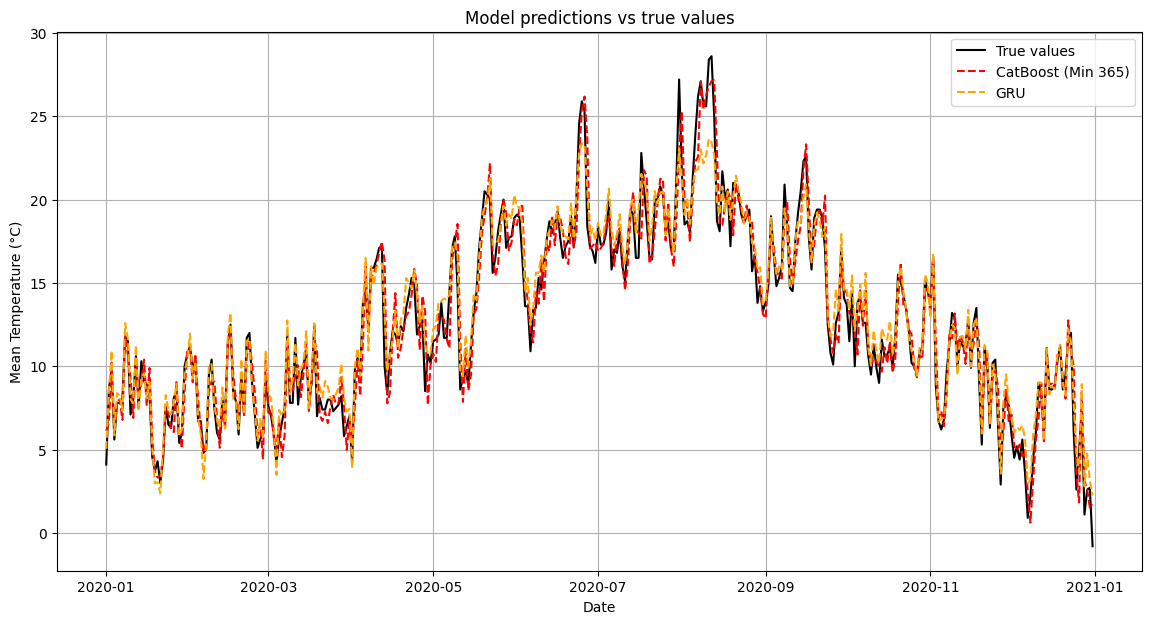

In [1299]:
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['mean_temp'], label='True values', color='black')
plt.plot(test_data_cb.index, test_data_cb['model_prediction_cb'], label='CatBoost (Min 365)', color='red', linestyle='--')
plt.plot(test_data_gru.index, test_data_gru['model_predictio_gru'], label='GRU', color='orange', linestyle='--')

plt.title('Model predictions vs true values')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

<center>

**Résumé des résultats obtenus pour les différents modèles sur un horizon annuel**

| Modèle            |  RMSE  | 
|-------------------|--------|
| Naive             |  6.434 | 
| Seasonal Naive    |  4.362 | 
| GRU               |  1.098 |  
| CatBoost          |  1.441 | 


</center>


<span id="7.4."></span>

### 7.4. Exploration sur différents horizons

Jusqu'à présent, nous nous sommes concentrées sur la prédiction de la température moyenne sur un horizon annuel. Cette approche a fourni des insights intéressants et a mis en évidence l'efficacité de nos modèles, notamment le GRU et CatBoost, sur des prédictions à long terme. Ces prévisions étendues sont particulièrement pertinentes pour les prises de décision stratégiques dans divers secteurs tels que l'énergie et l'agriculture.

Cependant, il est également essentiel dans de nombreux cas de pouvoir prédire des conditions météorologiques sur des périodes plus courtes. 

Pour évaluer l'adaptabilité et la robustesse de nos modèles, nous allons maintenant les tester sur des horizons de prévision plus courts. Nous commencerons par tester nos modèles sur une semaine, puis sur un mois. Cette analyse nous permettra de déterminer si les modèles qui se sont révélés efficaces sur une échelle annuelle conservent leur performance lorsqu'ils sont confrontés à des périodes plus brèves.

Nous avons déjà optimisé nos modèles et évalué leur performance à l'aide de la recherche d'hyperparamètres, du contrôle de l'overfitting et de la validation croisée. Nous utiliserons ces mêmes modèles optimisés pour prédire les valeurs de température à plus court terme.

<span id="7.4.1."></span>

#### 7.4.1. Horizon de prévision : 7 jours

In [1314]:
reset_random_seeds()

train_data = df[df.index < "2020-12-25"]     # Toutes les données jusqu'au 25 décembre 2020
test_data = df[df.index >= "2020-12-25"]     # Dernière semaine de décembre 

best_model, preprocessor = build_optimized_model(best_params)

X_train = preprocessor.fit_transform(train_data[features])
y_train = train_data[target].to_numpy()
X_test = preprocessor.transform(test_data[features])
y_test = test_data[target].to_numpy()

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

best_model.fit(X_train, y_train, epochs=100, batch_size=32)
test_rmse = np.sqrt(mean_squared_error(y_valid, best_model.predict(X_valid)))

print(f"Test RMSE: {test_rmse}")

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 124.1980
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 30.5719
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22.7007
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.8338
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.9856
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.6136
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8149
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7130
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.2330
Epoch 10/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7285
Epoch 11/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7139
Epoch 12/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3694
Epoch 13/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4177
Epoch 14/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.4322
Epoch 15/100
114/114 ━━━━━━━━━━━━━━━

In [1316]:
train_data = df[df.index < "2020-12-25"]     # Toutes les données jusqu'au 25 décembre 2020
test_data = df[df.index >= "2020-12-25"]     # Dernière semaine de décembre 

X_train, y_train = train_data.drop('mean_temp', axis=1), train_data['mean_temp']
X_test, y_test = test_data.drop('mean_temp', axis=1), test_data['mean_temp']

model = CatBoostRegressor(**params, random_seed=42, verbose=0)
model.fit(X_train, y_train, verbose=False)

y_pred_test = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Test RMSE: {test_rmse}")

Test RMSE: 1.7399610397246839


<span id="7.4.2."></span>

#### 7.4.2. Horizon de prévision : 31 jours

In [1317]:
reset_random_seeds()

train_data = df[df.index < "2020-11-30"]     # Toutes les données jusqu'au 31 novembre 2020
test_data = df[df.index >= "2020-11-30"]     # Dernier mois de décembre 

best_model, preprocessor = build_optimized_model(best_params)

X_train = preprocessor.fit_transform(train_data[features])
y_train = train_data[target].to_numpy()
X_test = preprocessor.transform(test_data[features])
y_test = test_data[target].to_numpy()

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

best_model.fit(X_train, y_train, epochs=100, batch_size=32)
test_rmse = np.sqrt(mean_squared_error(y_valid, best_model.predict(X_valid)))

print(f"Test RMSE: {test_rmse}")

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 120.4704
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 29.9895
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 21.5093
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.4225
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.5281
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.8176
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.0480
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.3766
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.1613
Epoch 10/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3727
Epoch 11/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2135
Epoch 12/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5691
Epoch 13/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2988
Epoch 14/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1782
Epoch 15/100
114/114 ━━━━━━━━━━━

In [1318]:
train_data = df[df.index < "2020-11-30"]     # Toutes les données jusqu'au 31 novembre 2020
test_data = df[df.index >= "2020-11-30"]     # Dernier mois de décembre 

X_train, y_train = train_data.drop('mean_temp', axis=1), train_data['mean_temp']
X_test, y_test = test_data.drop('mean_temp', axis=1), test_data['mean_temp']

model = CatBoostRegressor(**params, random_seed=42, verbose=0)
model.fit(X_train, y_train, verbose=False)

y_pred_test = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Test RMSE: {test_rmse}")

Test RMSE: 1.3655773653967767


<span id="7.5."></span>

### 7.5. Résumé des résultats sur les différents horizons

<center>

**Résumé des résultats obtenus pour les différents modèles sur plusieurs horizons**

| Modèle    |1 semaine |  1 mois  |   1 an   | 
|-----------|----------|----------|----------|
| GRU       |   1.113  |  1.396   |  1.098   |
| CatBoost  |   1.740  |  1.366   |  1.441   |

</center>

<span id="8."></span>

## 8. Performance des modèles  : discussion 

Les résultats obtenus ci-dessus illustrent la performance de différents modèles réalisés pour prédire la température moyenne à Londres. Sur un horizon d'un an, nous avons tout d’abord les modèles naïfs qui servent de référence initiale permettant de comparer la performance des modèles plus complexes. Le modèle naïf simple se contente uniquement de prédire la valeur du jour en utilisant celle du jour précédent. Nous pouvons voir qu’il possède une RMSE de 6.434, ce qui suggère que les températures varient significativement d’un jour à l’autre et que cette méthode ne capture pas la variabilité. Le naïf saisonal quant à lui utilise la valeur saisonnière pour la prédiction. Notons que la saison ici est fixée à 365 jours. Il possède une RMSE de 4.362, ce qui signifie que les prédictions du modèle ont en moyenne une erreur d’environ 4.362°C par rapport aux température réelles. Sa meilleure performance par rapport au naïf simple illustre donc l’importance des motifs saisonniers dans les prévisions météorologiques.

Concernant le modèle CatBoost, toujours sur un horizon d'un an, nous obtenons une performance significativement supérieure à celle des modèles naïfs avec une RMSE de 1.441. Cela montre alors l’efficacité des modèles de type Gradient Boosting dans la capture des relations complexes entre les features par rapport à un modèle basique. 

Nous pouvons voir que c’est le GRU qui obtient la meilleure performance sur un horizon d'un an avec une RMSE de 1.098. Cela signifie que les prédictions du modèle ont en moyenne une erreur d’environ 1 °C par rapport aux température réelles. De ce fait, cette meilleure performance par rapport aux autres modèles (même si très proche du CatBoost) met en avant la capacité des GRU à modéliser des dépendances à long terme et à saisir les dépendances temporelles des données météorologiques.  

L'extension de notre analyse sur des horizons de prévision plus courts de 7 jours et d'un mois permet d'avoir une perspective additionnelle sur la flexibilité et la réactivité des modèles GRU et CatBoost. Les performances de ces modèles sur des périodes réduites révèlent leur aptitude à saisir les variations climatiques sur des intervalles temporels distincts et à ajuster leurs prédictions en conséquence. Par ailleurs, nous pouvons noter que le GRU surpasse le CatBoost sauf sur un horizon d'un mois. 

Il n'existe pas un bon modèle spécifique à la météorologie. De ce fait, le choix d'un modèle ici dépend des besoins que nous avons et de l'analyse que nous souhaitons effectuer par la suite. Ainsi la sélection du modèle approprié pour répondre à nos besoins est primordiale. Elle peut par ailleurs avoir un impact important sur certains secteurs comme le tourisme, l’agriculture ou la construction d’infrastructures par exemple. Certains secteurs peuvent requérir une prévision précise de la température car cette dernière peut avoir une grande influence sur celui-ci. Pour ce genre d’applications qui nécessitant une plus grande précision, des modèles plus sophistiqués tels que le CatBoost ou les GRU sont préférables malgré leur complexité et leur temps de calcul plus important. Par exemple, dans le secteur énergétique, une prédiction précise de la température permet d'optimiser la production et la distribution d'énergie, ce qui peut entraîner des économies significatives et une réduction des déchets énergétiques. Ainsi, même si ce type de modèle peut entrainer d’importants coûts, l'amélioration de la précision des prévisions justifie l'investissement. En revanche, pour d’autres secteurs qui ne nécessitent pas une prévision précise de la température où une précision au degré près n'est pas nécessaire, un modèle naïf saisonal pourra suffire et sera plus adapté en termes de temps de calcul, de ressources computationnelles et de coûts. Par exemple, une erreur de prédiction de 4 °C peut être acceptable pour certaines activités générales. 

Ainsi, le choix d'un modèle prédictif doit être guidé par un compromis entre précision, coût et complexité, ainsi que par l'importance de la prévision pour le domaine d'application concerné. De plus, les organisations doivent également tenir compte de leur capacité à intégrer et à maintenir ces systèmes prédictifs au sein de leur infrastructure existante.

<span id="9."></span>

## 9. Conclusion et améliorations

Pour conclure sur les prévisions météorologiques à Londres, nous avons exploré différentes méthodes de prévisions, des méthodes plus simples à des méthodes plus complexes. Les résultats montrent que l’utilisation de modèles plus complexes et sophistiqués comme les GRU offrent des prévisions plus précises mais nécessitent des ressources et des coûts plus importants. Ils sont donc plus adaptés à des contextes qui nécessitent une importante exactitude. 

Comme nous avons pu le voir l’erreur minimale que nous avons obtenue et d’environ 1°C, cela peut rester élevé dans certains contextes. Ainsi, des améliorations sont envisageables. Nous pourrions par exemple introduire des lags inférieurs à 365 dans le modèle CatBoost. Les lags de 1, 2, 3, 7, 14, 30 et 90 jours pourraient révéler des patterns importants liés aux variations climatiques sur des périodes plus courtes et pourraient être d'autant plus importants pour des prévisions à plus court terme sur une semaine ou un mois par exemple. Néanmoins, cela nécessiterait la considération de stratégies d’entrainement comme la méthode directe ou récursive par exemple. Cela exigerait une réflexion sur la question car il serait inenvisageable de construire 365 modèles mais l’utilisation d’une méthode récursive pourrait engendrer une perte d’information importante. De plus, une exploration plus poussée des hyperparamètres pourrait encore améliorer les performances. Bien qu’Optuna ait fourni une bonne base, une recherche plus fine pourrait débloquer de nouvelles améliorations. Enfin, l'utilisation de modèles hybrides pourraient également constituer une amélioration.